Okay, time to rebuild our old statistical pipeline as best as we can. We will keep only the essential portions, in the interests of time and clarity.

## Contents

[Importing biom table and setup](#import)  


[Controls](#controls)
- [Negative controls](#negC)
 - [Positive controls (mock community)](#mock)
   - [Genomic](#gPos)
   - [ITS-only](#iPos)
 - [Cleanup using controls](#cleanup)  
    - [Removing low abundance samples](#lowSamp)  
    - [Minimum abundances of observations and contaminant removal](#minAbund)
    - [Subtracting contaminant abundances](#subContam)
    - [Remove all mock community OTUs](#remMCs)  
    
[Variance stabilization of reads](#varstab)
  - [Apply DESeq2 algorithms](#DESeq2)
  - [Compare pre/post variance-stabilization distibutions](#BAvarstab)

[NMS/PERMANOVA Ordinations](#NMSs)
  - [Wood vs. Leaf libraries, all reads](#WvLNMS)
  - [Wood vs. Leaf endophyte comparison, look for shared species](#WvLshared)
  - [Host NMS/PermANOVA](#HostNMS)
    - [Wood library, Host effects](#woodHostNMS)
    - [Leaf library, Host effects](#leafHostNMS)
  - [PERMANOVA models of environmental variables](#PERMenv)
    - [Wood environmental data](#woodenv)  
    - [Leaf environmental data](#leafenv)

[Cooccurrence network analysis](#cooc)
  - [Wood coocurrence networks](#woodCooc)
  - [Leaf coocurrence networks](#leafCooc)

[Community composition](#comcomp)

[All-host spatial analysis](#allSpatial)
  - [Mantel tests](#mantel)
  - [Distance-based MEMs](#dbMEMs)
    - [Leaf dbMEMs](#leafdbMEM)
    - [Wood dbMEMs](#wooddbMEM)

[Spatial patterns of Helicia mycobiome](#helSpace)

<a id='import'><h2>Importing biom table and setup</h2></a>

In [3]:
library('phyloseq')
library('DESeq2')
library('vegan')
library('cooccur')
library('igraph')
library('ecodist')
library('ade4')
library('png')
library('randomcoloR')
library('VennDiagram')

Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colMeans, colnames,
    colSums, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, lengths, Map, mapply, match,
    mget, order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rowMeans, rownames, rowSums, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which, which.max, which.min


Attaching packag

In [6]:
biom95 <- import_biom('combo_otu_wMeta.biom', parseFunction=parse_taxonomy_greengenes)
#save(biom95, file='biom95.rda')

In [6]:
biom95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11588 taxa and 232 samples ]
sample_data() Sample Data:       [ 232 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 11588 taxa by 7 taxonomic ranks ]

In [10]:
sample_data(biom95)

vegcom stream_distance Host_genus  Host_genus_species                
100leaf  2      25.97654        Helicia     Helicia_formosana                 
101leaf  3      18.36984        Helicia     Helicia_formosana                 
102leaf  3      21.3725         Cleyera     Cleyera_japonica                  
103leaf  3      11.08831        Helicia     Helicia_formosana                 
104leaf  3      1.409998        Helicia     Helicia_formosana                 
105leaf  3      22.46722        Limlia      Limlia_uraiana                    
106leaf  2      82.49734        Helicia     Helicia_formosana                 
107leaf  1      64.85876        Blastus     Blastus_cochinchinensis           
108leaf  1      19.02113        Cleyera     Cleyera_japonica                  
109leaf  3      13.46815        Meliosma    Meliosma_squamulata               
110leaf  3      13.46815        Limlia      Limlia_uraiana                    
111leaf  3      20.37973        Limlia      Limlia_uraiana                    
112leafA 2      4.250151        Blastus     Blastus_cochinchinensis           
112leafB 2      4.250151        Blastus     Blastus_cochinchinensis           
113leafA 3      12.80385        Schefflera  Schefflera_octophylla             
113leafB 3      12.80385        Schefflera  Schefflera_octophylla             
114leaf  2      6.015914        Helicia     Helicia_formosana                 
115leaf  3      16.75811        Cyathea     Cyathea_podophylla                
116leaf  3      24.2118         Helicia     Helicia_formosana                 
117leaf  3      30.79582        Limlia      Limlia_uraiana                    
118leaf  3      30.50139        Limlia      Limlia_uraiana                    
119leaf  3      29.54256        Limlia      Limlia_uraiana                    
120leaf  3      29.84645        Limlia      Limlia_uraiana                    
121leaf  3      27.95829        Blastus     Blastus_cochinchinensis           
122leaf  3      27.07621        Limlia      Limlia_uraiana                    
125leaf  3      27.32744        Litsea      Litsea_acuminata                  
126leafA 3      20.16175        Blastus     Blastus_cochinchinensis           
126leafB 3      20.16175        Blastus     Blastus_cochinchinensis           
127leaf  3      11.69457        Helicia     Helicia_formosana                 
128leaf  3      75.54028        Castanopsis Castanopsis_cuspidata_var_carlesii
⋮        ⋮      ⋮               ⋮           ⋮                                 
88w      2      47.36483        Cryptocarya Cryptocarya_chinensis             
89w      2      25.33942        Helicia     Helicia_formosana                 
92w      2      31.43415        Blastus     Blastus_cochinchinensis           
93w      2      27.63549        Prunus      Prunus_phaeosticta                
94w      2      25.06622        Ficus       Ficus_erecta_var_beecheyana       
95w      2      25.33385        Ficus       Ficus_erecta_var_beecheyana       
96w      3      24.37728        Helicia     Helicia_formosana                 
97w      3      24.09903        Helicia     Helicia_formosana                 
99w      3      23.19752        Helicia     Helicia_formosana                 
100w     2      25.97654        Helicia     Helicia_formosana                 
101w     3      18.36984        Helicia     Helicia_formosana                 
102w     3      21.3725         Cleyera     Cleyera_japonica                  
104w     3      1.409998        Helicia     Helicia_formosana                 
106w     2      82.49734        Helicia     Helicia_formosana                 
107w     1      64.85876        Blastus     Blastus_cochinchinensis           
108w     1      19.02113        Cleyera     Cleyera_japonica                  
109w     3      13.46815        Meliosma    Meliosma_squamulata               
114w     2      6.015914        Helicia     Helicia_formosana                 
115w     3      16.75811        Cyathea     Cyathea_podophy

<a id='controls'><h2>Controls</h2></a>

<a id='negC'><h3>Negative controls</h3></a>

In [89]:
neg95 <- subset_samples(biom95, sample_names(biom95)=='Neg')

In [90]:
neg95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11588 taxa and 1 samples ]
sample_data() Sample Data:       [ 1 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 11588 taxa by 7 taxonomic ranks ]

How many reads are in our negative control?

In [16]:
sum(taxa_sums(neg95)[taxa_sums(neg95)>0])

[1] 1501

How many OTUs?

In [17]:
length(taxa_sums(neg95)[taxa_sums(neg95)>0])

[1] 43

Which OTUs, and what's their distribution?

In [19]:
taxa_sums(neg95)[taxa_sums(neg95)>0]

OTU167:Dc-X OTU187:Dc-PosG    OTU256:Dc-X    OTU762:Dc-X      OTU891:1w 
           469             85             35             53             58 
OTU306:Dc-PosG OTU119:Dc-PosG OTU220:Dc-PosG OTU164:Dc-PosG OTU235:Dc-PosG 
            96              1              1             51              1 
OTU386:Dc-PosG OTU264:Dc-PosG OTU560:Dc-PosG    OTU1183:36w       OTU64:1w 
            88              1             39              1              1 
     OTU409:4w      OTU417:1w      OTU437:1w       OTU18:9w     OTU414:13w 
             1             15              1              1              1 
     OTU655:1w     OTU2029:2w     OTU1432:2w    OTU1332:11w      OTU315:4w 
             1              1             28             44            162 
     OTU250:4w     OTU1599:9w     OTU2831:5w      OTU84:38w    OTU7329:38w 
             1              4              4             12              1 
   OTU2003:Neg    OTU925:133w     OTU1214:9w    OTU1747:11w   OTU1549:104w 
            42              1             53             53             28 
   OTU6852:Neg    OTU1496:23w     OTU588:32w    OTU1888:25w    OTU1444:49w 
            20              1              1              1             38 
     OTU46:60w    OTU972:130w   OTU2115:131w 
             3              1              2

To check for tag-switching, we'll look at our positive controls, or "mock-community" samples, for OTUs shared between the two controls. Such OTUs are good candidates for tag-switching. 

In [20]:
reads <- taxa_sums(neg95)[taxa_sums(neg95) > 0]
reads <- sort(reads, decreasing = TRUE)
sink('neg95names.txt') ## read out these OTUs so we can use them in python env
names(reads)
sink()

[1] "OTU167:Dc-X"    "OTU315:4w"      "OTU306:Dc-PosG" "OTU386:Dc-PosG"
 [5] "OTU187:Dc-PosG" "OTU891:1w"      "OTU762:Dc-X"    "OTU1214:9w"    
 [9] "OTU1747:11w"    "OTU164:Dc-PosG" "OTU1332:11w"    "OTU2003:Neg"   
[13] "OTU560:Dc-PosG" "OTU1444:49w"    "OTU256:Dc-X"    "OTU1432:2w"    
[17] "OTU1549:104w"   "OTU6852:Neg"    "OTU417:1w"      "OTU84:38w"     
[21] "OTU1599:9w"     "OTU2831:5w"     "OTU46:60w"      "OTU2115:131w"  
[25] "OTU119:Dc-PosG" "OTU220:Dc-PosG" "OTU235:Dc-PosG" "OTU264:Dc-PosG"
[29] "OTU1183:36w"    "OTU64:1w"       "OTU409:4w"      "OTU437:1w"     
[33] "OTU18:9w"       "OTU414:13w"     "OTU655:1w"      "OTU2029:2w"    
[37] "OTU250:4w"      "OTU7329:38w"    "OTU925:133w"    "OTU1496:23w"   
[41] "OTU588:32w"     "OTU1888:25w"    "OTU972:130w"

Clean up with sed. Back into BASH kernel:

In [1]:
## BASH
sed 's/\[.*\]//g' neg95names.txt |sed 's/^\s*//g' | sed 's/\s\+/,/g' | sed '$s/,$/\)/' | sed '1s/\"OTU/mcseq=\(\"OTU/' > neg95list.txt

Checked with vim, had to add a comma or two, not sure why. Anyway, its a a tuple. And the second half of the script:

In [11]:
cat MCseq.py


with open('otus_95_combo_nolb.fasta', 'r') as zoop:
        refseq = zoop.readlines()

with open('mcseq.txt', 'w') as goop:
        for j,otu in enumerate(mcseq):
                for i,line in enumerate(refseq):
                        if otu in line:
                                goop.write(line)
                                goop.write(refseq[i+1])




In [12]:
cat neg95list.txt MCseq.py > makeMCseq.py

In [13]:
cat makeMCseq.py

mcseq=("OTU167:Dc-X","OTU315:4w","OTU306:Dc-PosG","OTU386:Dc-PosG",
"OTU187:Dc-PosG","OTU891:1w","OTU762:Dc-X","OTU1214:9w",
"OTU1747:11w","OTU164:Dc-PosG","OTU1332:11w","OTU2003:Neg",
"OTU560:Dc-PosG","OTU1444:49w","OTU256:Dc-X","OTU1432:2w",
"OTU1549:104w","OTU6852:Neg","OTU417:1w","OTU84:38w",
"OTU1599:9w","OTU2831:5w","OTU46:60w","OTU2115:131w",
"OTU119:Dc-PosG","OTU220:Dc-PosG","OTU235:Dc-PosG","OTU264:Dc-PosG",
"OTU1183:36w","OTU64:1w","OTU409:4w","OTU437:1w",
"OTU18:9w","OTU414:13w","OTU655:1w","OTU2029:2w",
"OTU250:4w","OTU7329:38w","OTU925:133w","OTU1496:23w",
"OTU588:32w","OTU1888:25w","OTU972:130w")

with open('otus_95_combo_nolb.fasta', 'r') as zoop:
        refseq = zoop.readlines()

with open('mcseq.txt', 'w') as goop:
        for j,otu in enumerate(mcseq):
                for i,line in enumerate(refseq):
                        if otu in line:
                                goop.write(line)
                                goop.write(refseq[i+1])




In [14]:
## run this to get sequences of OTUs that are in our positive control:
python3 makeMCseq.py

Make a friendly link to our sanger sequences of full ITS region of our positive control cultures, and make a blastable database from them:

In [17]:
aa=$(find ~ -type f -name "BioI-6098_OConnor_34875.seq.txt")
ln -s $aa ./mcsanger.fasta

In [19]:
## make our searchable database of sanger positive control sequences for blast:
makeblastdb -in mcsanger.fasta -dbtype nucl -logfile dberrors.txt

Do our searches, with a couple of output formats:

In [20]:
## clean up read ids a little:
sed '/^>/ s/;size=.*//' mcseq.txt | sed '/^>/ s/;size=.*//' mcseq.txt > mockseqs_Neg95.fasta

blastn -query mockseqs_Neg95.fasta -db mcsanger.fasta -out mcblast_Neg95.txt -num_descriptions 3 -num_alignments 3
blastn -query mockseqs_Neg95.fasta -db mcsanger.fasta -out mcblast_Neg95.csv -outfmt 10 -max_target_seqs 1

sed '1 i\qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore' mcblast_Neg95.csv -i
sed 's/_ITS[1,4],/,/g' mcblast_Neg95.csv -i
sed 's/Sample//g' mcblast_Neg95.csv -i

This csv file can be imported as a dataframe into R:

In [85]:
## change kernel to R
library('phyloseq')
blast <- read.csv("mcblast_Neg95.csv", stringsAsFactors=FALSE)
blast

qseqid         sseqid pident length mismatch gapopen qstart qend sstart send
1  OTU306:Dc-PosG  9     100.00 176    0        0        1     176  504    329 
2  OTU386:Dc-PosG 19     100.00 175    0        0        1     175  513    339 
3  OTU164:Dc-PosG  8     100.00 143    0        0        1     143  451    309 
4  OTU560:Dc-PosG  4     100.00 180    0        0        1     180  485    306 
5  OTU256:Dc-X     6     100.00 184    0        0        1     184  535    352 
6  OTU84:38w       9     100.00  31    0        0       27      57  530    500 
7  OTU1599:9w      1      90.22  92    8        1       37     128  459    369 
8  OTU119:Dc-PosG  1      99.31 144    1        0        1     144  434    291 
9  OTU220:Dc-PosG 22     100.00 168    0        0        1     168  512    345 
10 OTU235:Dc-PosG 20     100.00 217    0        0        1     217  605    389 
11 OTU264:Dc-PosG 16     100.00 180    0        0        1     180  502    323 
   evalue bitscore
1   3e-92 326.0   
2   1e-91 324.0   
3   5e-74 265.0   
4   2e-94 333.0   
5   1e-96 340.0   
6   1e-11  58.4   
7   6e-30 119.0   
8   7e-73 261.0   
9   8e-88 311.0   
10 6e-115 401.0   
11  2e-94 333.0

Get rid of the lower quality matches:

In [87]:
goodblast <- blast[blast$pident > 94 & blast$length > 90,]

Make some useful vectors and graph:

In [91]:
reads <- taxa_sums(neg95)[taxa_sums(neg95) > 0]
reads <- sort(reads, decreasing = TRUE)
Neg95.gen <- tax_table(neg95)[names(reads),6] ## genus, from initial tax assignments
Neg95.gen[is.na(Neg95.gen)] <- "NoID"
Neg95.species <- tax_table(neg95)[names(reads),7] ## species, from initial tax assignments
Neg95.species[is.na(Neg95.species)] <- "NoID"
member <- names(reads) %in% goodblast$qseqid ## membership in mock community (probably tag-switchers)
MC <- vector(length = length(reads)); MC[] <- 0 ## empty vector, for MC sample #, filled below

In [92]:
Neg95bar <- data.frame(reads, member, MC, Neg95.gen, Neg95.species, stringsAsFactors=FALSE) ## dataframe

##fill the mock community sample number by querying our csv from blast results

colnames(Neg95bar)[1] <- "reads"
for (i in 1:nrow(Neg95bar)){
        if (rownames(Neg95bar)[i] %in% goodblast$qseqid) {
                search <- grep(rownames(Neg95bar)[i], goodblast$qseqid)
                Neg95bar$MC[i] <- goodblast$sseqid[search]
        }
    }


In [95]:
#save(Neg95bar, file='Neg95bar.rda')

<a id='NegGraph'></a>

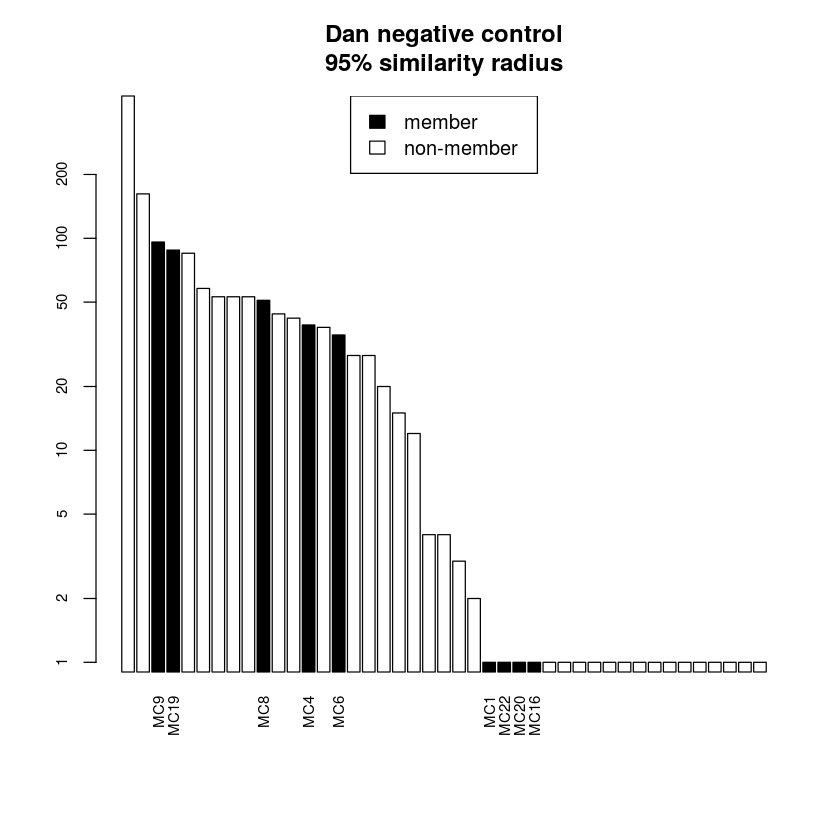

In [7]:
inout <- paste('MC', Neg95bar$MC, sep='')
inout[inout=='MC0'] <- NA

par(cex.axis = .75, mar=c(7,4,4,2))
barplot(Neg95bar$reads,las=3,log='y', names.arg=inout, col = member,
       main = 'Dan negative control\n95% similarity radius')
legend("top", legend=c('member','non-member'), fill=c(1,0))

In [13]:
inout <- paste('MC', Neg95bar$MC, sep='')
inout[inout=='MC0'] <- NA

svg(file='Dan_negative_21.06.2018.svg')
par(cex.axis = .75, mar=c(7,4,4,2))
barplot(Neg95bar$reads,las=3,log='y', names.arg=inout, col = member,
       main = 'Dan negative control\n95% similarity radius')
legend("top", legend=c('member','non-member'), fill=c(1,0))
dev.off()

png 
  2

This new pipeline shows a few less low-abundance OTUs shared between the negative and positive controls, but the big picture is more or less the same. A fair amound of tag-switched reads, with the two most abundant tag-switched OTUs at around 100 reads. 

<a id='mock'><h3>Positive controls</h3></a>

Let's take a look at our genomic positive controls.

In [10]:
aa95 <- subset_samples(biom95, sample_names(biom95) == 'PosG')
dangen95 <- taxa_sums(aa95)[taxa_sums(aa95) > 0]
dangen95 <- sort(dangen95, decreasing = TRUE)
length(dangen95)

[1] 58

In [19]:
save(dangen95, file='dangen95.rda')

24 species were intentionally put into the positive control. Here we detected 58. 

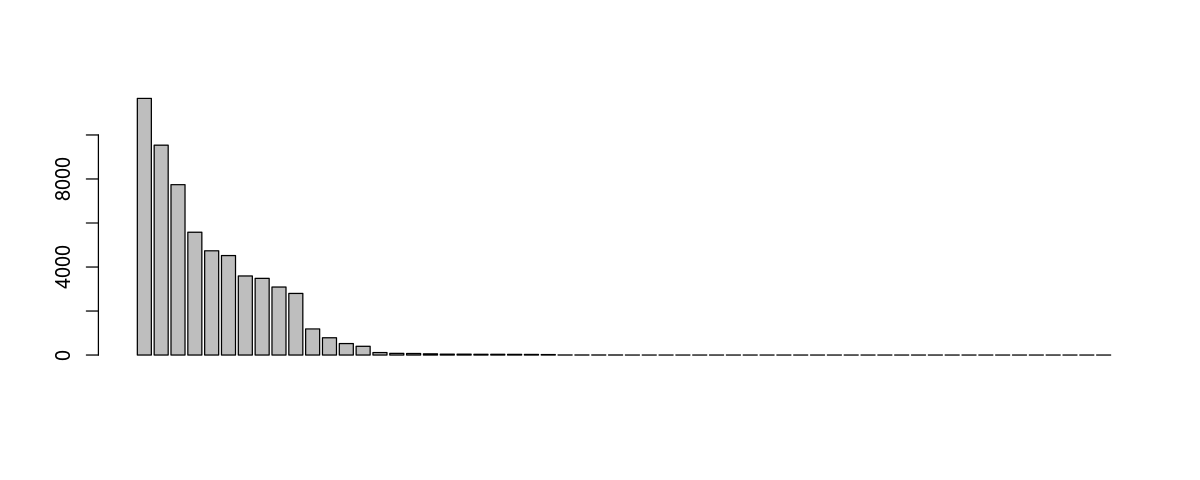

In [18]:
options(repr.plot.width = 10, repr.plot.height = 4)
barplot(dangen95, names.arg='')

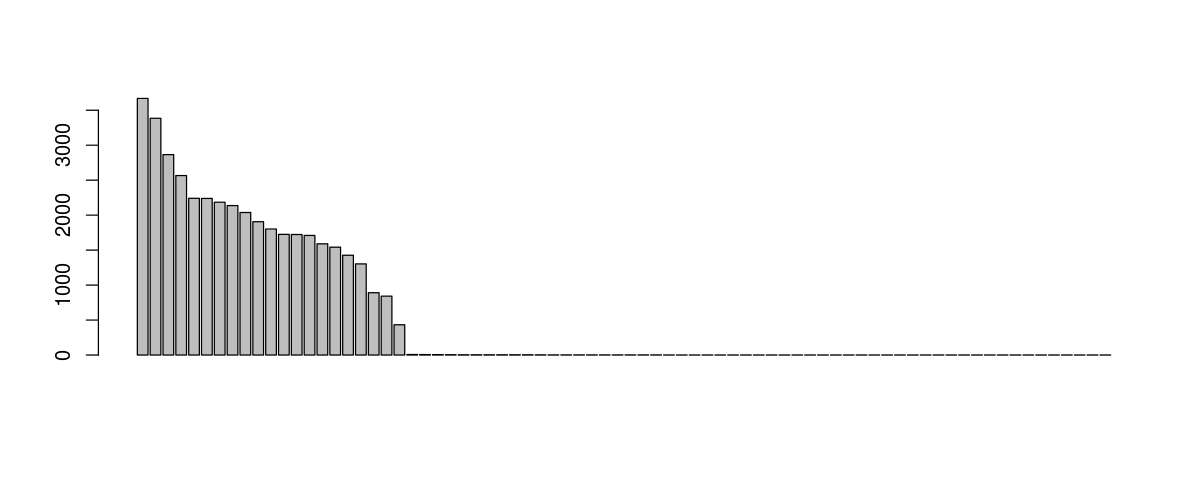

In [20]:
aa95 <- subset_samples(biom95, sample_names(biom95) == 'PosI')
danITS95 <- taxa_sums(aa95)[taxa_sums(aa95) > 0]
danITS95 <- sort(danITS95, decreasing = TRUE)
options(repr.plot.width = 10, repr.plot.height = 4)
barplot(danITS95, names.arg='')

In [ ]:
save()

<a id='gPos'><h4>Genomic positive control</h4></a>

To show which of these are intended members of the mock community, not contaminants, we'll use the same kind of pipeline as we used above for the negative controls. Focus on the genomic positive control first, in which genomic DNA from all of our MC cultures were introduced in equal DNA concentrations into a single sample. 

In [3]:
aa95 <- subset_samples(biom95, sample_names(biom95) == 'PosG')
danGenreads <- taxa_sums(aa95)[taxa_sums(aa95) > 0]
danGenreads <- sort(danGenreads, decreasing = TRUE)
sink('danGenreads.txt') ## read out these OTUs so we can use them in python env
names(danGenreads)
sink()

[1] "OTU106:Dc-PosG"  "OTU119:Dc-PosG"  "OTU164:Dc-PosG"  "OTU191:Dc-PosG" 
 [5] "OTU220:Dc-PosG"  "OTU235:Dc-PosG"  "OTU258:Dc-PosG"  "OTU271:Dc-PosG" 
 [9] "OTU270:Dc-PosG"  "OTU358:Dc-PosG"  "OTU306:Dc-PosG"  "OTU264:Dc-PosG" 
[13] "OTU386:Dc-PosG"  "OTU526:Dc-PosG"  "OTU407:Dc-PosG"  "OTU256:Dc-X"    
[17] "OTU608:Dc-PosG"  "OTU826:Dc-PosG"  "OTU3183:Dc-PosG" "OTU3723:Dc-PosG"
[21] "OTU3674:Dc-PosG" "OTU12510:PosG"   "OTU4453:Dc-PosG" "OTU4210:Dc-PosG"
[25] "OTU733:Dc-PosG"  "OTU9035:Dc-PosG" "OTU1153:Dc-PosI" "OTU560:Dc-PosG" 
[29] "OTU8984:Dc-PosG" "OTU10988:PosG"   "OTU9833:Dc-PosI" "OTU248:20w"     
[33] "OTU18:9w"        "OTU610:1w"       "OTU257:3w"       "OTU12502:PosG"  
[37] "OTU8986:Dc-PosG" "OTU8401:Dc-PosG" "OTU152:1w"       "OTU77:1w"       
[41] "OTU28:2w"        "OTU249:1w"       "OTU5738:17w"     "OTU1075:100w"   
[45] "OTU391:2w"       "OTU1524:3w"      "OTU7955:106w"    "OTU5111:14w"    
[49] "OTU84:38w"       "OTU1124:36w"     "OTU1466:9w"      "OTU1214:9w"     
[53] "OTU1941:17w"     "OTU428:45w"      "OTU2567:130w"    "OTU1516:133w"   
[57] "OTU1866:133w"    "OTU12503:PosG"

The script to get the sequences of OTUs present in our illumina survey of our mock-community.

In [1]:
cat danGen_makeMCseq.py

mcseq=("OTU256:Dc-X","OTU306:Dc-PosG","OTU119:Dc-PosG","OTU220:Dc-PosG",
"OTU270:Dc-PosG","OTU191:Dc-PosG","OTU164:Dc-PosG","OTU235:Dc-PosG",
"OTU358:Dc-PosG","OTU106:Dc-PosG","OTU3674:Dc-PosG","OTU386:Dc-PosG",
"OTU271:Dc-PosG","OTU407:Dc-PosG","OTU258:Dc-PosG","OTU264:Dc-PosG",
"OTU4210:Dc-PosG","OTU1153:Dc-PosI","OTU8984:Dc-PosG","OTU526:Dc-PosG",
"OTU12510:PosG","OTU3723:Dc-PosG","OTU4453:Dc-PosG","OTU608:Dc-PosG",
"OTU3183:Dc-PosG","OTU826:Dc-PosG","OTU733:Dc-PosG","OTU8986:Dc-PosG",
"OTU9035:Dc-PosG","OTU8401:Dc-PosG","OTU560:Dc-PosG","OTU10988:PosG",
"OTU9833:Dc-PosI","OTU248:20w","OTU152:1w","OTU77:1w",
"OTU28:2w","OTU249:1w","OTU18:9w","OTU5738:17w",
"OTU610:1w","OTU1075:100w","OTU391:2w","OTU1524:3w",
"OTU257:3w","OTU7955:106w","OTU5111:14w","OTU84:38w",
"OTU1124:36w","OTU1466:9w","OTU1214:9w","OTU1941:17w",
"OTU428:45w","OTU2567:130w","OTU1516:133w","OTU1866:133w",
"OTU12502:PosG","OTU12503:PosG")

with open('otus_95_combo_nolb.fasta', 'r') as zoop:
        refseq = zoop.rea

In [4]:
python3 danGen_makeMCseq.py

In [5]:
sed -i '/^>/ s/;size=.*//' seqs_dangen95.fasta 

blastn -query seqs_dangen95.fasta -db mcsanger.fasta -out mcblast_Dangen95.txt -num_descriptions 3 -num_alignments 3
blastn -query seqs_dangen95.fasta -db mcsanger.fasta -out mcblast_Dangen95.csv -outfmt 10 -max_target_seqs 1

sed '1 i\qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore' mcblast_Dangen95.csv -i
sed 's/_ITS[1,4],/,/g' mcblast_Dangen95.csv -i
sed 's/Sample//g' mcblast_Dangen95.csv -i

In [4]:
## change kernel to R
library('phyloseq')

In [2]:
blast <- read.csv("mcblast_Dangen95.csv", stringsAsFactors=FALSE)
blast

qseqid          sseqid pident length mismatch gapopen qstart qend sstart
1  OTU256:Dc-X      6     100.00 184    0        0        1     184  535   
2  OTU306:Dc-PosG   9     100.00 176    0        0        1     176  504   
3  OTU119:Dc-PosG   1      99.31 144    1        0        1     144  434   
4  OTU220:Dc-PosG  22     100.00 168    0        0        1     168  512   
5  OTU270:Dc-PosG  12     100.00 178    0        0        1     178  501   
6  OTU191:Dc-PosG  14     100.00 197    0        0        1     197  566   
7  OTU164:Dc-PosG   8     100.00 143    0        0        1     143  451   
8  OTU235:Dc-PosG  20     100.00 217    0        0        1     217  605   
9  OTU358:Dc-PosG  15     100.00 241    0        0        1     241  553   
10 OTU106:Dc-PosG  10     100.00 174    0        0        1     174  482   
11 OTU3674:Dc-PosG  1      95.24 126    6        0       19     144  416   
12 OTU386:Dc-PosG  19     100.00 175    0        0        1     175  513   
13 OTU271:Dc-PosG  24     100.00 209    0        0        1     209  537   
14 OTU407:Dc-PosG   7     100.00 193    0        0        1     193  524   
15 OTU258:Dc-PosG  13     100.00 180    0        0        1     180  492   
16 OTU264:Dc-PosG  16     100.00 180    0        0        1     180  502   
17 OTU4210:Dc-PosG  8      96.00 125    5        0       19     143  433   
18 OTU1153:Dc-PosI 18     100.00 361    0        0        1     361  761   
19 OTU526:Dc-PosG   5     100.00 232    0        0        1     232  562   
20 OTU12510:PosG    8      95.62 137    4        2        1     135  451   
21 OTU3723:Dc-PosG  1      95.00 140    5        2        1     140  434   
22 OTU4453:Dc-PosG  2     100.00 143    0        0        1     143  463   
23 OTU608:Dc-PosG  11     100.00 174    0        0        1     174  487   
24 OTU3183:Dc-PosG  8      94.89 137    5        2        1     135  451   
25 OTU826:Dc-PosG   3     100.00 157    0        0        1     157  555   
26 OTU733:Dc-PosG  23     100.00 208    0        0        1     208  528   
27 OTU8986:Dc-PosG 13      99.39 163    1        0       15     177  475   
28 OTU8401:Dc-PosG  1      99.16 119    1        0       19     137  409   
29 OTU560:Dc-PosG   4     100.00 180    0        0        1     180  485   
30 OTU10988:PosG    8     100.00 118    0        0       19     136  426   
31 OTU84:38w        9     100.00  31    0        0       27      57  530   
32 OTU12503:PosG   16      95.43 175    2        4        8     181  492   
   send evalue bitscore
1  352   1e-96 340.0   
2  329   3e-92 326.0   
3  291   7e-73 261.0   
4  345   8e-88 311.0   
5  324   2e-93 329.0   
6  370  7e-104 364.0   
7  309   5e-74 265.0   
8  389  6e-115 401.0   
9  313  3e-128 446.0   
10 309   4e-91 322.0   
11 291   1e-54 200.0   
12 339   1e-91 324.0   
13 329  2e-110 387.0   
14 332  1e-101 357.0   
15 313   2e-94 333.0   
16 323   2e-94 333.0   
17 309   1e-55 204.0   
18 401   0e+00 667.0   
19 331  3e-123 429.0   
20 315   4e-60 219.0   
21 297   4e-60 219.0   
22 321   5e-74 265.0   
23 314   4e-91 322.0   
24 315   2e-58 213.0   
25 399   9e-82 291.0   
26 321  6e-110 385.0   
27 313   2e-83 296.0   
28 291   5e-59 215.0   
29 306   2e-94 333.0   
30 309   4e-60 219.0   
31 500   1e-11  58.4   
32 323   1e-76 274.0

In [5]:
blast <- read.csv("mcblast_Dangen95.csv", stringsAsFactors=FALSE)
blast

qseqid          sseqid pident length mismatch gapopen qstart qend sstart
1  OTU256:Dc-X      6     100.00 184    0        0        1     184  535   
2  OTU306:Dc-PosG   9     100.00 176    0        0        1     176  504   
3  OTU119:Dc-PosG   1      99.31 144    1        0        1     144  434   
4  OTU220:Dc-PosG  22     100.00 168    0        0        1     168  512   
5  OTU270:Dc-PosG  12     100.00 178    0        0        1     178  501   
6  OTU191:Dc-PosG  14     100.00 197    0        0        1     197  566   
7  OTU164:Dc-PosG   8     100.00 143    0        0        1     143  451   
8  OTU235:Dc-PosG  20     100.00 217    0        0        1     217  605   
9  OTU358:Dc-PosG  15     100.00 241    0        0        1     241  553   
10 OTU106:Dc-PosG  10     100.00 174    0        0        1     174  482   
11 OTU3674:Dc-PosG  1      95.24 126    6        0       19     144  416   
12 OTU386:Dc-PosG  19     100.00 175    0        0        1     175  513   
13 OTU271:Dc-PosG  24     100.00 209    0        0        1     209  537   
14 OTU407:Dc-PosG   7     100.00 193    0        0        1     193  524   
15 OTU258:Dc-PosG  13     100.00 180    0        0        1     180  492   
16 OTU264:Dc-PosG  16     100.00 180    0        0        1     180  502   
17 OTU4210:Dc-PosG  8      96.00 125    5        0       19     143  433   
18 OTU1153:Dc-PosI 18     100.00 361    0        0        1     361  761   
19 OTU526:Dc-PosG   5     100.00 232    0        0        1     232  562   
20 OTU12510:PosG    8      95.62 137    4        2        1     135  451   
21 OTU3723:Dc-PosG  1      95.00 140    5        2        1     140  434   
22 OTU4453:Dc-PosG  2     100.00 143    0        0        1     143  463   
23 OTU608:Dc-PosG  11     100.00 174    0        0        1     174  487   
24 OTU3183:Dc-PosG  8      94.89 137    5        2        1     135  451   
25 OTU826:Dc-PosG   3     100.00 157    0        0        1     157  555   
26 OTU733:Dc-PosG  23     100.00 208    0        0        1     208  528   
27 OTU8986:Dc-PosG 13      99.39 163    1        0       15     177  475   
28 OTU8401:Dc-PosG  1      99.16 119    1        0       19     137  409   
29 OTU560:Dc-PosG   4     100.00 180    0        0        1     180  485   
30 OTU10988:PosG    8     100.00 118    0        0       19     136  426   
31 OTU84:38w        9     100.00  31    0        0       27      57  530   
32 OTU12503:PosG   16      95.43 175    2        4        8     181  492   
   send evalue bitscore
1  352   1e-96 340.0   
2  329   3e-92 326.0   
3  291   7e-73 261.0   
4  345   8e-88 311.0   
5  324   2e-93 329.0   
6  370  7e-104 364.0   
7  309   5e-74 265.0   
8  389  6e-115 401.0   
9  313  3e-128 446.0   
10 309   4e-91 322.0   
11 291   1e-54 200.0   
12 339   1e-91 324.0   
13 329  2e-110 387.0   
14 332  1e-101 357.0   
15 313   2e-94 333.0   
16 323   2e-94 333.0   
17 309   1e-55 204.0   
18 401   0e+00 667.0   
19 331  3e-123 429.0   
20 315   4e-60 219.0   
21 297   4e-60 219.0   
22 321   5e-74 265.0   
23 314   4e-91 322.0   
24 315   2e-58 213.0   
25 399   9e-82 291.0   
26 321  6e-110 385.0   
27 313   2e-83 296.0   
28 291   5e-59 215.0   
29 306   2e-94 333.0   
30 309   4e-60 219.0   
31 500   1e-11  58.4   
32 323   1e-76 274.0

Let's get rid of the short match, this is probably just a bit of the ssu or 5.8s.

In [6]:
goodblast <- blast[blast$length > 100,]

The sseqid column values are equivalent to numbers that we gave each DNA sample from our individual pure cultures. They go from MC1 to MC24, with sample MC21 skipped. 

In [7]:
1:24 %in% goodblast$sseqid

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE

In [8]:
sort(unique(goodblast$sseqid)); length(unique(goodblast$sseqid))

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 22 23 24

[1] 22

As per last time, we are missing MC17, which corresponds to *Schizosaccaromyces pombe*.

Put together some info for a plot/dataframe

In [11]:
member <- names(dangen95) %in% goodblast$qseqid
MC <- vector(length = length(dangen95))
dangen95bar <- data.frame(cbind(dangen95, member, MC))
for (i in 1:nrow(dangen95bar)){
        if (rownames(dangen95bar)[i] %in% goodblast$qseqid) {
                search <- grep(rownames(dangen95bar)[i], goodblast$qseqid)
                dangen95bar$MC[i] <- goodblast$sseqid[search]
        }
    }

In [12]:
head(dangen95bar)

dangen95 member MC
OTU106:Dc-PosG 11662    1      10
OTU119:Dc-PosG  9537    1       1
OTU164:Dc-PosG  7742    1       8
OTU191:Dc-PosG  5581    1      14
OTU220:Dc-PosG  4737    1      22
OTU235:Dc-PosG  4521    1      20

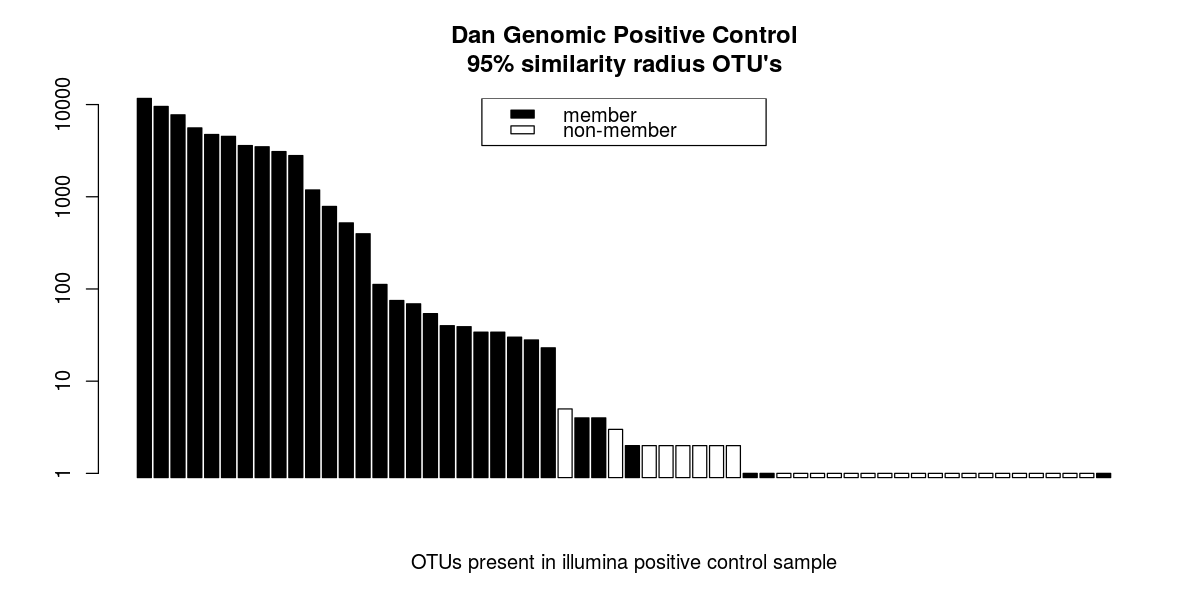

In [13]:
options(repr.plot.width = 10, repr.plot.height = 5)
barplot(dangen95bar$dangen95, names.arg=NULL, col = dangen95bar$member,
        log="y", main="Dan Genomic Positive Control\n95% similarity radius OTU's",
        xlab='OTUs present in illumina positive control sample')
        legend("top", legend=c('member','non-member'), fill=c(1,0))

Log transformed. OTUs with no match to our sanger sequences are colored white. Notice that most of the rare OTUs are not members of our original mock community. They are presumably contaminants or the results of tag-switching.

How many of these MCs have been split?

In [14]:
dtab <- table(dangen95bar$MC)
dtab <- dtab[-1] #exclude non-members
dtab


 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 22 23 24 
 4  1  1  1  1  1  1  5  1  1  1  1  2  1  1  2  1  1  1  1  1  1 

This table shows us that MC1,8,13,16 were split up by our bioinformatics. Let's visualize this, and compare to our other radius. For the plotter, get a matrix, each column representing our sanger-sequence sample numbers, and each row our otus in the illumina sample that matched to these sanger-sequences (MC#'s). 

In [15]:
stackmat <- matrix(nrow=max(dtab), ncol=24)
stackmat[] <- 0
stackmatnames <- paste("MC", 1:24, sep='')
colnames(stackmat) <- stackmatnames

for (i in 1:24){
        bb <- dangen95bar[dangen95bar$MC == i,, drop=FALSE]
        for (j in 1:nrow(bb)){stackmat[j,i] <- bb$dangen95[j]}
    }

In [16]:
stackmat <- stackmat[,-21] ## no MC21, wasn't put into MC mix
## sort by read abundances:
stackmat <- stackmat[,order(colSums(stackmat), decreasing = TRUE)]
stackmat

MC10  MC1  MC8  MC14 MC22 MC20 MC13 MC24 MC12 MC15 ⋯ MC5 MC7 MC6 MC11 MC3
[1,] 11662 9537 7742 5581 4737 4521 3593 3484 3090 2800 ⋯ 397 112 75  69   54 
[2,]     0   39   40    0    0    0    1    0    0    0 ⋯   0   0  0   0    0 
[3,]     0   34   34    0    0    0    0    0    0    0 ⋯   0   0  0   0    0 
[4,]     0    1   28    0    0    0    0    0    0    0 ⋯   0   0  0   0    0 
[5,]     0    0    2    0    0    0    0    0    0    0 ⋯   0   0  0   0    0 
     MC2 MC23 MC4 MC18 MC17
[1,] 30  23   4   4    NA  
[2,]  0   0   0   0     0  
[3,]  0   0   0   0     0  
[4,]  0   0   0   0     0  
[5,]  0   0   0   0     0

Now use this to plot our read abundances, to look at splitting of OTUs at this radius:

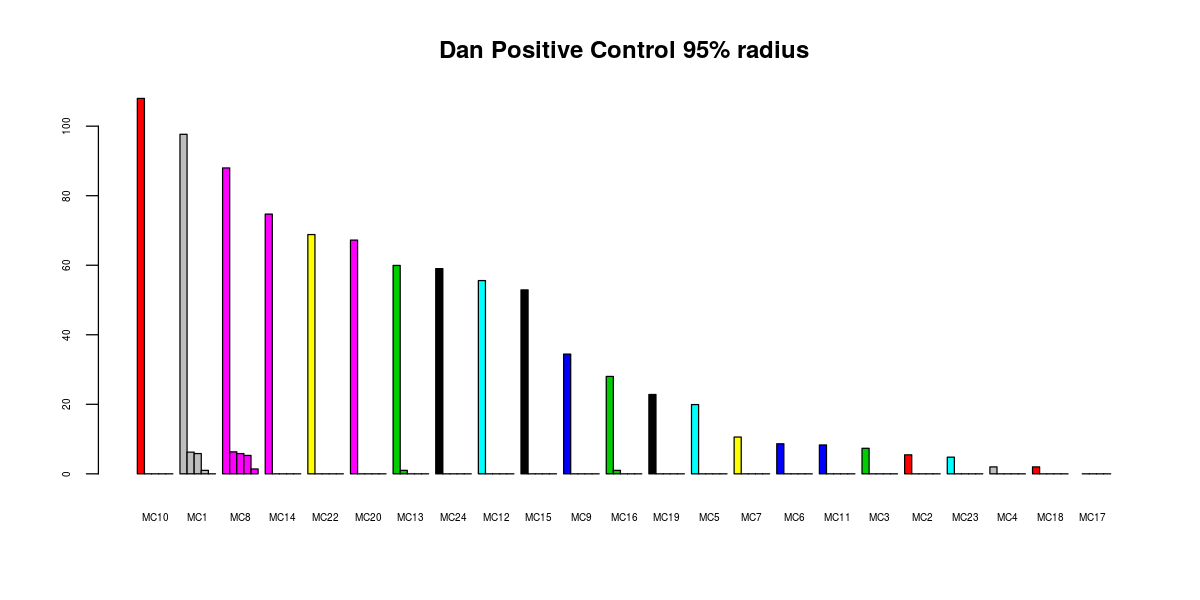

In [17]:
## make our colors from a palette. Randomize for better separation
bcols <- rep(sample(1:ncol(stackmat), replace=FALSE, size=23), each=nrow(stackmat))

par(cex.axis=.5)
## we can see our lower abundances better with sqrt:
barplot(sqrt(stackmat), beside = TRUE, col = bcols, main="Dan Positive Control 95% radius") 
par(mfrow=c(1,1))

Square root transformed axis, so abundance differences are quite large. MC1 is *Phaeocryptopus gaeumannii* and MC8 is a *Ramularia* sp.

<a id='iPos'><h4>ITS-only positive control</h4></a>

As a second positive control, we amplified the full ITS region of each our cultures from our mock community, then introduced equal concentrations of ITS PCR product into a single sample and put it in with the rest of the study. As per our genomic positive contol...

In [3]:
aa95 <- subset_samples(biom95, sample_names(biom95) == 'PosI')
danITSreads <- taxa_sums(aa95)[taxa_sums(aa95) > 0]
danITSreads <- sort(danITSreads, decreasing = TRUE)
sink('danITSreads.txt') ## read out these OTUs so we can use them in python env
names(danITSreads)
sink()

[1] "OTU256:Dc-X"      "OTU119:Dc-PosG"   "OTU106:Dc-PosG"   "OTU386:Dc-PosG"  
 [5] "OTU306:Dc-PosG"   "OTU264:Dc-PosG"   "OTU407:Dc-PosG"   "OTU191:Dc-PosG"  
 [9] "OTU270:Dc-PosG"   "OTU271:Dc-PosG"   "OTU220:Dc-PosG"   "OTU258:Dc-PosG"  
[13] "OTU526:Dc-PosG"   "OTU235:Dc-PosG"   "OTU560:Dc-PosG"   "OTU164:Dc-PosG"  
[17] "OTU608:Dc-PosG"   "OTU733:Dc-PosG"   "OTU358:Dc-PosG"   "OTU826:Dc-PosG"  
[21] "OTU1153:Dc-PosI"  "OTU4210:Dc-PosG"  "OTU3674:Dc-PosG"  "OTU12510:PosG"   
[25] "OTU3183:Dc-PosG"  "OTU3723:Dc-PosG"  "OTU4453:Dc-PosG"  "OTU10694:Dc-PosI"
[29] "OTU77:1w"         "OTU298:2w"        "OTU87:17w"        "OTU12521:Dc-PosG"
[33] "OTU8401:Dc-PosG"  "OTU12516:PosI"    "OTU1183:36w"      "OTU98:2w"        
[37] "OTU41:1w"         "OTU249:1w"        "OTU410:37w"       "OTU84:38w"       
[41] "OTU1520:30w"      "OTU8984:Dc-PosG"  "OTU8986:Dc-PosG"  "OTU7914:Dc-PosG" 
[45] "OTU9035:Dc-PosG"  "OTU10988:PosG"    "OTU9833:Dc-PosI"  "OTU186:1w"       
[49] "OTU471:5w"        "OTU192:1w"        "OTU28:2w"         "OTU1216:1w"      
[53] "OTU958:19w"       "OTU338:1w"        "OTU1292:32w"      "OTU18:9w"        
[57] "OTU6703:17w"      "OTU2954:1w"       "OTU161:2w"        "OTU387:2w"       
[61] "OTU2446:2w"       "OTU1279:15w"      "OTU2202:3w"       "OTU5187:68w"     
[65] "OTU250:4w"        "OTU1599:9w"       "OTU1973:131w"     "OTU3711:17w"     
[69] "OTU1612:18w"      "OTU6688:19w"      "OTU281:109w"      "OTU210:27w"      
[73] "OTU2860:70w"      "OTU839:57w"       "OTU2567:130w"     "OTU12503:PosG"

In [2]:
cat danITS_makeMCseq.py

mcseq=("OTU256:Dc-X","OTU119:Dc-PosG","OTU106:Dc-PosG","OTU386:Dc-PosG",
"OTU306:Dc-PosG","OTU264:Dc-PosG","OTU407:Dc-PosG","OTU191:Dc-PosG",
"OTU270:Dc-PosG","OTU271:Dc-PosG","OTU220:Dc-PosG","OTU258:Dc-PosG",
"OTU526:Dc-PosG","OTU235:Dc-PosG","OTU560:Dc-PosG","OTU164:Dc-PosG",
"OTU608:Dc-PosG","OTU733:Dc-PosG","OTU358:Dc-PosG","OTU826:Dc-PosG",
"OTU1153:Dc-PosI","OTU4210:Dc-PosG","OTU3674:Dc-PosG","OTU12510:PosG",
"OTU3183:Dc-PosG","OTU3723:Dc-PosG","OTU4453:Dc-PosG","OTU10694:Dc-PosI"
"OTU77:1w","OTU298:2w","OTU87:17w","OTU12521:Dc-PosG"
"OTU8401:Dc-PosG","OTU12516:PosI","OTU1183:36w","OTU98:2w",
"OTU41:1w","OTU249:1w","OTU410:37w","OTU84:38w",
"OTU1520:30w","OTU8984:Dc-PosG","OTU8986:Dc-PosG","OTU7914:Dc-PosG",
"OTU9035:Dc-PosG","OTU10988:PosG","OTU9833:Dc-PosI","OTU186:1w",
"OTU471:5w","OTU192:1w","OTU28:2w","OTU1216:1w",
"OTU958:19w","OTU338:1w","OTU1292:32w","OTU18:9w",
"OTU6703:17w","OTU2954:1w","OTU161:2w","OTU387:2w",
"OTU2446:2w","OTU1279:15w","OTU2202:3w","OTU5187:68w",
"OT

In [3]:
python3 danITS_makeMCseq.py

In [4]:
sed -i '/^>/ s/;size=.*//' seqs_danITS95.fasta 

blastn -query seqs_danITS95.fasta -db mcsanger.fasta -out mcblast_danITS95.txt -num_descriptions 3 -num_alignments 3
blastn -query seqs_danITS95.fasta -db mcsanger.fasta -out mcblast_danITS95.csv -outfmt 10 -max_target_seqs 1

sed '1 i\qseqid,sseqid,pident,length,mismatch,gapopen,qstart,qend,sstart,send,evalue,bitscore' mcblast_danITS95.csv -i
sed 's/_ITS[1,4],/,/g' mcblast_danITS95.csv -i
sed 's/Sample//g' mcblast_danITS95.csv -i

Back to R...

In [3]:
blast <- read.csv("mcblast_danITS95.csv", stringsAsFactors=FALSE)
blast

qseqid          sseqid pident length mismatch gapopen qstart qend sstart
1  OTU256:Dc-X      6     100.00 184     0       0        1     184  535   
2  OTU119:Dc-PosG   1      99.31 144     1       0        1     144  434   
3  OTU106:Dc-PosG  10     100.00 174     0       0        1     174  482   
4  OTU386:Dc-PosG  19     100.00 175     0       0        1     175  513   
5  OTU306:Dc-PosG   9     100.00 176     0       0        1     176  504   
6  OTU264:Dc-PosG  16     100.00 180     0       0        1     180  502   
7  OTU407:Dc-PosG   7     100.00 193     0       0        1     193  524   
8  OTU191:Dc-PosG  14     100.00 197     0       0        1     197  566   
9  OTU270:Dc-PosG  12     100.00 178     0       0        1     178  501   
10 OTU271:Dc-PosG  24     100.00 209     0       0        1     209  537   
11 OTU220:Dc-PosG  22     100.00 168     0       0        1     168  512   
12 OTU258:Dc-PosG  13     100.00 180     0       0        1     180  492   
13 OTU526:Dc-PosG   5     100.00 232     0       0        1     232  562   
14 OTU235:Dc-PosG  20     100.00 217     0       0        1     217  605   
15 OTU560:Dc-PosG   4     100.00 180     0       0        1     180  485   
16 OTU164:Dc-PosG   8     100.00 143     0       0        1     143  451   
17 OTU608:Dc-PosG  11     100.00 174     0       0        1     174  487   
18 OTU733:Dc-PosG  23     100.00 208     0       0        1     208  528   
19 OTU358:Dc-PosG  15     100.00 241     0       0        1     241  553   
20 OTU826:Dc-PosG   3     100.00 157     0       0        1     157  555   
21 OTU1153:Dc-PosI 18     100.00 361     0       0        1     361  761   
22 OTU4210:Dc-PosG  8      96.00 125     5       0       19     143  433   
23 OTU3674:Dc-PosG  1      95.24 126     6       0       19     144  416   
24 OTU12510:PosG    8      95.62 137     4       2        1     135  451   
25 OTU3183:Dc-PosG  8      94.89 137     5       2        1     135  451   
26 OTU3723:Dc-PosG  1      95.00 140     5       2        1     140  434   
27 OTU4453:Dc-PosG  2     100.00 143     0       0        1     143  463   
28 OTU12516:PosI    4      96.10 154     4       2       18     170  458   
29 OTU84:38w        9     100.00  31     0       0       27      57  530   
30 OTU8986:Dc-PosG 13      99.39 163     1       0       15     177  475   
31 OTU10988:PosG    8     100.00 118     0       0       19     136  426   
32 OTU2446:2w      19      79.88 169    22       7       12     174  501   
33 OTU1599:9w       1      90.22  92     8       1       37     128  459   
34 OTU6688:19w     11      89.22 167    15       3        3     167  485   
35 OTU12503:PosG   16      95.43 175     2       4        8     181  492   
   send evalue bitscore
1  352   1e-96 340.0   
2  291   7e-73 261.0   
3  309   4e-91 322.0   
4  339   1e-91 324.0   
5  329   3e-92 326.0   
6  323   2e-94 333.0   
7  332  1e-101 357.0   
8  370  7e-104 364.0   
9  324   2e-93 329.0   
10 329  2e-110 387.0   
11 345   8e-88 311.0   
12 313   2e-94 333.0   
13 331  3e-123 429.0   
14 389  6e-115 401.0   
15 306   2e-94 333.0   
16 309   5e-74 265.0   
17 314   4e-91 322.0   
18 321  6e-110 385.0   
19 313  3e-128 446.0   
20 399   9e-82 291.0   
21 401   0e+00 667.0   
22 309   1e-55 204.0   
23 291   1e-54 200.0   
24 315   4e-60 219.0   
25 315   2e-58 213.0   
26 297   4e-60 219.0   
27 321   5e-74 265.0   
28 306   2e-69 250.0   
29 500   1e-11  58.4   
30 313   2e-83 296.0   
31 309   4e-60 219.0   
32 339   2e-28 113.0   
33 369   6e-30 119.0   
34 320   4e-56 206.0   
35 323   1e-76 274.0

In [4]:
goodblast <- blast[blast$length > 100,]

Check MC presence/absence...

In [5]:
1:24 %in% goodblast$sseqid

[1]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
[13]  TRUE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE FALSE  TRUE  TRUE  TRUE

In [6]:
sort(unique(goodblast$sseqid)); length(unique(goodblast$sseqid))

[1]  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 22 23 24

[1] 22

Still missing MC17.

In [12]:
member <- names(danITS95) %in% goodblast$qseqid ## danITS95 created above 
MC <- vector(length = length(danITS95))
danITS95bar <- data.frame(cbind(danITS95, member, MC))
for (i in 1:nrow(danITS95bar)){
        if (rownames(danITS95bar)[i] %in% goodblast$qseqid) {
                search <- grep(rownames(danITS95bar)[i], goodblast$qseqid)
                danITS95bar$MC[i] <- goodblast$sseqid[search]
        }
    }

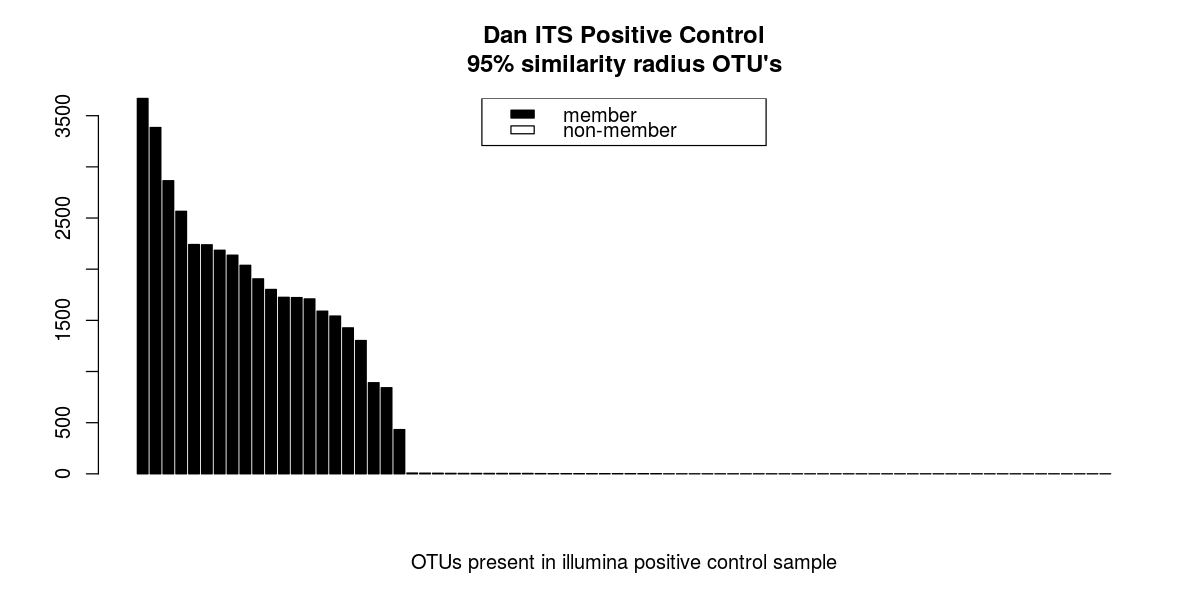

In [16]:
options(repr.plot.width = 10, repr.plot.height = 5)
barplot(danITS95bar$danITS95, names.arg=NULL, col = danITS95bar$member,
        main="Dan ITS Positive Control\n95% similarity radius OTU's",
        xlab='OTUs present in illumina positive control sample')
        legend("top", legend=c('member','non-member'), fill=c(1,0))

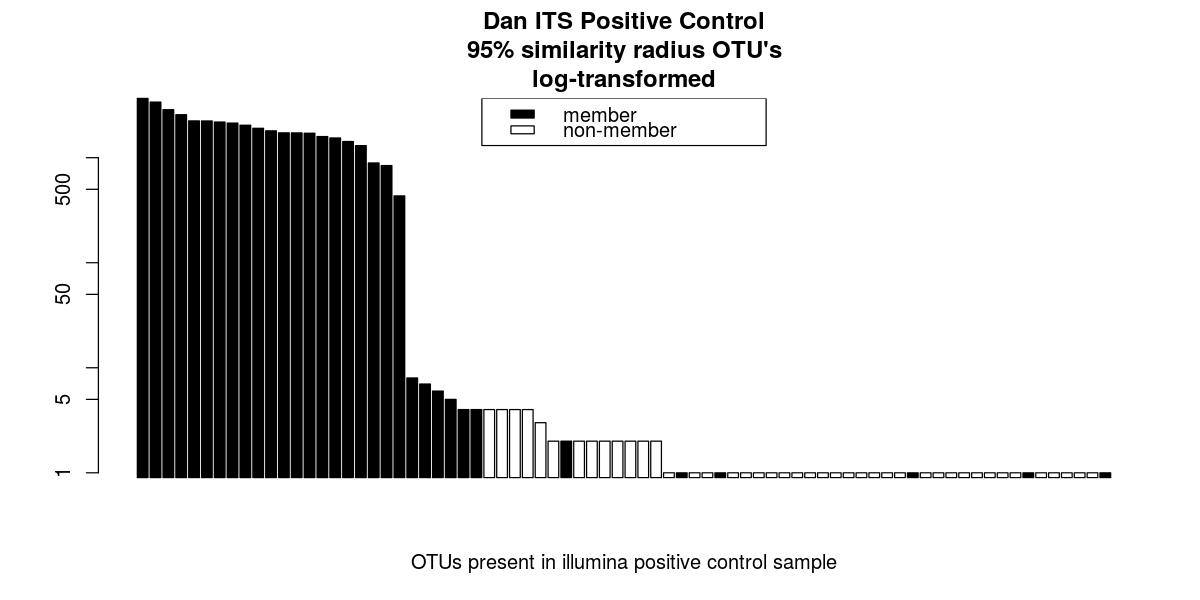

In [17]:
options(repr.plot.width = 10, repr.plot.height = 5)
barplot(danITS95bar$danITS95, names.arg=NULL, col = danITS95bar$member,
        log="y", main="Dan ITS Positive Control\n95% similarity radius OTU's\nlog-transformed",
        xlab='OTUs present in illumina positive control sample')
        legend("top", legend=c('member','non-member'), fill=c(1,0))

Mostly intended members of the mock community were present... let's look at OTU splitting:

In [19]:
dtab <- table(danITS95bar$MC)
dtab <- dtab[-1] #exclude non-members
dtab


 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 18 19 20 22 23 24 
 3  1  1  2  1  1  1  5  1  1  2  1  2  1  1  2  1  2  1  1  1  1 

Huh, seems like even more splitting in the ITS...

In [20]:
stackmat <- matrix(nrow=max(dtab), ncol=24)
stackmat[] <- 0
stackmatnames <- paste("MC", 1:24, sep='')
colnames(stackmat) <- stackmatnames

for (i in 1:24){
        bb <- danITS95bar[danITS95bar$MC == i,, drop=FALSE]
        for (j in 1:nrow(bb)){stackmat[j,i] <- bb$danITS95[j]}
    }

In [21]:
stackmat <- stackmat[,-21] ## no MC21, wasn't put into MC mix
## sort by read abundances:
stackmat <- stackmat[,order(colSums(stackmat), decreasing = TRUE)]
stackmat

MC6  MC1  MC10 MC19 MC9  MC16 MC7  MC14 MC12 MC24 ⋯ MC20 MC4  MC8  MC11
[1,] 3669 3385 2865 2566 2241 2239 2185 2137 2038 1906 ⋯ 1710 1590 1542 1427
[2,]    0    7    0    1    0    1    0    0    0    0 ⋯    0    2    8    1
[3,]    0    4    0    0    0    0    0    0    0    0 ⋯    0    0    6    0
[4,]    0    0    0    0    0    0    0    0    0    0 ⋯    0    0    5    0
[5,]    0    0    0    0    0    0    0    0    0    0 ⋯    0    0    1    0
     MC23 MC15 MC3 MC18 MC2 MC17
[1,] 1303 891  842 433  4   NA  
[2,]    0   0    0   0  0    0  
[3,]    0   0    0   0  0    0  
[4,]    0   0    0   0  0    0  
[5,]    0   0    0   0  0    0

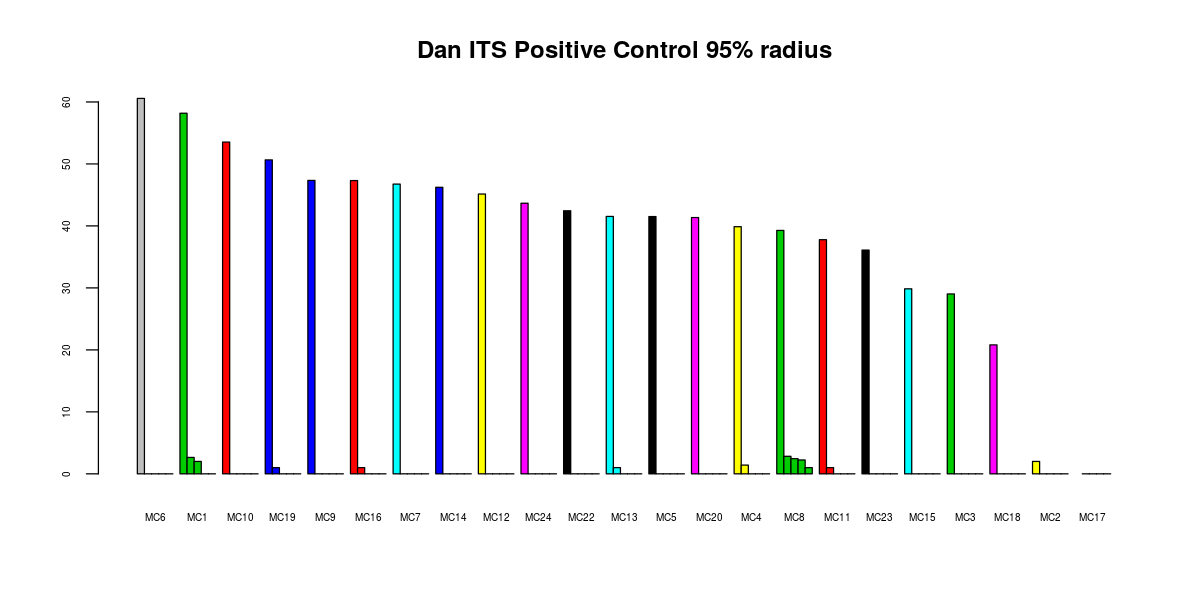

In [22]:
## make our colors from a palette. Randomize for better separation
bcols <- rep(sample(1:ncol(stackmat), replace=FALSE, size=23), each=nrow(stackmat))

par(cex.axis=.5)
## we can see our lower abundances better with sqrt:
barplot(sqrt(stackmat), beside = TRUE, col = bcols, main="Dan ITS Positive Control 95% radius") 
par(mfrow=c(1,1))

Same basic story, as far as OTU splitting.

<a id='cleanup'><h3>Cleanup using controls</h3></a>

We'll use our positive and negative controls to get estimates of rates of contamination and tag-switching, and institute cutoffs to reduce error from these sources. This is our pipeline for getting our reads ready to ask ecological questions. 

<a id='lowSamp'><h4>Removing low abundance samples:</h4></a>

In [24]:
sample_sums(biom95)[sample_sums(biom95) < 2000]

106leaf 112leafA 113leafA 113leafB 126leafB   18leaf   74leaf   86leaf 
       8       17       78       24       20     1648      341     1769 
  91leaf      Neg 
      12     1501

Looks like some of the leaf sites will be lost... Controls are low also, but we need to get rid of these anyway later.

In [37]:
biom95eco <- subset_samples(biom95, SorC=='Sample')
biom95eco_hiread <- prune_samples(sample_sums(biom95eco)>=2000, biom95eco)

In [38]:
biom95eco_hiread

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11588 taxa and 214 samples ]
sample_data() Sample Data:       [ 214 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 11588 taxa by 7 taxonomic ranks ]

<a id='minAbund'><h4>Minimum abundances of observations and contaminant removal</h4></a>

I define an observation as the presence of a OTU within a sample, regardless of read abundance. But to be acknowledged as a "real" observation, it is reasonable to ask that an observation meet a certain abundance, or we can throw it out. To address spurious OTUs that result from OTU-splitting, we can define this abundance threshold by looking a little more closely at our genomic positive and negative controls:

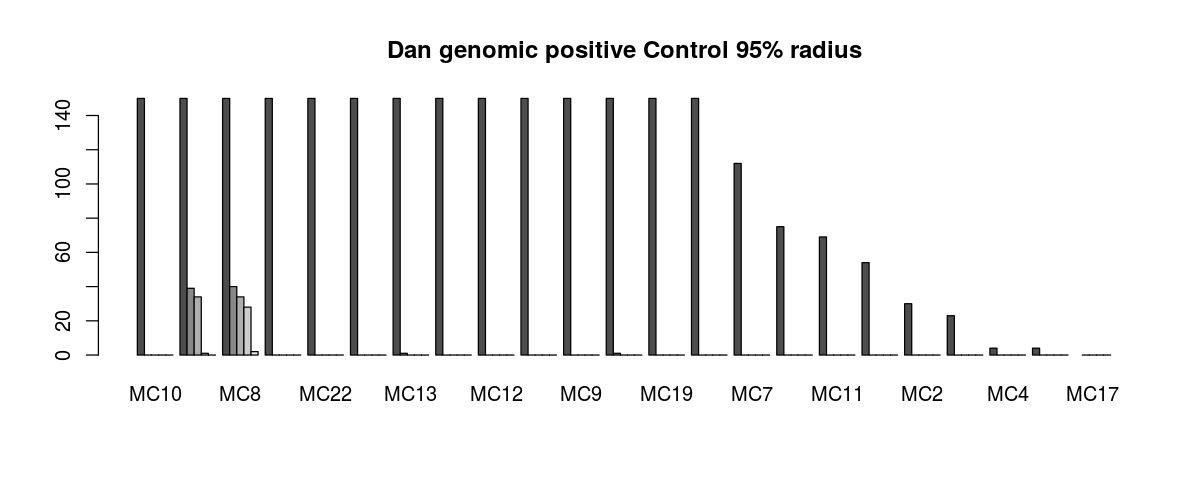

In [33]:
smShort <- stackmat ## rerun genomic control code above to get this. 
smShort[smShort > 150] <- 150
#save(smShort, file='posGtrun.rda')
barplot(smShort, beside = TRUE, main="Dan genomic positive Control 95% radius") 
par(mfrow=c(1,1))

In [32]:
svg(file='outsplitting_genomic.svg')
smShort <- stackmat ## rerun genomic control code above to get this. 
smShort[smShort > 150] <- 150
barplot(smShort, beside = TRUE, main="Dan genomic positive Control 95% radius") 
par(mfrow=c(1,1))
dev.off()

png 
  2

So to control for OTU splitting, looks like, in my positive control, most OTUs that are a result of splitting in the genomic positive control are at ~40 reads. For tag switching, if we look at the tagswitched OTUs in our negative control, we see that in our negative control that tag switching events seem to be ~100 reads or lower ([graph here](#NegGraph)):

In [102]:
Neg95bar[Neg95bar$member==TRUE,]

reads member MC Genus         
OTU306:Dc-PosG 96    TRUE    9 NoID          
OTU386:Dc-PosG 88    TRUE   19 Nemania       
OTU164:Dc-PosG 51    TRUE    8 Mycosphaerella
OTU560:Dc-PosG 39    TRUE    4 Diaporthe     
OTU256:Dc-X    35    TRUE    6 Trametes      
OTU119:Dc-PosG  1    TRUE    1 Phaeocryptopus
OTU220:Dc-PosG  1    TRUE   22 NoID          
OTU235:Dc-PosG  1    TRUE   20 Psilocybe     
OTU264:Dc-PosG  1    TRUE   16 Xylaria       
               Species                             
OTU306:Dc-PosG NoID                                
OTU386:Dc-PosG Nemania_aenea_SH217392.07FU         
OTU164:Dc-PosG Mycosphaerella_rubella_SH206848.07FU
OTU560:Dc-PosG Diaporthe_cynaroidis_SH090428.07FU  
OTU256:Dc-X    NoID                                
OTU119:Dc-PosG NoID                                
OTU220:Dc-PosG NoID                                
OTU235:Dc-PosG Psilocybe_cyanescens_SH262625.07FU  
OTU264:Dc-PosG NoID

But I don't want to cut off observations at ~100 reads, we would lose a lot of information. This would begin to be as intellectually dishonest as doing no removal at all, erring too far in excluding real information from our results. As per our previous analysis, it seems about require a minimum threshold of 60 reads per observation in our wood samples. This eliminates all the observed events of OTU splitting, and 7 out of 9 tag switch events in our negative control. It also keeps us in line with our previous analysis. This threshold of 60 reads does eleminate the 7 lowest-abundance members of our 22 detected members of the mock community, indicating a large loss of information. Always a trade-off. 

As per our previous analysis, we'll scale up the number of leaf reads to be proportionate. To quote myself:

>We have no positive controls from the leaf data, since Roo sequenced those in a separate study, so for now we'll assume that these samples have a +/- similar level of error from tag-switching. To figure the level of subtraction for tag-switching and splinter OTUs in his study, we'll subtract the same proportion of reads/library as the wood. Relative to the total number of reads (4,521,655) in the wood library, this is a reduction in each OTU/sample observation of 60/4,521,655 = 0.000013269 times the library size. If we multiply the size of the leaf library by this, we get (0.000013269)x(10,751,750 reads) = 142.6972, or 143 reads. 

We'll round to 140 reads.

In addition, this is a good time to remove the contaminants we find in our controls, while the leaf and wood abundances are being considered separately. We're going to remove all of our mock community members from wherever they appear in the study in a downstream step anyway (see below), so we can treat our positive controls just like negatives here, removing all that we find.

Split the OTU abundance table into leaf and wood libraries:

In [204]:
leafeco <- subset_samples(biom95eco_hiread, Library=='L')
woodeco <- subset_samples(biom95eco_hiread, Library=='W')

Wood reads:

In [205]:
## what are the maximums from our controls?:

woodControls <- prune_samples(sample_names(biom95)=='Neg' |
                              sample_names(biom95)=='PosG' |
                              sample_names(biom95)=='PosI',
                              biom95)

## get maximums
woodContam <- apply(otu_table(woodControls), 1, max)

## how many control OTUs are there?
sum(woodContam>0)

[1] 122

In [218]:
sort(woodContam[woodContam > 0])

OTU8986:Dc-PosG  OTU7914:Dc-PosG        OTU186:1w        OTU471:5w 
               1                1                1                1 
        OTU64:1w        OTU192:1w        OTU409:4w        OTU152:1w 
               1                1                1                1 
        OTU28:2w       OTU1216:1w       OTU958:19w        OTU437:1w 
               1                1                1                1 
       OTU338:1w      OTU1292:32w      OTU5738:17w       OTU414:13w 
               1                1                1                1 
     OTU6703:17w        OTU655:1w       OTU2954:1w     OTU1075:100w 
               1                1                1                1 
       OTU161:2w        OTU391:2w       OTU2029:2w        OTU387:2w 
               1                1                1                1 
      OTU2446:2w      OTU1279:15w       OTU2202:3w      OTU5187:68w 
               1                1                1                1 
       OTU250:4w       OTU1524:3w     OTU7955:106w     OTU1973:131w 
               1                1                1                1 
     OTU5111:14w      OTU1124:36w      OTU7329:38w       OTU1466:9w 
               1                1                1                1 
     OTU925:133w      OTU1941:17w      OTU3711:17w      OTU1612:18w 
               1                1                1                1 
     OTU6688:19w      OTU1496:23w       OTU588:32w      OTU1888:25w 
               1                1                1                1 
     OTU281:109w       OTU210:27w      OTU2860:70w       OTU428:45w 
               1                1                1                1 
      OTU839:57w     OTU2567:130w      OTU972:130w     OTU1516:133w 
               1                1                1                1 
    OTU1866:133w    OTU12503:PosG  OTU8401:Dc-PosG    OTU10988:PosG 
               1                1                2                2 
   OTU12516:PosI  OTU9833:Dc-PosI      OTU1183:36w       OTU248:20w 
               2                2                2                2 
        OTU98:2w         OTU41:1w        OTU249:1w         OTU18:9w 
               2                2                2                2 
       OTU610:1w        OTU257:3w       OTU410:37w      OTU1520:30w 
               2                2                2                2 
    OTU2115:131w    OTU12502:PosG  OTU8984:Dc-PosG OTU12521:Dc-PosG 
               2                2                3                3 
       OTU46:60w OTU10694:Dc-PosI         OTU77:1w        OTU298:2w 
               3                4                4                4 
      OTU1599:9w       OTU2831:5w        OTU87:17w  OTU9035:Dc-PosG 
               4                4                4                5 
       OTU84:38w        OTU417:1w      OTU6852:Neg  OTU4210:Dc-PosG 
              12               15               20               28 
      OTU1432:2w     OTU1549:104w  OTU4453:Dc-PosG  OTU3674:Dc-PosG 
              28               28               30               34 
   OTU12510:PosG      OTU1444:49w  OTU3723:Dc-PosG  OTU3183:Dc-PosG 
              34               38               39               40 
     OTU2003:Neg      OTU1332:11w      OTU762:Dc-X       OTU1214:9w 
              42               44               53               53 
     OTU1747:11w        OTU891:1w   OTU187:Dc-PosG        OTU315:4w 
              53               58               85              162 
 OTU1153:Dc-PosI      OTU167:Dc-X   OTU826:Dc-PosG   OTU733:Dc-PosG 
             433              469              842             1303 
  OTU608:Dc-PosG   OTU560:Dc-PosG   OTU526:Dc-PosG   OTU407:Dc-PosG 
            1427             1590             1723             2185 
  OTU264:Dc-PosG   OTU306:Dc-PosG   OTU386:Dc-PosG   OTU358:Dc-PosG 
            2239             2241             2566             2800 
  OTU270:Dc-PosG   OTU271:Dc-PosG   OTU258:Dc-PosG      OTU256:Dc-X 
            3090             3484             3593             3669 

In [206]:
## just checking...
length(woodContam); all(names(woodContam) == rownames(otu_table(woodeco)))

[1] 11588

[1] TRUE

In [207]:
woodCotu <- otu_table(woodeco) - woodContam ## subtract contaminants
woodCotu <- woodCotu-60 ## subtract minimum threshold
woodCotu[woodCotu < 0] <- 0 ## bring negatives up to zero
woodeco.contam.rem <- woodeco ## make a copy, just in case
otu_table(woodeco.contam.rem) <- woodCotu ## insert the corrected OTU

Now leaf reads, subtract contaminants and minimum threshold:

In [208]:
## what are the maximums from our controls?:

leafControls <- prune_samples(sample_names(biom95)=='leafNCA' |
                              sample_names(biom95)=='leafNCB',
                              biom95)

## get maximums
leafContam <- apply(otu_table(leafControls), 1, max)

## how many control OTUs are there?
sum(leafContam>0)

[1] 89

In [209]:
## just checking...
length(leafContam); all(names(leafContam) == rownames(otu_table(leafeco)))

[1] 11588

[1] TRUE

In [210]:
leafCotu <- otu_table(leafeco) - leafContam ## subtract contaminants
leafCotu <- leafCotu-140 ## subtract minimum threshold
leafCotu[leafCotu < 0] <- 0 ## bring negatives up to zero
leafeco.contam.rem <- leafeco ## make a copy, just in case
otu_table(leafeco.contam.rem) <- leafCotu ## insert the corrected OTU

Okay, now reunite the leaf and wood reads:

In [211]:
## does "merging" work here to bring these back together?
biom95.mend <- merge_phyloseq(woodeco.contam.rem,leafeco.contam.rem)

In [253]:
#save(biom95.mend, file="biom95.mend.rda")

Run some checks:

In [243]:
## check to make sure structure is intact
dim(otu_table(biom95eco_hiread))
dim(otu_table(biom95.mend))

[1] 11588   214

[1] 11588   214

In [244]:
## row and column order changed after merging?
all(rownames(otu_table(biom95.mend)) %in% rownames(otu_table(biom95eco_hiread)))
all(colnames(otu_table(biom95.mend)) %in% colnames(otu_table(biom95eco_hiread)))

all(rownames(otu_table(biom95eco_hiread)) %in%  rownames(otu_table(biom95.mend)))
all(colnames(otu_table(biom95eco_hiread) %in% colnames(otu_table(biom95.mend))))

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

In [245]:
## dup tables
aa <- otu_table(biom95eco_hiread); bb <- otu_table(biom95.mend)
## reorder columns so they match, for spot checking the matrices
eco_reord <- aa[,order(colnames(aa))]; mend_reord <- bb[,order(colnames(bb))]

In [246]:
## spot check
eco_reord[1:5,1:5]
mend_reord[1:5,1:5] ## should be lower, more zeroes but no negs

100leaf 100w 101leaf 101w 102leaf
OTU19:100leaf  81511   0     178    0      0    
OTU108:100leaf 26184   0       0    0      0    
OTU1:100leaf    2735   0    6795    0    586    
OTU202:100leaf  3214   0       0    0      0    
OTU426:100leaf  5943   0       0    0      0

100leaf 100w 101leaf 101w 102leaf
OTU19:100leaf  81371   0      38    0      0    
OTU108:100leaf 26044   0       0    0      0    
OTU1:100leaf    2594   0    6654    0    445    
OTU202:100leaf  3074   0       0    0      0    
OTU426:100leaf  5803   0       0    0      0

In [110]:
## spot check
eco_reord[1:5,1:5]
mend_reord[1:5,1:5] ## should be lower, more zeroes but no negs

100leaf 100w 101leaf 101w 102leaf
OTU19:100leaf  81511   0     178    0      0    
OTU108:100leaf 26184   0       0    0      0    
OTU1:100leaf    2735   0    6795    0    586    
OTU202:100leaf  3214   0       0    0      0    
OTU426:100leaf  5943   0       0    0      0

100leaf 100w 101leaf 101w 102leaf
OTU19:100leaf  81371   0      38    0      0    
OTU108:100leaf 26044   0       0    0      0    
OTU1:100leaf    2595   0    6655    0    446    
OTU202:100leaf  3074   0       0    0      0    
OTU426:100leaf  5803   0       0    0      0

In [111]:
## more spot checks
eco_reord[5140:5145,172:177]
mend_reord[5140:5145,172:177]

76w  77leaf 78leaf 79leaf 79w 7leaf
OTU1101:Dc-Neg    0 0      0      0       0  0    
OTU1517:Dc-Neg    0 0      0      0       0  0    
OTU351:Dc-Neg  6945 0      0      0       0  0    
OTU1562:Dc-Neg    0 0      0      0       0  0    
OTU1227:Dc-Neg    0 0      0      0      11  0    
OTU1949:Dc-Neg    0 0      0      0       0  0

76w  77leaf 78leaf 79leaf 79w 7leaf
OTU1101:Dc-Neg    0 0      0      0      0   0    
OTU1517:Dc-Neg    0 0      0      0      0   0    
OTU351:Dc-Neg  6885 0      0      0      0   0    
OTU1562:Dc-Neg    0 0      0      0      0   0    
OTU1227:Dc-Neg    0 0      0      0      0   0    
OTU1949:Dc-Neg    0 0      0      0      0   0

In [82]:
## more spot checks
eco_reord[5140:5145,172:177]
mend_reord[5140:5145,172:177]

76w  77leaf 78leaf 79leaf 79w 7leaf
OTU1101:Dc-Neg    0 0      0      0       0  0    
OTU1517:Dc-Neg    0 0      0      0       0  0    
OTU351:Dc-Neg  6945 0      0      0       0  0    
OTU1562:Dc-Neg    0 0      0      0       0  0    
OTU1227:Dc-Neg    0 0      0      0      11  0    
OTU1949:Dc-Neg    0 0      0      0       0  0

76w  77leaf 78leaf 79leaf 79w 7leaf
OTU1101:Dc-Neg    0 0      0      0      0   0    
OTU1517:Dc-Neg    0 0      0      0      0   0    
OTU351:Dc-Neg  6885 0      0      0      0   0    
OTU1562:Dc-Neg    0 0      0      0      0   0    
OTU1227:Dc-Neg    0 0      0      0      0   0    
OTU1949:Dc-Neg    0 0      0      0      0   0

In [80]:
## more spot checks
eco_reord[1140:1150,120:130]
mend_reord[1140:1150,120:130]

49w 4leaf 4w 50leaf 50w 51leaf 52leaf 52w 53leaf 54leaf 55leaf
OTU9024:109leaf  0   0     0      0  0      0   0      0   0        0    0     
OTU10740:109leaf 0   0     0      0  0      0   0      0   0        0    0     
OTU10278:109leaf 0   0     0      0  0      0   0      0   0        0    0     
OTU9776:109leaf  0   0     0      0  0      0   0      0   0        0    0     
OTU2355:109leaf  0   0     0      0  0      0   0      0   0        0    0     
OTU9034:109leaf  0   0     0      0  0      0   0      0   0        0    0     
OTU51:109leaf    0   0     0  13568  0   6203   0      0   0      496    0     
OTU8420:109leaf  0   0     0      0  0      0   0      0   0        0    0     
OTU8927:109leaf  0   0     0      0  0      0   0      0   0        0    0     
OTU11707:109leaf 0   0     0      0  0      0   0      0   0        0    0     
OTU1985:109leaf  0   0     0      0  0      0   0      0   0        0    0

49w 4leaf 4w 50leaf 50w 51leaf 52leaf 52w 53leaf 54leaf 55leaf
OTU9024:109leaf  0   0     0      0  0      0   0      0   0        0    0     
OTU10740:109leaf 0   0     0      0  0      0   0      0   0        0    0     
OTU10278:109leaf 0   0     0      0  0      0   0      0   0        0    0     
OTU9776:109leaf  0   0     0      0  0      0   0      0   0        0    0     
OTU2355:109leaf  0   0     0      0  0      0   0      0   0        0    0     
OTU9034:109leaf  0   0     0      0  0      0   0      0   0        0    0     
OTU51:109leaf    0   0     0  13428  0   6063   0      0   0      356    0     
OTU8420:109leaf  0   0     0      0  0      0   0      0   0        0    0     
OTU8927:109leaf  0   0     0      0  0      0   0      0   0        0    0     
OTU11707:109leaf 0   0     0      0  0      0   0      0   0        0    0     
OTU1985:109leaf  0   0     0      0  0      0   0      0   0        0    0

To check our contaminant removal: wood otus that are contaminants should be 60 + highest abundance found in any of the three wood controls. For instance, OTU315:4w is a contaminant found in our negative control:

In [240]:
otu_table(woodControls)["OTU315:4w",]

Neg PosG PosI
OTU315:4w 162 0    0

This means that after our thresholds and subtraction of negative control abundances we should see a 162+60=222 read loss where ever OTU315:4w is observed in wood samples (or 162+140=302 read loss for leaves):

In [242]:
aa <- t(rbind(eco_reord['OTU315:4w',],mend_reord['OTU315:4w',]))
colnames(aa) <- c('before cleanup', 'after cleanup')
aa[rowSums(aa) > 0,]

before cleanup after cleanup
102w   18              0         
10w     3              0         
11w    16              0         
121w    2              0         
130w   14              0         
14w     1              0         
16w     1              0         
17w     8              0         
18w     1              0         
19w  3612           3390         
20w    76              0         
21w    44              0         
25w    21              0         
26w     3              0         
27w     2              0         
28w     7              0         
29w   131              0         
30w    17              0         
35w    24              0         
3w      8              0         
45w     2              0         
49w   101              0         
4w     16              0         
50w     2              0         
55w  3726           3504         
56w     7              0         
57w    16              0         
5w     48              0         
64w     1              0         
68w    17              0         
73w    11              0         
75w     7              0         
76w     1              0         
89w     7              0         
95w    14              0         
99w    30              0

Looks like the cleanup worked as intended. 

<a id='remMCs'><h3>Remove all mock community OTUs</h3></a>

Unfortunately, it looks like our mock community bled out quite a lot into our other samples. So I can't really trust any OTUs that match to our positive controls, any observations of these OTUs could well be the result of tag switching. To get rid of them, we'll use the same basic method as above when identifying which OTUs were members of the mock community. But this time we'll blast our entire set of OTUs against our list of sanger sequences for the positive control. Any strong hits will be considered as possibly resulting from tag-switching, and will be removed. 

In [1]:
## clean up our cluster names a little
sed '/>OTU/ s/;size=.*//g' otus_95_combo_nolb.fasta > otus_95.fasta

In [2]:
blastn -query otus_95.fasta -db mcsanger.fasta -out mcblast_allOTUs.csv -outfmt 10 -max_target_seqs 1

Read this into R, assign some column names.

In [4]:
## pick the biom tables back up into workspace
load("biom95.mend.rda") 
load('biom95.rda')

In [8]:
blast <- read.csv('mcblast_allOTUs.csv', header=FALSE)
blasthead <- c('qseqid','sseqid','pident','length','mismatch','gapopen','qstart','qend','sstart','send','evalue','bitscore')
colnames(blast) <- blasthead

In [10]:
head(blast); dim(blast)

qseqid                 sseqid        pident length mismatch gapopen qstart
1 OTU3:leafNotChim_102   Sample1_ITS4  87.67  146    16        1       1    
2 OTU10:leafNotChim_100  Sample15_ITS4 86.94  245    19       10       3    
3 OTU16:leafNotChim_100  Sample15_ITS4 86.90  229    16       10      20    
4 OTU20:leafNotChim_108  Sample16_ITS4 88.57   70     5        1      89    
5 OTU21:leafNotChim_112B Sample1_ITS4  85.71  147    14        7       2    
6 OTU33:Dc-X             Sample16_ITS4 95.24   63     3        0       1    
  qend sstart send evalue bitscore
1 146  307    450  4e-45  169.0   
2 239  330    569  3e-73  263.0   
3 240  347    569  1e-67  244.0   
4 155  449    518  6e-19   82.4   
5 144  307    450  5e-39  148.0   
6  63  502    440  2e-24  100.0

[1] 769  12

In [13]:
## keep only strong matches
goodblast <- blast[blast$pident > 95 & blast$length > 100,] 

In [14]:
nrow(blast) 
nrow(goodblast)

[1] 769

[1] 54

769 otus matched somehow to an MC sequence, but only 54 OTUs are strong matches, so these are the ones to get rid of. 

In [15]:
## which of our rownames (= OTU names) are not in this list of strong matches?
pcotus <- !(rownames(otu_table(biom95)) %in% goodblast$qseqid) 
## keep only these:
biom95.mc.rem <- prune_taxa(pcotus, biom95.mend)

In [16]:
#save(biom95.mc.rem, file='biom95.mc.rem.rda')

Check the losses in reads, samples, etc:

In [17]:
biom95; biom95.mc.rem

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11588 taxa and 232 samples ]
sample_data() Sample Data:       [ 232 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 11588 taxa by 7 taxonomic ranks ]

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11553 taxa and 214 samples ]
sample_data() Sample Data:       [ 214 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 11553 taxa by 7 taxonomic ranks ]

In [18]:
sum(sample_sums(biom95))
sum(sample_sums(biom95.mc.rem))

[1] 15442054

[1] 13189412

2,252,642 reads removed by the cleanup from controls. How many observations were lost?

In [19]:
sum(otu_table(biom95) > 0)
sum(otu_table(biom95.mc.rem) > 0)

[1] 51625

[1] 9684

41941 observations removed, ~80% of all observations... that's a lot. 

How many taxa removed entirely from the study?

In [29]:
sum(rowSums(otu_table(biom95)) > 0)

sum(rowSums(otu_table(biom95.mc.rem)) > 0)

[1] 11588

[1] 3330

That's a lot. Oh well. Onward. 

<a id='varstab'><h2>Variance stabilization of reads</h2></a>

<a id='DESeq2'><h3>Apply DESeq2 algorithms</h3></a>

Let's stabilize the variance among our samples using DESeq2. Let's use Roo's old script for doing this, hope it still works after three years...

In [32]:
DESeq_varstab <- function(phyloseq, design) {
# phyloseq = the input phyloseq object that you want to get DESeq transformed counts for
# design_variable = the design for the conversion to the DESeq object. must be in the form "as a function of", for example "~Host_Genus", must be a variable in the phyloseq object
        deseq.vst = NULL
        geo_Means = NULL
        phyloseq.DESeq = NULL
        # Convert to a DESeq object
        deseq = phyloseq_to_deseq2(phyloseq, design)
        # calculate geometric means prior to estimate size factors
        gm_mean = function(x, na.rm=TRUE){
                exp(sum(log(x[x > 0]), na.rm=na.rm) / length(x))
                }
        geo_Means = apply(counts(deseq), 1, gm_mean)
        # Check to see if any columns (samples) don't have any OTUs in them:
        if(sum(colSums(counts(deseq)) == 0) == 0) { # if all samples have taxa, go on
                # Now we step through the size factors, dispersions, and varience stabilization:
                deseq = estimateSizeFactors(deseq, geoMeans = geo_Means)
                deseq = estimateDispersions(deseq) # long step
                deseq.vst = getVarianceStabilizedData(deseq)
                # replace negatives with zeros
                deseq.vst[deseq.vst <0] <- 0
                # add the varience stabilized otu numbers into the dataset:
                otu_table(phyloseq) <- otu_table(deseq.vst, taxa_are_rows = TRUE)
                # create a new object for the varience stabalized set
                phyloseq -> phyloseq.DESeq
                # And, filter any taxa that became 0s all the way across
                phyloseq.DESeq = filter_taxa(phyloseq.DESeq, function(x) sum(x) > 0.1, T)
                # return the new phyloseq object
                return(phyloseq.DESeq)
        } # end of IF loop 
        else {return("Error: your phyloseq object has samples with no taxa present.")}
} # end function


In [33]:
deseq95 <- DESeq_varstab(biom95.mc.rem, ~Library)

converting counts to integer mode
Warning message in DESeqDataSet(se, design = design, ignoreRank):
“some variables in design formula are characters, converting to factors”gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates


In [34]:
#save(deseq95, file='deseq95.rda')

In [35]:
deseq95

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 3327 taxa and 214 samples ]
sample_data() Sample Data:       [ 214 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 3327 taxa by 7 taxonomic ranks ]

In [36]:
biom95.mc.rem

phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 11553 taxa and 214 samples ]
sample_data() Sample Data:       [ 214 samples by 11 sample variables ]
tax_table()   Taxonomy Table:    [ 11553 taxa by 7 taxonomic ranks ]

Looks like a big drop in taxa, but not really. Most of these taxa-rows, were emptied out during our cleanup from the controls. We really only lost 3330 - 3327 = 3 otus. 

<a id='BAvarstab'><h3>Compare pre/post variance-stabilization distibutions</h3></a>


<h4>Overall distributions of reads among leaf/wood samples:</h4>

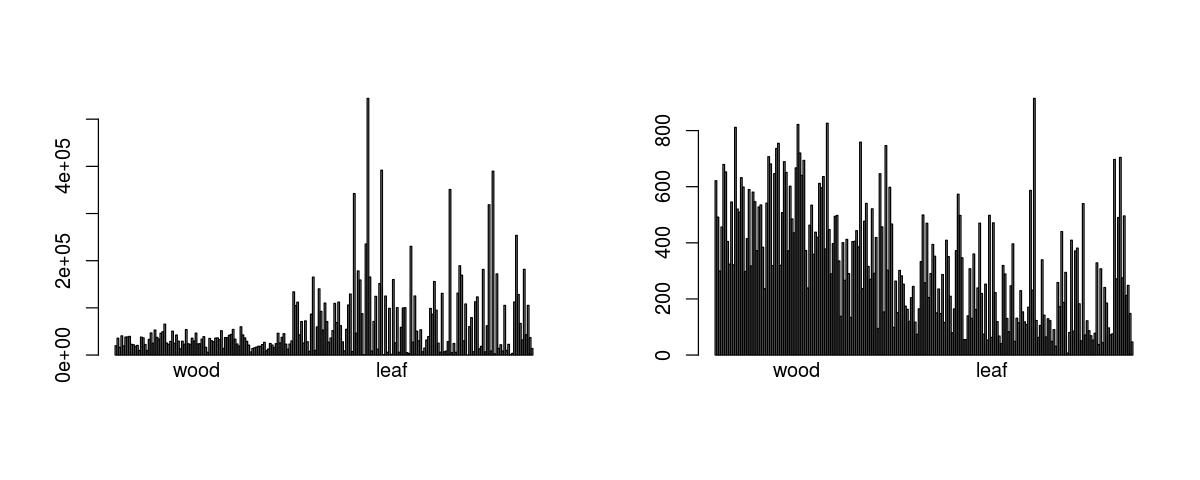

In [38]:
par(mfrow = c(1,2))
options(repr.plot.width = 10, repr.plot.height = 4)

barplot(sample_sums(biom95.mc.rem), axisnames=FALSE)
mtext(text='wood', side = 1, at=50)
mtext(text='leaf', side = 1, at=170)

barplot(sample_sums(deseq95), axisnames=FALSE)
mtext(text='wood', side = 1, at=50)
mtext(text='leaf', side = 1, at=170)

<h4>Positive controls after variance stabilization</h4>

In [72]:
aa <- biom95
#bb <- DESeq_varstab(biom95, ~Library)

aaOTU <- (otu_table(aa)[,'PosG']) ## our control, before
aaOTU <- aaOTU[aaOTU != 0]

bbOTU <- (otu_table(bb)[,'PosG']) ## our control, after
bbOTU <- bbOTU[bbOTU != 0]

rownames(aaOTU) %in% rownames(bbOTU) ## did we lose any?

## tag them for plotting and comparison
lost <- !(rownames(aaOTU) %in% rownames(bbOTU))
aalost <- cbind(aaOTU,lost)
aalost <- aalost[order(aalost[,'PosG'], decreasing = TRUE),]
bbOTU <- bbOTU[order(bbOTU[,'PosG'], decreasing = TRUE),]

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

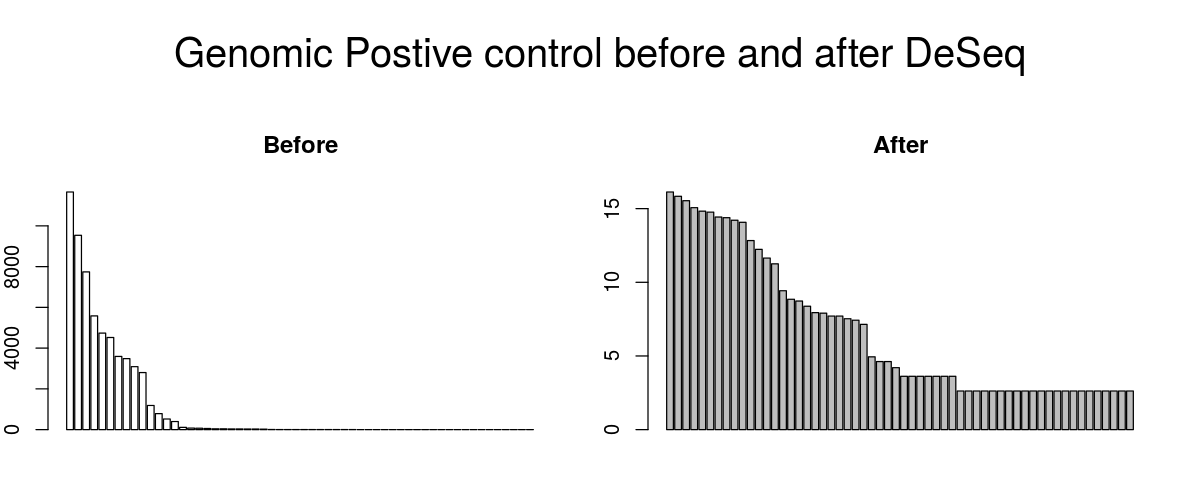

In [73]:
par(mfrow=c(1,2))
par(mar=c(2,2,4,2))
par(oma=c(0,0,4,0))

barplot(aalost[,'PosG'],
    col=aalost[,'lost'], 
    names.arg = '',
    main = 'Before',
    )

barplot(as.vector(bbOTU[,'PosG']),
       main = 'After',
       )

mtext("Genomic Postive control before and after DeSeq", 
      side = 3, 
      line = 1, 
      outer = TRUE, 
      cex = 2,
     )

How about the ITS-only positive control? Use the same pipeline...

In [75]:
#aa <- biom95
#bb <- DESeq_varstab(biom95, ~Library)
aaOTU <- (otu_table(aa)[,'PosI']) ## our control, before
aaOTU <- aaOTU[aaOTU != 0]

bbOTU <- (otu_table(bb)[,'PosI']) ## our control, after
bbOTU <- bbOTU[bbOTU != 0]

rownames(aaOTU) %in% rownames(bbOTU) ## did we lose any?

## tag them for plotting and comparison
lost <- !(rownames(aaOTU) %in% rownames(bbOTU))
aalost <- cbind(aaOTU,lost)
aalost <- aalost[order(aalost[,'PosI'], decreasing = TRUE),]
bbOTU <- bbOTU[order(bbOTU[,'PosI'], decreasing = TRUE),]

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[76] TRUE

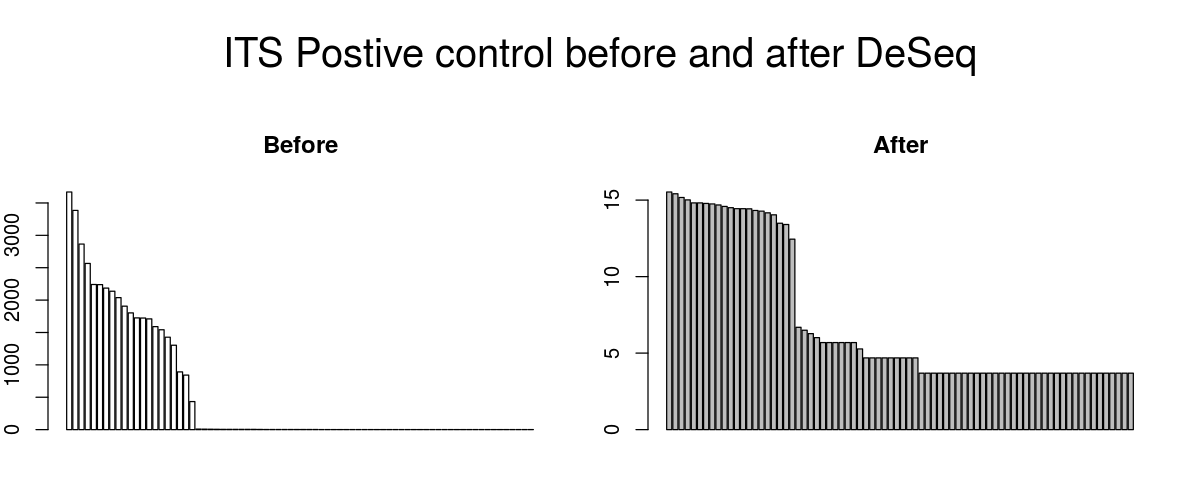

In [76]:
par(mfrow=c(1,2))
par(mar=c(2,2,4,2))
par(oma=c(0,0,4,0))

barplot(aalost[,'PosI'],
    col=aalost[,'lost'], 
    names.arg = '',
    main = 'Before',
    )

barplot(as.vector(bbOTU[,'PosI']),
       main = 'After',
       )

mtext("ITS Postive control before and after DeSeq", 
      side = 3, 
      line = 1, 
      outer = TRUE, 
      cex = 2,
     )

If we get time, color these in with membership of the mock community. 

<h4>Ecological samples after variance stabilization</h4>

In [54]:
load('biom95.mc.rem.rda')
aa <- biom95.mc.rem
load('deseq95.rda')
bb <- deseq95

aaOTU <- (otu_table(aa)[,'1w'])
aaOTU <- aaOTU[aaOTU != 0]
bbOTU <- (otu_table(bb)[,'1w'])
bbOTU <- bbOTU[bbOTU != 0]
rownames(aaOTU) %in% rownames(bbOTU) 
## let's tag these, plot them
lost <- !(rownames(aaOTU) %in% rownames(bbOTU))*1
aalost <- cbind(aaOTU,lost)
aalost <- aalost[order(aalost[,'1w'], decreasing = TRUE),]
bbOTU <- bbOTU[order(bbOTU[,'1w'], decreasing = TRUE),]


[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[76] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

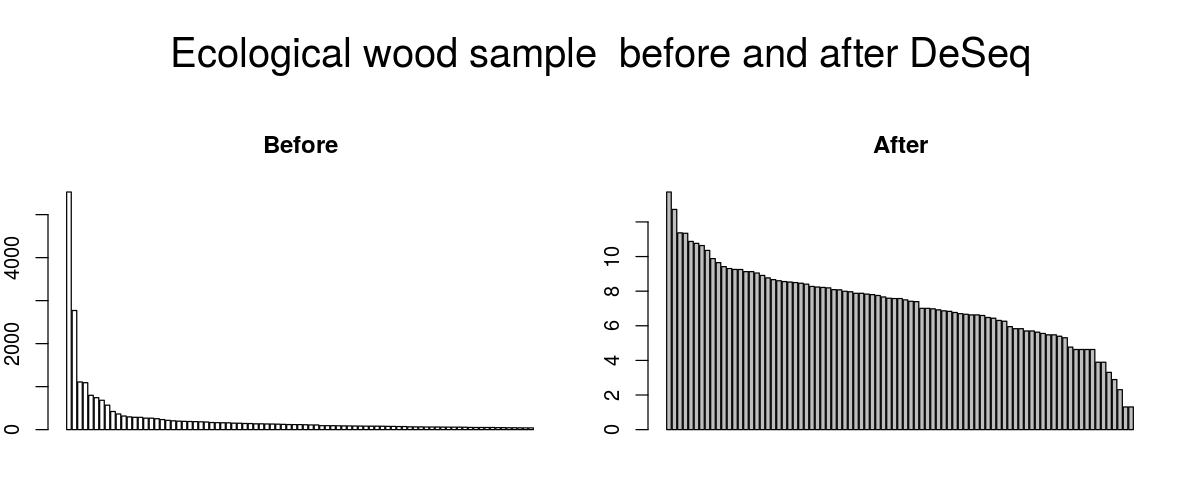

In [56]:
par(mfrow=c(1,2))
par(mar=c(2,2,4,2))
par(oma=c(0,0,4,0))

barplot(aalost[,'1w']+40, ## add some to make visible
    col=aalost[,'lost'], 
    names.arg = '',
    main = 'Before',
    )

barplot(as.vector(bbOTU[,'1w']),
       main = 'After',
       )

mtext("Ecological wood sample  before and after DeSeq", 
      side = 3, 
      line = 1, 
      outer = TRUE, 
      cex = 2,
     )

Huh, unlike in our last analysis, we didn't lose our rare OTUs. I'm not sure why/what was different in the case. Generally, though, the transformation here is pretty clean. As before, deseq's algorithmns improve but don't completely ameliorate the issues of uneven amplification and sequencer detection. 

Ideally, one should be able to train an algorithm based on performance with a series of positive controls. I can imagine this being part of the future of hi-throughput metabarcoding pipelines. 

<a id='NMSs'><h2>NMS/PERMANOVA Ordinations</h2></a>

<a id='WvLNMS'><h3>Wood vs. Leaf librariesWood vs. Leaf libraries, all reads</h3><a>

In [80]:
## get two otu tables out, one for all wood samples, one for all leaf samples:
woodOTU <- otu_table(subset_samples(deseq95, Library=='W'))
wood <- t(woodOTU@.Data) ## transpose so samples are rows

leafOTU <- otu_table(subset_samples(deseq95, Library=='L'))
leaf <- t(leafOTU@.Data) ## transpose so samples are rows

In [81]:
dim(wood); dim(leaf) ## note this 
nmsmat <- rbind(wood, leaf)

[1]   91 3327

[1]  123 3327

In [85]:
save(nmsmat, file='nmsmat.rda')

In [82]:
WvsL <- metaMDS(nmsmat)

Wisconsin double standardization
Run 0 stress 0.0001791434 
Run 1 stress 0.0002137209 
... Procrustes: rmse 0.0001871009  max resid 0.002720356 
... Similar to previous best
Run 2 stress 0.0001897826 
... Procrustes: rmse 0.0002596393  max resid 0.003777302 
... Similar to previous best
Run 3 stress 0.0002119864 
... Procrustes: rmse 2.941868e-05  max resid 0.0003928597 
... Similar to previous best
Run 4 stress 0.0002037484 
... Procrustes: rmse 2.253602e-05  max resid 0.0002837903 
... Similar to previous best
Run 5 stress 0.0001947748 
... Procrustes: rmse 7.080397e-05  max resid 0.001015304 
... Similar to previous best
Run 6 stress 0.0001851663 
... Procrustes: rmse 0.000251969  max resid 0.003664053 
... Similar to previous best
Run 7 stress 0.0001863611 
... Procrustes: rmse 0.0002514439  max resid 0.003658659 
... Similar to previous best
Run 8 stress 0.0001810524 
... Procrustes: rmse 0.0002002467  max resid 0.00290918 
... Similar to previous best
Run 9 stress 0.0001733723 
.

Warning message in metaMDS(nmsmat):
“stress is (nearly) zero: you may have insufficient data”

In [83]:
## make a color vector, leaves green, wood brown:
color <- NULL
color[1:91] <- 'brown'
color[92:214] <- 'green'

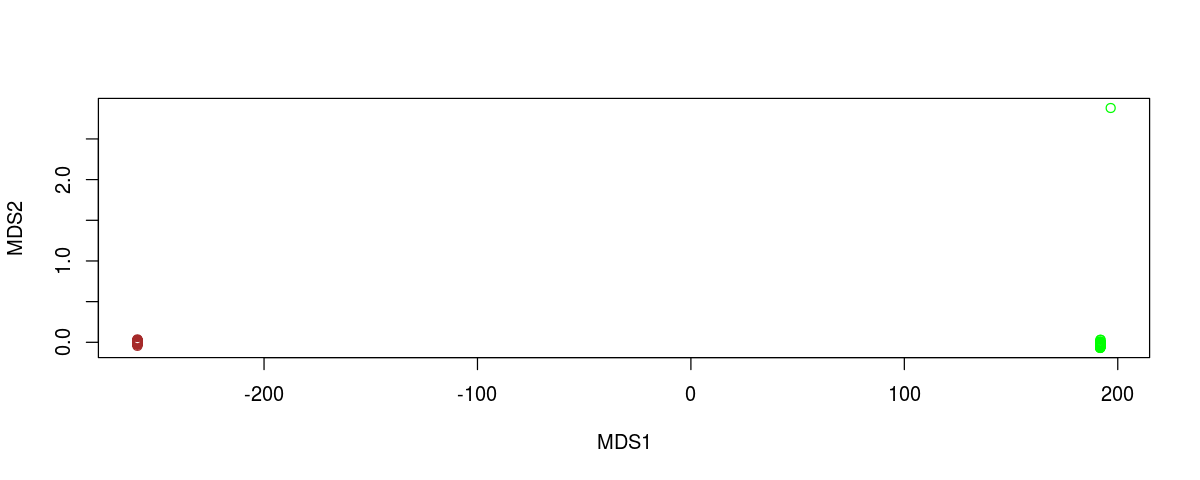

In [84]:
plot(WvsL$points, col=color)

Weird, we have complete separation, unlike last time... Cutoffs too stringent? Look at this without the outlier...

In [ ]:
identify(WvsL$points) ##181

Wisconsin double standardization
Run 0 stress 8.954737e-05 
Run 1 stress 9.190804e-05 
... Procrustes: rmse 3.928785e-05  max resid 0.0004408048 
... Similar to previous best
Run 2 stress 9.379337e-05 
... Procrustes: rmse 3.602598e-05  max resid 0.0003702779 
... Similar to previous best
Run 3 stress 9.147567e-05 
... Procrustes: rmse 3.263903e-05  max resid 0.0003767296 
... Similar to previous best
Run 4 stress 8.765039e-05 
... New best solution
... Procrustes: rmse 2.178718e-05  max resid 0.0001101781 
... Similar to previous best
Run 5 stress 8.773564e-05 
... Procrustes: rmse 3.303455e-05  max resid 0.000338349 
... Similar to previous best
Run 6 stress 9.959286e-05 
... Procrustes: rmse 3.305523e-05  max resid 0.0003628473 
... Similar to previous best
Run 7 stress 9.758524e-05 
... Procrustes: rmse 3.523646e-05  max resid 0.0003298133 
... Similar to previous best
Run 8 stress 9.685904e-05 
... Procrustes: rmse 3.613546e-05  max resid 0.0004043215 
... Similar to previous best

Warning message in metaMDS(nmsmat_noOut):
“stress is (nearly) zero: you may have insufficient data”

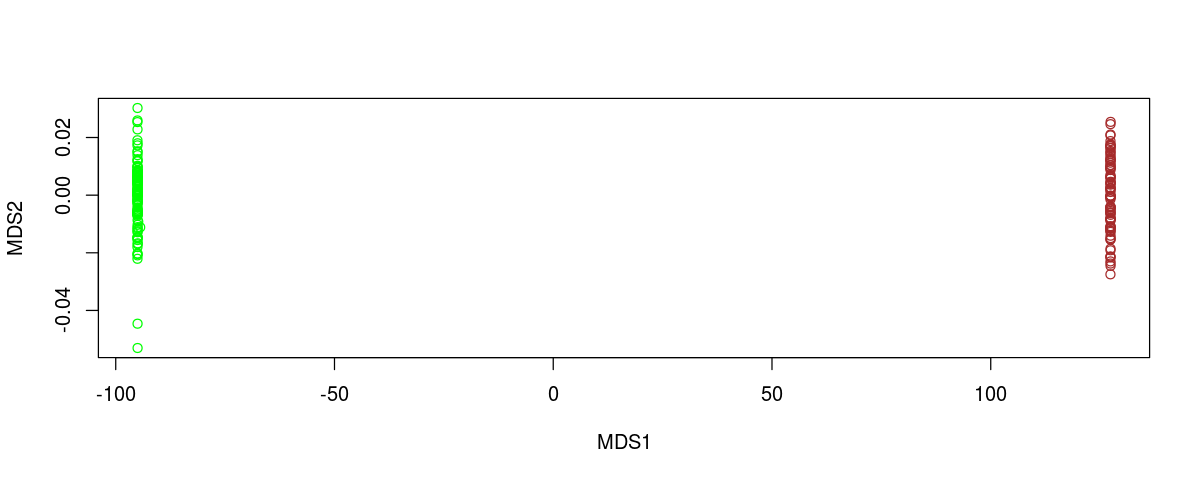

In [86]:
nmsmat_noOut <- nmsmat[-181,]
WvsL_noOut <- metaMDS(nmsmat_noOut)
color <- NULL
color[1:91] <- 'brown'
color[92:214] <- 'green'
plot(WvsL_noOut$points, col=color)

Hmm. Total separation... Our last analysis showed some overlap... the only difference I can think of is that I cleaned the negatives separately. Apparently it made a difference. 

Do we see any sort of difference if we transform our data to presence/absence?

In [89]:
nmsmat.PA <- nmsmat_noOut
nmsmat.PA[nmsmat.PA > 0] <- 1
WvsL.PA <- metaMDS(nmsmat.PA)

Run 0 stress 9.075196e-05 
Run 1 stress 9.119895e-05 
... Procrustes: rmse 2.578939e-05  max resid 9.191718e-05 
... Similar to previous best
Run 2 stress 8.633431e-05 
... New best solution
... Procrustes: rmse 3.826129e-05  max resid 0.0003420187 
... Similar to previous best
Run 3 stress 9.589004e-05 
... Procrustes: rmse 3.221965e-05  max resid 0.0002469573 
... Similar to previous best
Run 4 stress 9.096515e-05 
... Procrustes: rmse 3.41114e-05  max resid 0.0003903983 
... Similar to previous best
Run 5 stress 8.86225e-05 
... Procrustes: rmse 2.104221e-05  max resid 0.0001564683 
... Similar to previous best
Run 6 stress 9.54635e-05 
... Procrustes: rmse 4.057168e-05  max resid 0.0004528917 
... Similar to previous best
Run 7 stress 9.080032e-05 
... Procrustes: rmse 4.615923e-05  max resid 0.0005363398 
... Similar to previous best
Run 8 stress 8.31665e-05 
... New best solution
... Procrustes: rmse 3.373823e-05  max resid 0.0003856375 
... Similar to previous best
Run 9 stress 

Warning message in metaMDS(nmsmat.PA):
“stress is (nearly) zero: you may have insufficient data”

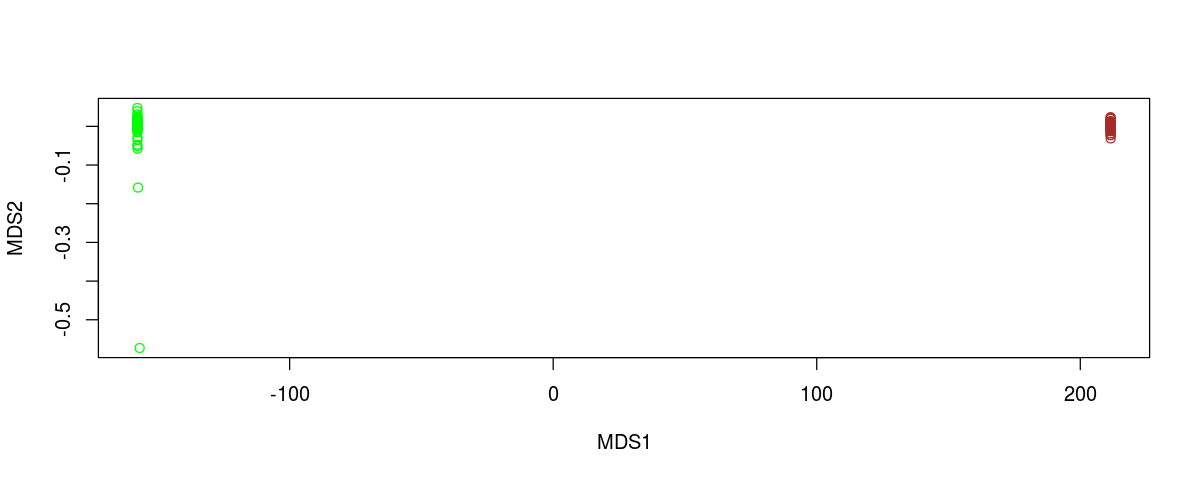

In [90]:
plot(WvsL.PA$points, col=color)

Pretty similar...

<a id='WvLshared'><h3>Wood vs. Leaf endophyte comparison, look for shared species</h3></a>


In [93]:
wood <- subset_samples(deseq95, Library=="W")
leaf <- subset_samples(deseq95, Library=="L")

In [94]:
## reduce these OTU tables to non-zero rows:
woodOTU <- otu_table(wood) ## otus are rows
woodspp <- rownames(woodOTU[rowSums(woodOTU)>0,])

In [95]:
## do the same for the leaves:
leafOTU <- otu_table(leaf)
leafspp <- rownames(leafOTU[rowSums(leafOTU)>0,])

In [99]:
leafspp

[1] "OTU19:100leaf"    "OTU108:100leaf"   "OTU1:100leaf"    
   [4] "OTU202:100leaf"   "OTU426:100leaf"   "OTU10:100leaf"   
   [7] "OTU17:100leaf"    "OTU429:100leaf"   "OTU15:100leaf"   
  [10] "OTU27:100leaf"    "OTU355:100leaf"   "OTU22:101leaf"   
  [13] "OTU91:100leaf"    "OTU570:100leaf"   "OTU406:100leaf"  
  [16] "OTU181:100leaf"   "OTU520:100leaf"   "OTU73:100leaf"   
  [19] "OTU159:100leaf"   "OTU794:16leaf"    "OTU297:100leaf"  
  [22] "OTU252:117leaf"   "OTU1199:41leaf"   "OTU951:14leaf"   
  [25] "OTU412:102leaf"   "OTU78:100leaf"    "OTU226:100leaf"  
  [28] "OTU282:100leaf"   "OTU468:107leaf"   "OTU209:101leaf"  
  [31] "OTU368:100leaf"   "OTU381:66leaf"    "OTU883:107leaf"  
  [34] "OTU239:100leaf"   "OTU1006:100leaf"  "OTU1938:130leaf" 
  [37] "OTU1495:100leaf"  "OTU93:100leaf"    "OTU1071:100leaf" 
  [40] "OTU263:100leaf"   "OTU371:110leaf"   "OTU2975:100leaf" 
  [43] "OTU319:100leaf"   "OTU303:111leaf"   "OTU1159:103leaf" 
  [46] "OTU613:100leaf"   "OTU1134:100leaf"  "OTU1182:100leaf" 
  [49] "OTU360:100leaf"   "OTU70:100leaf"    "OTU1690:100leaf" 
  [52] "OTU247:17leaf"    "OTU16:100leaf"    "OTU45:100leaf"   
  [55] "OTU1731:100leaf"  "OTU584:100leaf"   "OTU53:107leaf"   
  [58] "OTU591:100leaf"   "OTU1657:104leaf"  "OTU1224:101leaf" 
  [61] "OTU1151:51leaf"   "OTU668:100leaf"   "OTU280:100leaf"  
  [64] "OTU736:100leaf"   "OTU514:125leaf"   "OTU1543:100leaf" 
  [67] "OTU1169:100leaf"  "OTU61:100leaf"    "OTU890:100leaf"  
  [70] "OTU97:102leaf"    "OTU540:14leaf"    "OTU1140:100leaf" 
  [73] "OTU3:102leaf"     "OTU1816:105leaf"  "OTU94:114leaf"   
  [76] "OTU2267:100leaf"  "OTU635:100leaf"   "OTU2082:16leaf"  
  [79] "OTU199:101leaf"   "OTU74:101leaf"    "OTU262:101leaf"  
  [82] "OTU110:101leaf"   "OTU797:101leaf"   "OTU667:101leaf"  
  [85] "OTU284:101leaf"   "OTU1586:101leaf"  "OTU446:101leaf"  
  [88] "OTU42:101leaf"    "OTU729:116leaf"   "OTU1830:101leaf" 
  [91] "OTU1927:101leaf"  "OTU1047:101leaf"  "OTU4:101leaf"    
  [94] "OTU2005:101leaf"  "OTU372:117leaf"   "OTU340:103leaf"  
  [97] "OTU2175:101leaf"  "OTU194:119leaf"   "OTU462:101leaf"  
 [100] "OTU457:101leaf"   "OTU124:101leaf"   "OTU405:101leaf"  
 [103] "OTU545:47leaf"    "OTU436:102leaf"   "OTU43:101leaf"   
 [106] "OTU2259:101leaf"  "OTU346:101leaf"   "OTU846:101leaf"  
 [109] "OTU115:101leaf"   "OTU2066:101leaf"  "OTU666:120leaf"  
 [112] "OTU8842:131leaf"  "OTU511:101leaf"   "OTU705:114leaf"  
 [115] "OTU824:120leaf"   "OTU343:103leaf"   "OTU1144:101leaf" 
 [118] "OTU546:101leaf"   "OTU116:117leaf"   "OTU261:102leaf"  
 [121] "OTU549:132leaf"   "OTU218:102leaf"   "OTU677:15leaf"   
 [124] "OTU663:110leaf"   "OTU1841:116leaf"  "OTU946:101leaf"  
 [127] "OTU583:13leaf"    "OTU831:101leaf"   "OTU3181:107leaf" 
 [130] "OTU3042:41leaf"   "OTU1142:101leaf"  "OTU454:101leaf"  
 [133] "OTU1213:101leaf"  "OTU378:101leaf"   "OTU1813:117leaf" 
 [136] "OTU1436:101leaf"  "OTU940:103leaf"   "OTU788:104leaf"  
 [139] "OTU8836:14leaf"   "OTU2103:15leaf"   "OTU744:104leaf"  
 [142] "OTU681:101leaf"   "OTU5825:114leaf"  "OTU717:128leaf"  
 [145] "OTU489:125leaf"   "OTU182:30leaf"    "OTU448:1leaf"    
 [148] "OTU1576:14leaf"   "OTU2497:131leaf"  "OTU5:102leaf"    
 [151] "OTU109:102leaf"   "OTU54:102leaf"    "OTU100:102leaf"  
 [154] "OTU173:13leaf"    "OTU422:62leaf"    "OTU1088:102leaf" 
 [157] "OTU812:102leaf"   "OTU89:102leaf"    "OTU1025:3leaf"   
 [160] "OTU660:102leaf"   "OTU3689:102leaf"  "OTU644:102leaf"  
 [163] "OTU244:115leaf"   "OTU79:102leaf"    "OTU2372:102leaf" 
 [166] "OTU1318:1leaf"    "OTU208:103leaf"   "OTU1359:130leaf" 
 [169] "OTU1554:102leaf"  "OTU2:102leaf"     "OTU1963:102leaf" 
 [172] "OTU1064:75leaf"   "OTU311:102leaf"   "OTU470:103leaf"  
 [175] "OTU852:102leaf"   "OTU65:102leaf"    "OTU956:103leaf"  
 [178] "OTU440:102leaf"   "OTU309:117leaf"   "OTU330:102leaf"  
 [181] "OTU1734:102leaf"  "OTU572:102leaf"   "OTU1654:2leaf"   
 [184] "OTU509:102leaf"   "OTU86:102leaf"    "OTU268:102leaf"  
 [187] "OTU48:102leaf"    "OTU538:1

In [101]:
any(woodspp %in% leafspp)

[1] FALSE

In [102]:
any(leafspp %in% woodspp)

[1] FALSE

Huh, no shared species... might be in for a ride now... let's see what other differences present.

<a id='HostNMS'><h3>Host NMS/PermANOVA</h3></a>

Let's look for grouping of samples by host. It is difficult here to disentangle spatial patterns of the host and microbe here, if we find "host preference" this may be due to fungal species simply preferring the same habitat as the host, and not host-microbe interactions, etc. But a first look is needed. 

<a id='woodHostNMS'><h4>Wood library, Host effects</h4></a>


In [104]:
woodbiom  <- subset_samples(deseq95, Library=='W')
woodOTU <- otu_table(woodbiom)
wood <- t(woodOTU@.Data) ## transpose, default phyloseq uses otus as rows
wood_data <- sample_data(woodbiom)
WoodMDS <- metaMDS(wood)

Wisconsin double standardization
Run 0 stress 0.2762519 
Run 1 stress 0.2861963 
Run 2 stress 0.2798003 
Run 3 stress 0.2768649 
Run 4 stress 0.2800364 
Run 5 stress 0.2760376 
... New best solution
... Procrustes: rmse 0.05330076  max resid 0.3131359 
Run 6 stress 0.2745264 
... New best solution
... Procrustes: rmse 0.09014175  max resid 0.4031058 
Run 7 stress 0.2769832 
Run 8 stress 0.2737327 
... New best solution
... Procrustes: rmse 0.04985925  max resid 0.2799055 
Run 9 stress 0.2792227 
Run 10 stress 0.2783602 
Run 11 stress 0.2774815 
Run 12 stress 0.2722429 
... New best solution
... Procrustes: rmse 0.04791228  max resid 0.2363086 
Run 13 stress 0.2743483 
Run 14 stress 0.279028 
Run 15 stress 0.2753582 
Run 16 stress 0.2803394 
Run 17 stress 0.2746752 
Run 18 stress 0.2766783 
Run 19 stress 0.2758248 
Run 20 stress 0.279634 
*** No convergence -- monoMDS stopping criteria:
     1: no. of iterations >= maxit
    19: stress ratio > sratmax


In [108]:
samps <- table(wood_data$Host_genus_species)
spp <- names(samps)
hostspp <- sapply(wood_data$Host_genus_species, FUN= function(x){which(spp == x)})
n <- length(spp)
palette <- distinctColorPalette(n)

Before we plot, just checking, what do our samples sizes look like for each tree host?

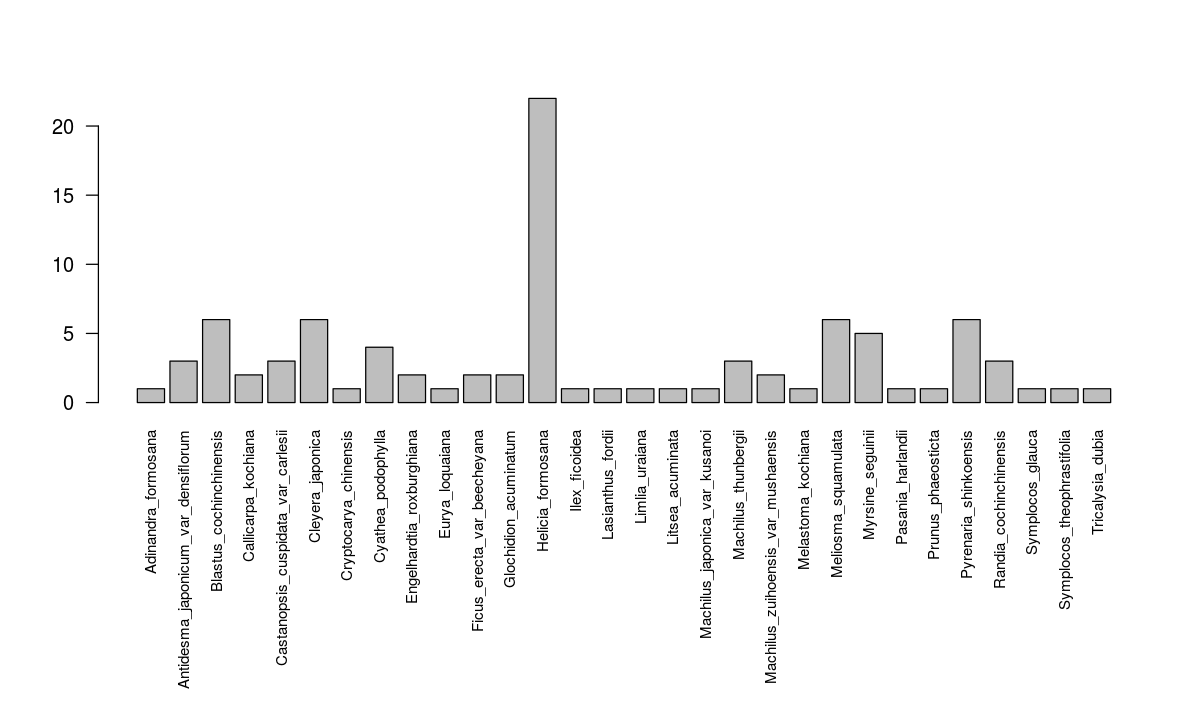

In [109]:
options(repr.plot.width = 10,repr.plot.height = 6)
par(oma=c(8,0,0,0))
barplot(samps, las=2, cex.names=.75)

Definitely some pretty uneven sample sizes. 

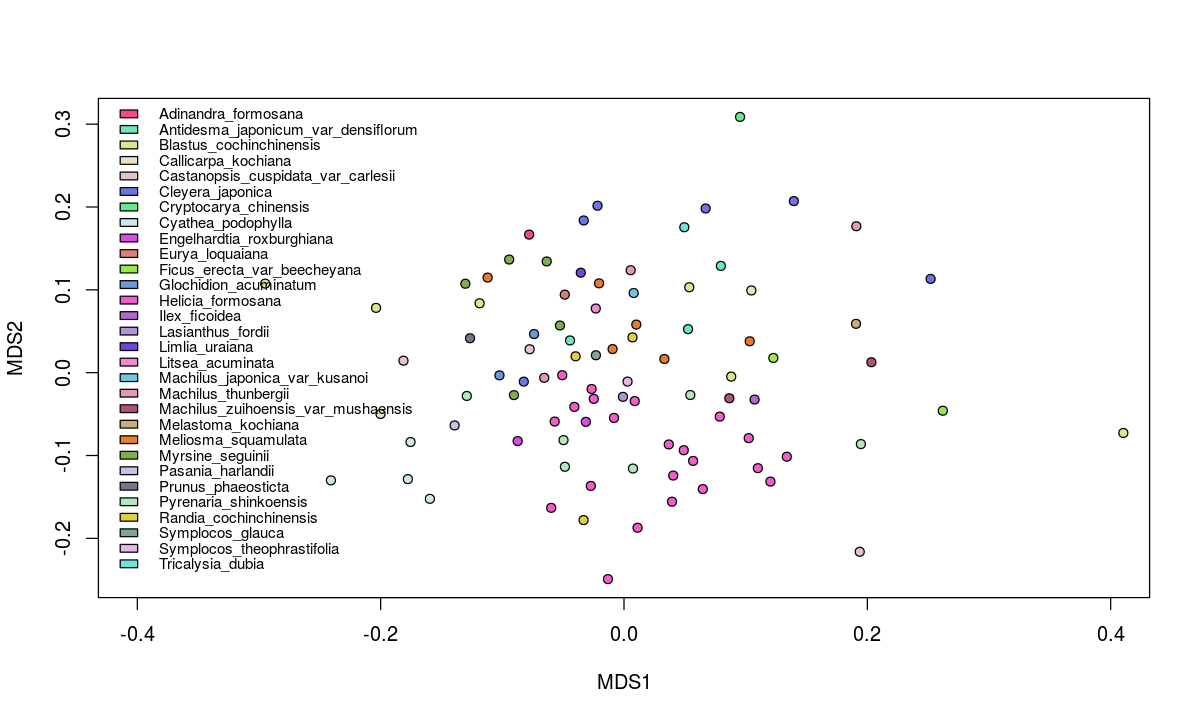

In [110]:
plot(WoodMDS$points,
    bg=palette[hostspp],
    col='black',
    pch=21,
    xlim=c(-0.4,0.4)
    )
legend('topleft',
        legend=spp,
        fill=palette,
        cex=.75,
        bty='n')

Suggestive, looks like some host communities are grouping together. We have a lot of low-sample hosts, we can remove host trees with less than 3 samples from the graphic to clear things up a bit. 

In [111]:
hisamps <- samps[samps > 2] ## only hosts with >2 samples
hihosts <- wood_data$Host_genus_species %in% names(hisamps)
## make new groups/color palette
hispp <- names(hisamps)
hihostspp <- sapply(wood_data$Host_genus_species[hihosts], FUN= function(x){which(hispp == x)})
n <- length(hispp)
palette <- distinctColorPalette(n)

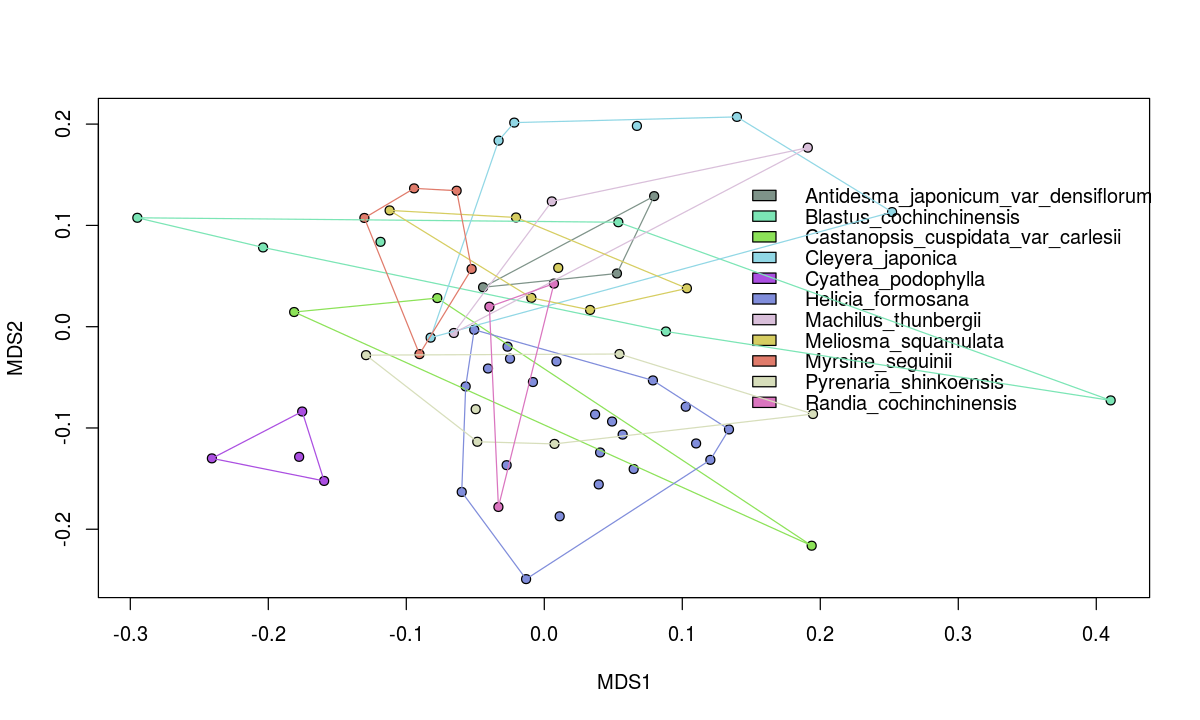

In [113]:
#png('woodhostNMS.png')
plot(WoodMDS$points[hihosts,],
    col="black",
    pch = 21,
    bg = palette[hihostspp],
    #xlim = c(-0.15,.35),
)
legend( x=.13,
    y=0.15,
    legend=hispp,
    fill=palette,
    bty='n')

## hulls have to be drawn one by one if we use ordihull():
for(i in 1:length(hispp)){
ordihull(WoodMDS, groups=wood_data$Host_genus_species, show.groups=hispp[i], col=palette[i])
}
#dev.off()

In [114]:
testwoodhost <- adonis(wood ~ wood_data$Host_genus_species, permutations=10000)

In [115]:
testwoodhost


Call:
adonis(formula = wood ~ wood_data$Host_genus_species, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                             Df SumsOfSqs MeanSqs F.Model      R2    Pr(>F)    
wood_data$Host_genus_species 29    14.849 0.51205  1.4945 0.41538 9.999e-05 ***
Residuals                    61    20.900 0.34262         0.58462              
Total                        90    35.749                 1.00000              
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

R2 = .415, significant. But again, hard to trust these numbers given that we are ignoring spatial aspects of this, other covariates, and there are dispersion differences. The NMS figures show a centroid location difference among several groups, though.

Check the dispersion.

In [117]:
dis <- vegdist(wood)
disp <- betadisper(dis, hostspp)
disp
anova(disp) ## still significantly different


	Homogeneity of multivariate dispersions

Call: betadisper(d = dis, group = hostspp)

No. of Positive Eigenvalues: 90
No. of Negative Eigenvalues: 0

Average distance to median:
     1      2      3      4      5      6      7      8      9     10     11 
0.0000 0.4780 0.6045 0.3732 0.5271 0.5659 0.0000 0.5197 0.3966 0.0000 0.3808 
    12     13     14     15     16     17     18     19     20     21     22 
0.3524 0.5647 0.0000 0.0000 0.0000 0.0000 0.0000 0.5006 0.4173 0.0000 0.5045 
    23     24     25     26     27     28     29     30 
0.4595 0.0000 0.0000 0.5112 0.4714 0.0000 0.0000 0.0000 

Eigenvalues for PCoA axes:
 PCoA1  PCoA2  PCoA3  PCoA4  PCoA5  PCoA6  PCoA7  PCoA8 
2.1934 1.9167 1.6608 1.4984 1.1265 0.9894 0.9303 0.8360 

Df Sum Sq    Mean Sq     F value  Pr(>F)      
Groups    29 3.4684323 0.119601113 42.94714 1.081307e-30
Residuals 61 0.1698755 0.002784845       NA           NA

In [118]:
permutest(disp, pairwise = TRUE)


Permutation test for homogeneity of multivariate dispersions
Permutation: free
Number of permutations: 999

Response: Distances
          Df Sum Sq  Mean Sq      F N.Perm Pr(>F)    
Groups    29 3.4684 0.119601 42.947    999  0.001 ***
Residuals 61 0.1699 0.002785                         
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Pairwise comparisons:
(Observed p-value below diagonal, permuted p-value above diagonal)
   1          2          3          4          5          6 7          8
1                                                                       
2               1.1000e-02 3.4000e-02 5.3400e-01 1.8000e-02   2.6100e-01
3    8.1856e-03            7.0000e-03 1.6000e-01 2.0700e-01   2.1000e-02
4    2.6798e-02 1.1792e-03            1.1400e-01 1.2000e-02   1.5000e-02
5    4.9550e-01 1.8071e-01 1.5267e-01            4.9800e-01   9.2200e-01
6    1.6664e-02 1.9517e-01 8.0972e-04 4.4475e-01              1.3700e-01
7                                        

Do a type of tukeys to show why there are significant differences in dispersion among our host/microbe groupings.

In [119]:
disp.HSD <- TukeyHSD(disp)

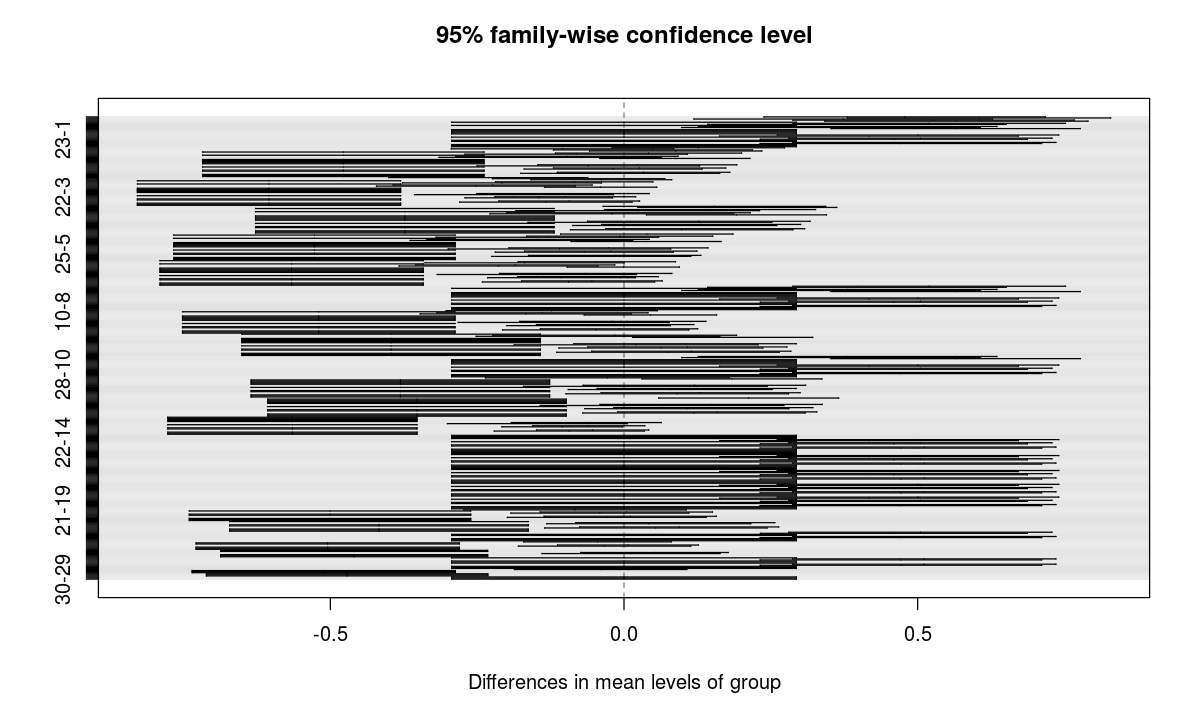

In [120]:
plot(disp.HSD)

Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '26'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '26'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '26'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '27'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '30'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '27'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '29'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '27'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '26'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimplemented pch value '28'”Warning message in plot.xy(xy.coords(x, y), type = type, ...):
“unimpl

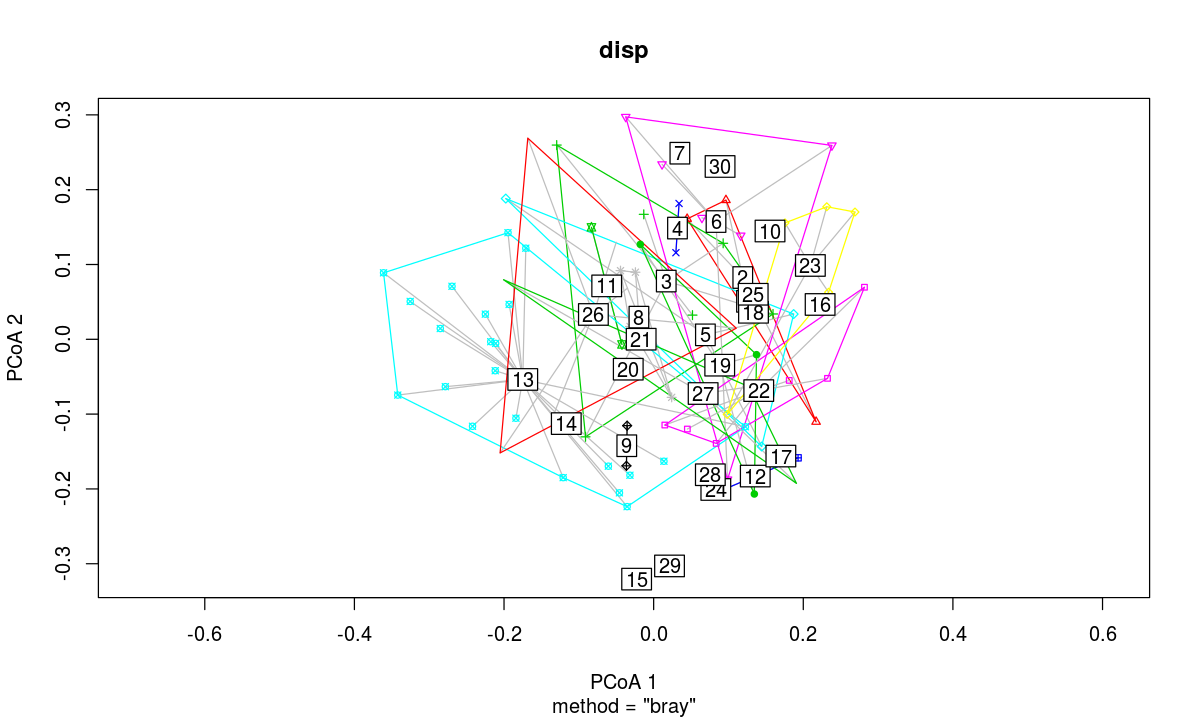

In [121]:
plot(disp)

These are distances along principal coordinates of the BC disimilarity matrix of the community matrix. I'm not sure how to interprest these units, I thought principle coordinates axes couldn't be relied upon to scale linearly, not sure if they are in anyway meaningful.  [Jari Oksanen's documentation](http://cc.oulu.fi/~jarioksa/softhelp/vegan/html/betadisper.html) explains some, this seems to be a way of dealing with the non-euclidean disimilarity metrics like BC. but I really have no idea what these graphs mean in biological terms, except that I assume that the first is a classic tukeys comparison among all the host-groups. I.e., if comparisons that wander far away from the zero are very different in their dispersions and having comparisons all over the chart like this reinforces that we have lots of different sized dispersions. 

I don't really think there is much here that we can't see in the NMS - dispersions vary among the samples when grouped by host, centroids among some groups are clearly distant.

<a id='leafHostNMS'><h4>Leaf library, Host effects</h4></a>


In [208]:
load('deseq95.rda')
leafbiom  <- subset_samples(deseq95, Library=='L')
leafOTU <- otu_table(leafbiom)
leaf <- t(leafOTU@.Data)
leaf_data <- sample_data(leafbiom)

In [130]:
leafMDS <- metaMDS(leaf)

Wisconsin double standardization
Run 0 stress 0.1260886 
Run 1 stress 0.126286 
... Procrustes: rmse 0.007593137  max resid 0.02835048 
Run 2 stress 0.1261514 
... Procrustes: rmse 0.005385356  max resid 0.02302638 
Run 3 stress 0.1262231 
... Procrustes: rmse 0.006093234  max resid 0.02625702 
Run 4 stress 0.1261953 
... Procrustes: rmse 0.00556488  max resid 0.02256784 
Run 5 stress 0.1261427 
... Procrustes: rmse 0.008918071  max resid 0.0310009 
Run 6 stress 0.1261769 
... Procrustes: rmse 0.009147585  max resid 0.03085108 
Run 7 stress 0.1263541 
... Procrustes: rmse 0.009491294  max resid 0.03489594 
Run 8 stress 0.1262606 
... Procrustes: rmse 0.007201247  max resid 0.01976357 
Run 9 stress 0.1260835 
... New best solution
... Procrustes: rmse 0.006365073  max resid 0.02962531 
Run 10 stress 0.1263009 
... Procrustes: rmse 0.006884862  max resid 0.03019338 
Run 11 stress 0.126175 
... Procrustes: rmse 0.004563682  max resid 0.03072516 
Run 12 stress 0.1262071 
... Procrustes: rm

In [132]:
#save(leafMDS, file='leafMDS.rda')

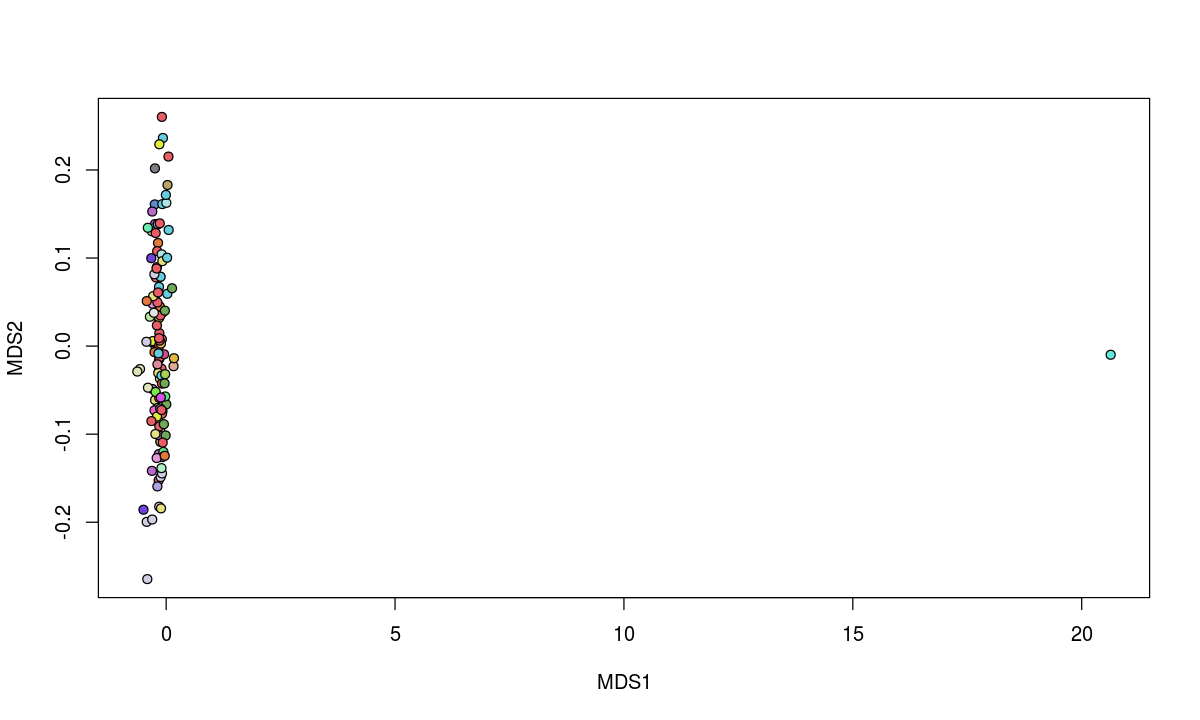

In [131]:
## host groups/colors
samps <- table(leaf_data$Host_genus_species)
spp <- names(samps)
hostspp <- sapply(leaf_data$Host_genus_species, FUN= function(x){which(spp == x)})
#spp == sort(unique(leaf_data$Host_genus_species)) ## yup, table function does this
n <- length(spp)
palette <- distinctColorPalette(n)

plot(leafMDS$points,
        col="black",
        pch = 21,
        bg = palette[hostspp]
)

Deal with outlier.

In [135]:
aa <- identify(leafMDS$points)
leafMDS$points[aa,,drop=FALSE]

MDS1     MDS2        
67leaf 20.63293 -0.009804052

In [166]:
load('deseq95.rda')
#leafbiom  <- subset_samples(deseq95, Library=='L')
leafbiom <- subset_samples(deseq95, Library=='L' & sample_names(deseq95) != '67leaf')
leafOTU <- otu_table(leafbiom)
leaf <- t(leafOTU@.Data)
leaf_data <- sample_data(leafbiom)
leafMDS <- metaMDS(leaf)

Wisconsin double standardization
Run 0 stress 0.2272767 
Run 1 stress 0.2228183 
... New best solution
... Procrustes: rmse 0.06748874  max resid 0.2225008 
Run 2 stress 0.2234125 
Run 3 stress 0.221964 
... New best solution
... Procrustes: rmse 0.03399047  max resid 0.1716347 
Run 4 stress 0.2261661 
Run 5 stress 0.2242256 
Run 6 stress 0.2207596 
... New best solution
... Procrustes: rmse 0.05095369  max resid 0.2120125 
Run 7 stress 0.2233848 
Run 8 stress 0.224871 
Run 9 stress 0.2242449 
Run 10 stress 0.2209459 
... Procrustes: rmse 0.01820455  max resid 0.1361952 
Run 11 stress 0.2256308 
Run 12 stress 0.220368 
... New best solution
... Procrustes: rmse 0.04457831  max resid 0.1884812 
Run 13 stress 0.2278026 
Run 14 stress 0.2212119 
Run 15 stress 0.2212353 
Run 16 stress 0.2264097 
Run 17 stress 0.2227323 
Run 18 stress 0.2222018 
Run 19 stress 0.2208622 
... Procrustes: rmse 0.05525574  max resid 0.2311904 
Run 20 stress 0.2240812 
*** No convergence -- monoMDS stopping crit

Save this solution for reproducibility:

In [191]:
#save(leafMDS, file='leafNMS_260618.rda')

Check sample sizes and replot NMS

In [167]:
## host groups/colors
samps <- table(leaf_data$Host_genus_species)

In [168]:
samps


                Adinandra_formosana Antidesma_japonicum_var_densiflorum 
                                  1                                   2 
            Blastus_cochinchinensis                 Callicarpa_kochiana 
                                 13                                   2 
 Castanopsis_cuspidata_var_carlesii                    Cleyera_japonica 
                                  4                                   6 
              Cryptocarya_chinensis                  Cyathea_podophylla 
                                  1                                   4 
             Elaeocarpus_sylvestris           Engelhardtia_roxburghiana 
                                  1                                   2 
                    Eurya_loquaiana         Ficus_erecta_var_beecheyana 
                                  1                                   2 
              Glochidion_acuminatum                   Helicia_formosana 
                                  1               

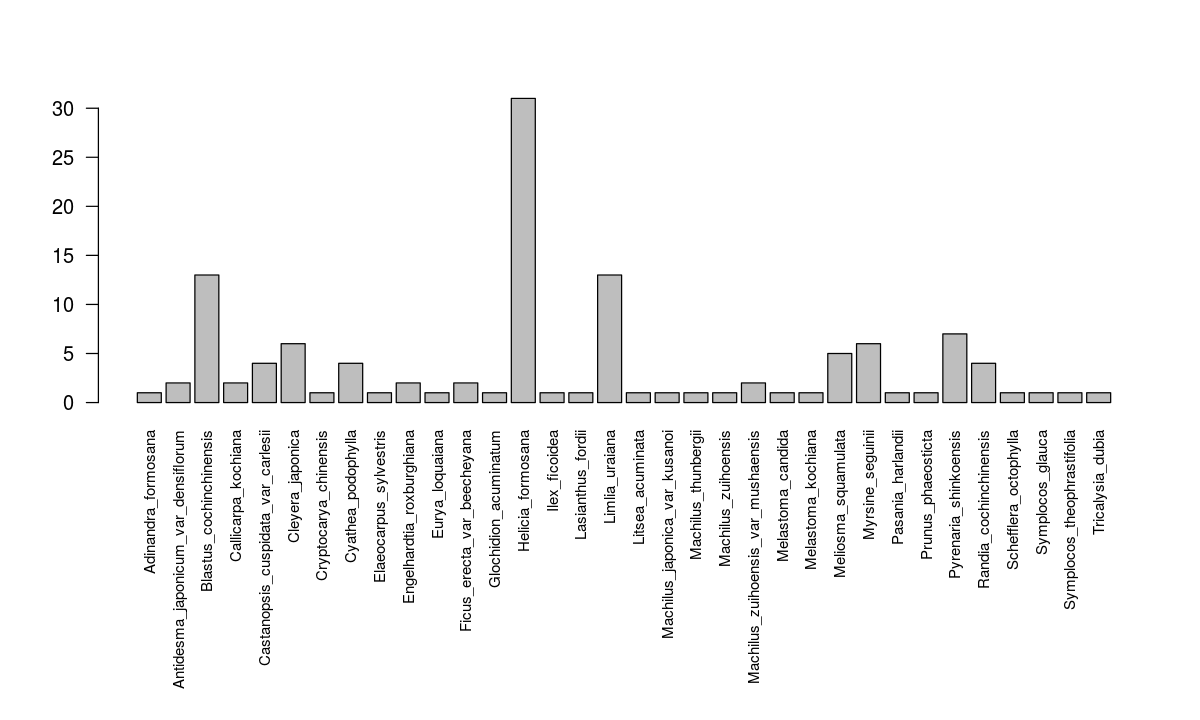

In [169]:
options(repr.plot.width = 10,repr.plot.height = 6)
par(oma=c(8,0,0,0))
barplot(samps, las=2, cex.names=.75)

As with the wood, *Helicia* is by far the most common host, and there are numerous small sample sizes for some of the other hosts. Rerun the NMS without the outlier:

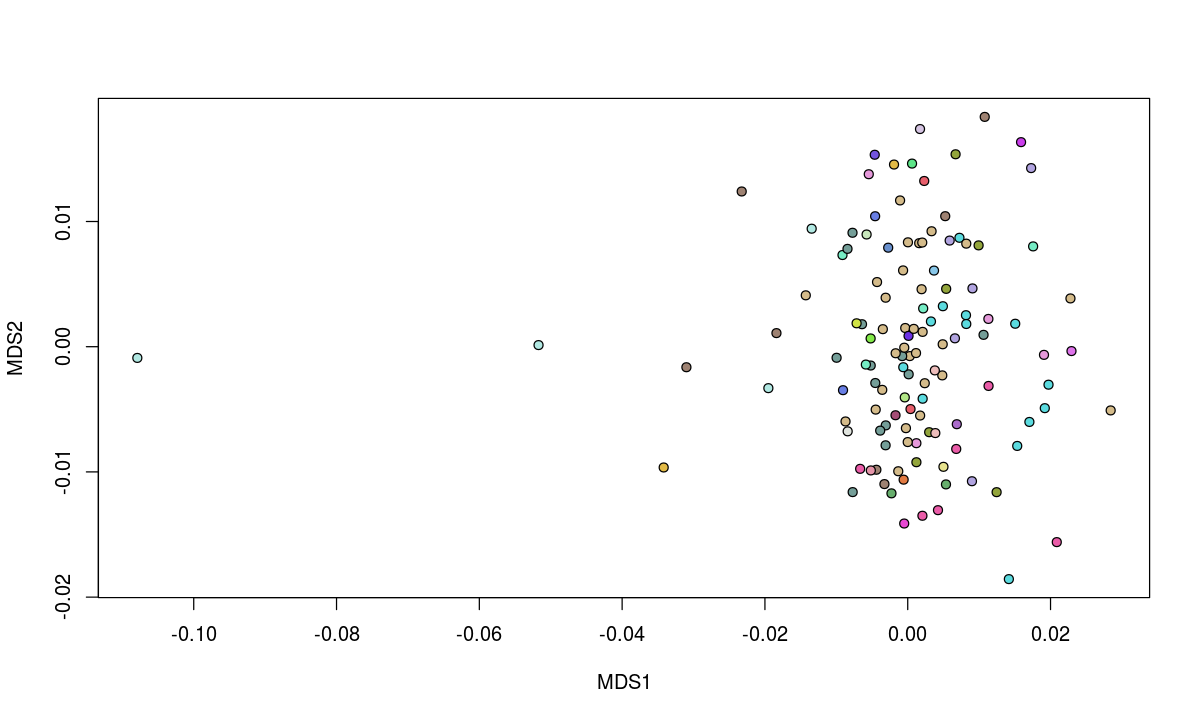

In [170]:
spp <- names(samps)
hostspp <- sapply(leaf_data$Host_genus_species, FUN= function(x){which(spp == x)})
#spp == sort(unique(leaf_data$Host_genus_species)) ## yup, table function does this
n <- length(spp)
palette <- distinctColorPalette(n)

plot(leafMDS$points,
        col="black",
        pch = 21,
        bg = palette[hostspp]
)

In [187]:
hisamps <- samps[samps > 2] ## only hosts with >2 samples
hihosts <- leaf_data$Host_genus_species %in% names(hisamps)
## make new groups/color palette
hispp <- names(hisamps)
hihostspp <- sapply(leaf_data$Host_genus_species[hihosts], FUN= function(x){which(hispp == x)})
n <- length(hispp)
palette <- distinctColorPalette(n)

[1] 122

[1] 122   2

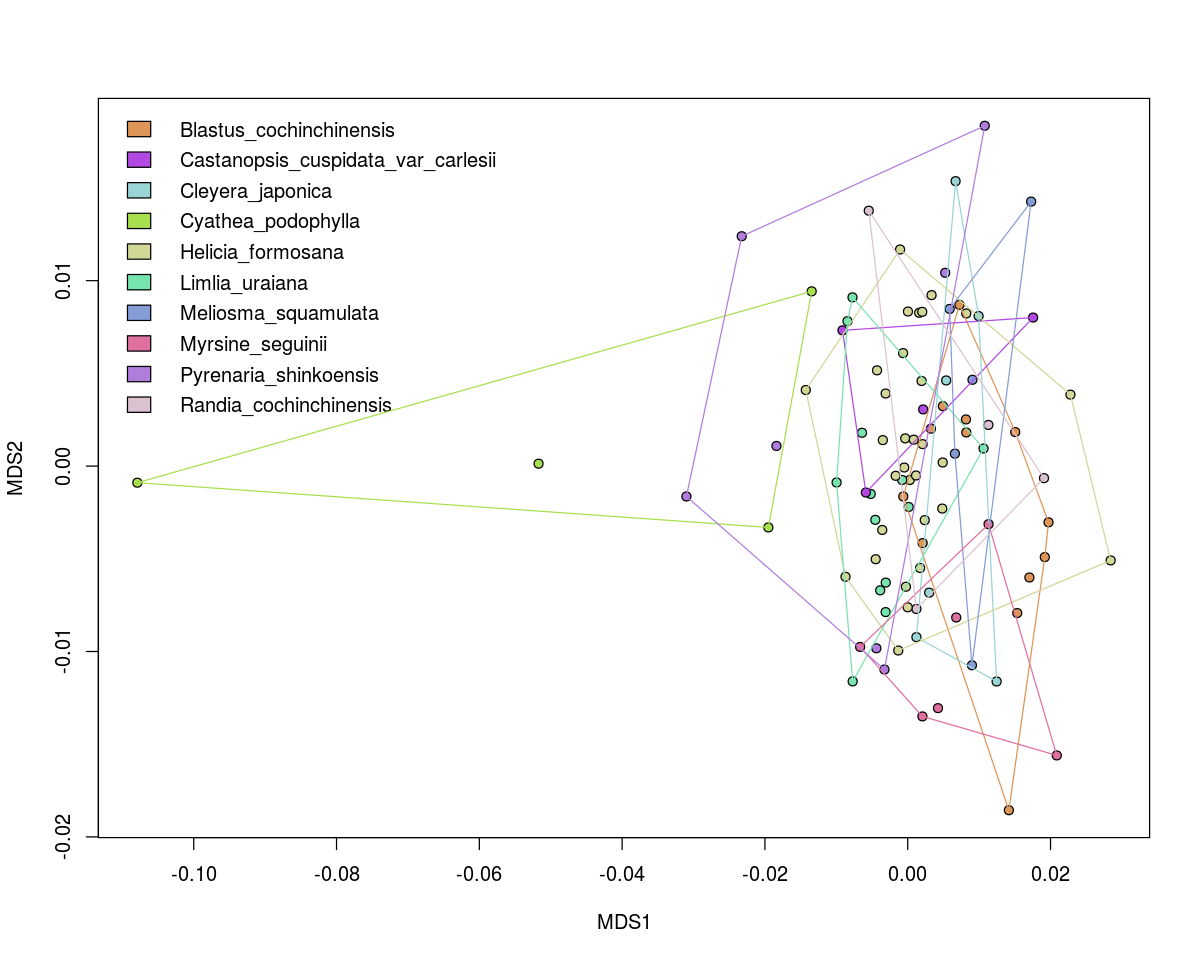

In [188]:
options(repr.plot.width = 10,repr.plot.height = 8)
#png('leafhostNMS.png')
plot(leafMDS$points[hihosts,],
        col="black",
        pch = 21,
        bg = palette[hihostspp]
)

length(hihosts); dim(leafMDS$points)

legend("topleft",
    legend=hispp,
    fill=palette,
    bty='n',
      )

for(i in 1:length(hispp)){
ordihull(leafMDS, groups=leaf_data$Host_genus_species, show.groups=hispp[i], col=palette[i])
}
#dev.off()

Zoom in a little. 

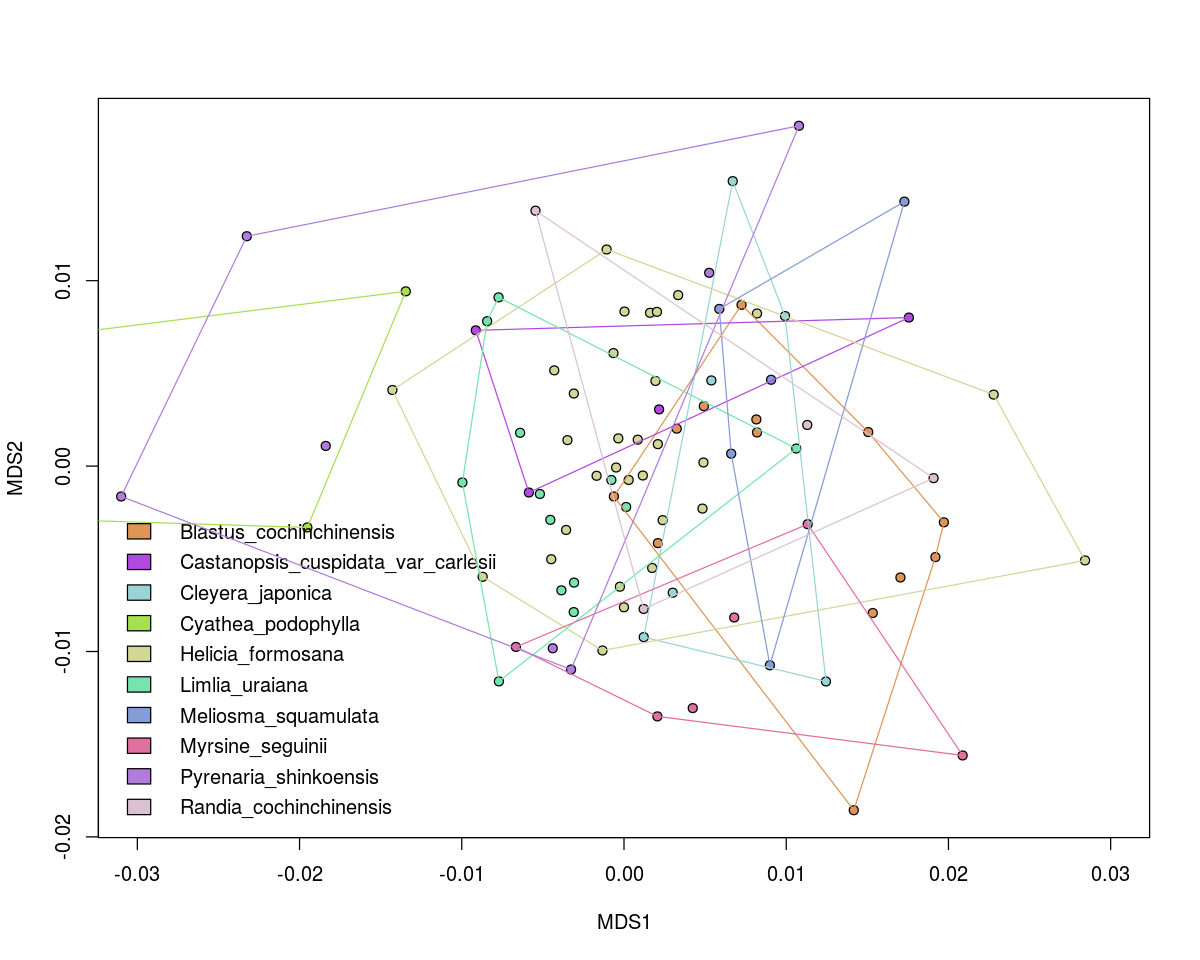

In [192]:
options(repr.plot.width = 10,repr.plot.height = 8)
#png('leafhostNMS.png')
plot(leafMDS$points[hihosts,],
        col="black",
        pch = 21,
        bg = palette[hihostspp],
        xlim = c(-.03,.03),
        #ylim = c(-.5,.5),
)
legend("bottomleft",
    legend=hispp,
    fill=palette,
    bty='n',
      )

for(i in 1:length(hispp)){
ordihull(leafMDS, groups=leaf_data$Host_genus_species, show.groups=hispp[i], col=palette[i])
}

#dev.off()

In [209]:
testwoodhost <- adonis(leaf ~ leaf_data$Host_genus_species, permutations=10000)
testwoodhost


Call:
adonis(formula = leaf ~ leaf_data$Host_genus_species, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                              Df SumsOfSqs MeanSqs F.Model      R2    Pr(>F)
leaf_data$Host_genus_species  33    21.061 0.63822  1.9528 0.41998 9.999e-05
Residuals                     89    29.087 0.32681         0.58002          
Total                        122    50.148                 1.00000          
                                
leaf_data$Host_genus_species ***
Residuals                       
Total                           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Quote the old statistical notebook (my words) again:

>Okay, so we have unequal sample sizes (an "unbalanced" design), and unequal dispersions. There is clear separation in the NMS ordination among several groups, and stresses are reasonable. The main issue is groups with large dispersion but small sample size may create false positives of difference in a PERMANOVA model, because the centroids from these groups may be arbitrary, and may appear different from other groups when there isn't really enough data to confirm this. Check out Anderson et al 2013.

>Assuming this NMS ordination is representative of the true dispersions, I'd say that we can trust our PERMANOVA model to a degree, in the sense that there is a significant difference in the location of the centroids among some of our groups. But I don't think we can get much information from the R2 value as an index of the importance of host. 

<a id='PERMenv'><h3>PERMANOVA models of environmental variables</h3></a>

Environmental data were supplied by Dr. Su and colleagues. It is a little coarse for our study, but let's see if we pick up a signal, using PERMANOVA. 

In [193]:
head(sample_data(deseq95), n=2)

vegcom stream_distance Host_genus   Host_genus_species        Library
1w 2      24.11897        Engelhardtia Engelhardtia_roxburghiana W      
2w 2      23.22664        Pyrenaria    Pyrenaria_shinkoensis     W      
   Forest_Type Host_species X   Host_family  SorC   Y  
1w 7           roxburghiana 360 Juglandaceae Sample 220
2w 7           shinkoensis  360 Theaceae     Sample 221

"Forest_type" is a composite variable of numerous very localized topographical measurements taken from each 20 m x 20 m quadrat, which Dr. Su et al. have written about [here](http://tai2.ntu.edu.tw/taiwania/pdf/tai.2013.58.35.pdf). Vegcom is a four-category classification of the above-ground woody plant community at each site of the Fushan FDP, written about in the [Fushan FDP manual](http://fushan.tfri.gov.tw/en/images/download/Fushan%20Subtropical%20Forest%20Dynamics%20Plot.pdf). Distance to stream is a variable the Roo and I generated from GIS data. It is a little problematic to use a spatial variable as a continuous, uncorrected term in a pseudo-linear model like PERMANOVA, but we'll look at it anyway. In general, since we haven't explicitly addressed spatial questions or nested these by host effects, this really is a quick look for strong signals from environmental data, that probably also correlates with host and distance...

<a id='woodenv'><h4>Wood environmental data</h4></a>

In [195]:
## get wood matrix:
wood95 <- subset_samples(deseq95, Library=="W")
woodOTU <- otu_table(wood95) ## otus are rows
wood <- t(woodOTU@.Data) ## transpose so samples are rows
all(rownames(sample_data(wood95)) == rownames(wood)) 

[1] TRUE

In [196]:
woodmod_VC <- adonis(wood ~ sample_data(wood95)$vegcom, permutations=10000)
woodmod_FT <- adonis(wood ~ sample_data(wood95)$Forest_Type, permutations=10000)
woodmod_SD <- adonis(wood ~ as.numeric(sample_data(wood95)$stream_distance), permutations=10000)

Wood endophyte community as a function of plant community:

In [198]:
woodmod_VC 


Call:
adonis(formula = wood ~ sample_data(wood95)$vegcom, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                           Df SumsOfSqs MeanSqs F.Model      R2    Pr(>F)    
sample_data(wood95)$vegcom  3     1.990 0.66320  1.7091 0.05565 9.999e-05 ***
Residuals                  87    33.760 0.38804         0.94435              
Total                      90    35.749                 1.00000              
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

____________________________________________________________________________________


Wood endophyte community as a function of microtopography:

In [199]:
woodmod_FT


Call:
adonis(formula = wood ~ sample_data(wood95)$Forest_Type, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                                Df SumsOfSqs MeanSqs F.Model      R2    Pr(>F)
sample_data(wood95)$Forest_Type  6     3.168 0.52797  1.3612 0.08861 9.999e-05
Residuals                       84    32.581 0.38787         0.91139          
Total                           90    35.749                 1.00000          
                                   
sample_data(wood95)$Forest_Type ***
Residuals                          
Total                              
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

---
Wood endophyte community as a function of distance-to-nearest-stream:

In [201]:
woodmod_SD


Call:
adonis(formula = wood ~ as.numeric(sample_data(wood95)$stream_distance),      permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                                                Df SumsOfSqs MeanSqs F.Model
as.numeric(sample_data(wood95)$stream_distance)  1     0.728 0.72769  1.8493
Residuals                                       89    35.022 0.39350        
Total                                           90    35.749                
                                                     R2    Pr(>F)    
as.numeric(sample_data(wood95)$stream_distance) 0.02036 9.999e-05 ***
Residuals                                       0.97964              
Total                                           1.00000              
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

So, yes, endophyte community dissimilarity varies somewhat with these variables environmental, but hard to know what exactly is going on, because all the variable being looked at (environmental variables, distance effects, hosts, etc..) are so correlated. By far host is the most suggestive, the above environmental data are giving a weak signal. 

<a id='leafenv'><h4>Leaf environmental data</h4></a>

In [202]:
leaf95 <- subset_samples(deseq95, Library=="L")
leafOTU <- otu_table(leaf95) ## otus are rows
leaf <- t(leafOTU@.Data) ## transpose so samples are rows

In [203]:
leafmod_VC <- adonis(leaf ~ sample_data(leaf95)$vegcom, permutations=10000)
leafmod_FT <- adonis(leaf ~ sample_data(leaf95)$Forest_Type, permutations=10000)
leafmod_SD <- adonis(leaf ~ as.numeric(sample_data(leaf95)$stream_distance), permutations=10000)

---
Leaf endophyte community as a function of plant community:

In [204]:
leafmod_VC


Call:
adonis(formula = leaf ~ sample_data(leaf95)$vegcom, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                            Df SumsOfSqs MeanSqs F.Model      R2    Pr(>F)    
sample_data(leaf95)$vegcom   3     2.458 0.81930  2.0444 0.04901 9.999e-05 ***
Residuals                  119    47.690 0.40076         0.95099              
Total                      122    50.148                 1.00000              
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

---
Leaf endophyte community as a function of microtopography:

In [205]:
leafmod_FT


Call:
adonis(formula = leaf ~ sample_data(leaf95)$Forest_Type, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                                 Df SumsOfSqs MeanSqs F.Model      R2   Pr(>F)
sample_data(leaf95)$Forest_Type   6     3.000 0.50005  1.2303 0.05983 0.005999
Residuals                       116    47.147 0.40644         0.94017         
Total                           122    50.148                 1.00000         
                                  
sample_data(leaf95)$Forest_Type **
Residuals                         
Total                             
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

---
Leaf endophyte community as a function of distance-to-nearest-stream:

In [206]:
leafmod_SD


Call:
adonis(formula = leaf ~ as.numeric(sample_data(leaf95)$stream_distance),      permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

                                                 Df SumsOfSqs MeanSqs F.Model
as.numeric(sample_data(leaf95)$stream_distance)   1     0.816 0.81642  2.0025
Residuals                                       121    49.331 0.40770        
Total                                           122    50.148                
                                                     R2 Pr(>F)    
as.numeric(sample_data(leaf95)$stream_distance) 0.01628  4e-04 ***
Residuals                                       0.98372           
Total                                           1.00000           
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

---

As per the wood, pretty weak sauce. Strongest signal remains host. 

<a id='cooc'><h2>Cooccurrence network analysis</h2></a>

As with most modern microbial studies, we have 1000s of microbial OTUs to deal with here. Our hypothesis/question behind this study is concerned with the presence and behaviour of a "core" microbiome. How would we find this core, if it exists? How many needles in these haystacks can we find?

The most intuitive way to find "core fungi" that I can think of is to identify those fungi that seem to be most often co-occurring with a particular host, more often than we'd expect by chance. This group of candidate core members can then be observed in greater detail to see if their behaviour corresponds to something that can be called "core". 

This is how I view this network analysis - it is sifting our haystacks for us. Once the candidate fungi are found, we take a closer look at their spatial patterns, to see if they behave anything like a "core" mycobiome. But first, we have to find them. 

In [6]:
load('/home/daniel/Documents/taiwan/taiwan_combined_stats/tp.rda')
load('deseq95.rda')

In [288]:
tp

Sample_ID xx  yy  Host_family     Host_genus   Host_species              
1    1        360 220 Juglandaceae    Engelhardtia roxburghiana              
2    2        360 221 Theaceae        Pyrenaria    shinkoensis               
3    3        361 221 Proteaceae      Helicia      formosana                 
4    4        361 220 Theaceae        Pyrenaria    shinkoensis               
5    5        363 220 Theaceae        Pyrenaria    shinkoensis               
6    6        363 223 Proteaceae      Helicia      formosana                 
7    7        360 223 Juglandaceae    Engelhardtia roxburghiana              
8    8        360 227 Proteaceae      Helicia      formosana                 
9    9        360 235 Sabiaceae       Meliosma     squamulata                
10  10        360 251 Lauraceae       Machilus     thunbergii                
11  11        360 283 Euphorbiaceae   Antidesma    japonicum var. densiflorum
12  12        360 347 Rubiaceae       Randia       cochinchinensis           
13  13        367 220 Theaceae        Cleyera      japonica                  
14  14        375 220 Proteaceae      Helicia      formosana                 
15  15        391 220 Theaceae        Adinandra    formosana                 
16  16        423 220 Rubiaceae       Randia       cochinchinensis           
17  17        487 220 Rubiaceae       Lasianthus   fordii                    
18  18        487 347 Proteaceae      Helicia      formosana                 
19  19        423 283 Rubiaceae       Tricalysia   dubia                     
20  20        391 251 Cyatheaceae     Cyathea      podophylla                
21  21        375 235 Theaceae        Cleyera      japonica                  
22  22        367 227 Fagaceae        Limlia       uraiana                   
23  23        360 360 Melastomataceae Blastus      cochinchinensis           
24  24        360 361 Melastomataceae Blastus      cochinchinensis           
25  25        361 361 Proteaceae      Helicia      formosana                 
26  26        361 360 Verbenaceae     Callicarpa   kochiana                  
27  27        360 364 Melastomataceae Melastoma    kochiana                  
28  28        363 363 Proteaceae      Helicia      formosana                 
29  29        363 360 Verbenaceae     Callicarpa   kochiana                  
30  30        367 360 Lauraceae       Machilus     japonica var. kusanoi     
⋮   ⋮         ⋮   ⋮   ⋮               ⋮            ⋮                         
104 104       180  51 Proteaceae      Helicia      formosana                 
105 105       180  83 Fagaceae        Limlia       uraiana                   
106 106       180 147 Proteaceae      Helicia      formosana                 
107 107       307 147 Melastomataceae Blastus      cochinchinensis           
108 108       243  83 Theaceae        Cleyera      japonica                  
109 109       209  49 Sabiaceae       Meliosma     squamulata                
110 110       209  49 Fagaceae        Limlia       uraiana                   
111 111       195  35 Fagaceae        Limlia       uraiana                   
112 112       167  40 Melastomataceae Blastus      cochinchinensis           
113 113       103  40 Araliaceae      Schefflera   octophylla                
114 114        71  40 Proteaceae      Helicia      formosana                 
115 115        55  40 Cyatheaceae     Cyathea      podophylla                
116 116        47  40 Proteaceae      Helicia      formosana                 
117 117        40  40 Fagaceae        Limlia       uraiana                   
118 118        40  41 Fagaceae        Limlia       uraiana                   
119 119        41  41 Fagaceae        Limlia       uraiana                   
120 120        41  40 Fagaceae        Limlia       uraiana                   
121 121        43  40 Melastomataceae Blastus      cochinchinensis           
122 122        43  43 Fagaceae        Limlia       uraiana                   
123 123        40  43 Mela

<a id='woodCooc'><h3>Wood coocurrence networks</h3></a>

Old notebook:

>Let's see if there are any strong cooccurrence relationships in the wood endophytes. First, some reformatting of data is necessary. We are looking to see if any wood endophytes are particularly "loyal" to a given host, so we need a single matrix of both wood endophyte OTUs and hosts, and which sites they occur at. We have this info in a general dataframe which I constructed of our site data oh-so-many-years ago. Load it here, and mess around with it to fit our formatting needs:

Wow. And I wrote that "oh-so-many" years ago... I think I will be working on this project for the rest of my life. 

Anyway, reformat the community matrix of wood reads, and site dataframe:

In [289]:
## get the necessary data objects
load('deseq95.rda') ## our variance-stabilized biom
wood95 <- subset_samples(deseq95, Library=="W") ## subset biom to wood
woodOTU <- otu_table(wood95) ## taxa are rows.

In [290]:
hostmat <- model.matrix(~0+Host_genus_species+Sample_ID,data=tp)

In [253]:
head(hostmat, n=2); tail(hostmat, n=2)

Host_genus_speciesAdinandra_formosana
1 0                                    
2 0                                    
  Host_genus_speciesAntidesma_japonicum_var_densiflorum
1 0                                                    
2 0                                                    
  Host_genus_speciesBlastus_cochinchinensis
1 0                                        
2 0                                        
  Host_genus_speciesCallicarpa_kochiana
1 0                                    
2 0                                    
  Host_genus_speciesCastanopsis_cuspidata_var_carlesii
1 0                                                   
2 0                                                   
  Host_genus_speciesCleyera_japonica Host_genus_speciesCryptocarya_chinensis
1 0                                  0                                      
2 0                                  0                                      
  Host_genus_speciesCyathea_podophylla Host_genus_speciesElaeocarpus_sylvestris
1 0                                    0                                       
2 0                                    0                                       
  Host_genus_speciesEngelhardtia_roxburghiana ⋯
1 1                                           ⋯
2 0                                           ⋯
  Host_genus_speciesMyrsine_seguinii Host_genus_speciesPasania_harlandii
1 0                                  0                                  
2 0                                  0                                  
  Host_genus_speciesPrunus_phaeosticta Host_genus_speciesPyrenaria_shinkoensis
1 0                                    0                                      
2 0                                    1                                      
  Host_genus_speciesRandia_cochinchinensis
1 0                                       
2 0                                       
  Host_genus_speciesSchefflera_octophylla Host_genus_speciesSymplocos_glauca
1 0                                       0                                 
2 0                                       0                                 
  Host_genus_speciesSymplocos_theophrastifolia
1 0                                           
2 0                                           
  Host_genus_speciesTricalysia_dubia Sample_ID
1 0                                  1        
2 0                                  2

Host_genus_speciesAdinandra_formosana
132 0                                    
133 0                                    
    Host_genus_speciesAntidesma_japonicum_var_densiflorum
132 0                                                    
133 0                                                    
    Host_genus_speciesBlastus_cochinchinensis
132 0                                        
133 0                                        
    Host_genus_speciesCallicarpa_kochiana
132 0                                    
133 0                                    
    Host_genus_speciesCastanopsis_cuspidata_var_carlesii
132 0                                                   
133 0                                                   
    Host_genus_speciesCleyera_japonica Host_genus_speciesCryptocarya_chinensis
132 0                                  0                                      
133 0                                  0                                      
    Host_genus_speciesCyathea_podophylla
132 0                                   
133 0                                   
    Host_genus_speciesElaeocarpus_sylvestris
132 0                                       
133 0                                       
    Host_genus_speciesEngelhardtia_roxburghiana ⋯
132 0                                           ⋯
133 0                                           ⋯
    Host_genus_speciesMyrsine_seguinii Host_genus_speciesPasania_harlandii
132 0                                  0                                  
133 0                                  0                                  
    Host_genus_speciesPrunus_phaeosticta
132 0                                   
133 0                                   
    Host_genus_speciesPyrenaria_shinkoensis
132 0                                      
133 0                                      
    Host_genus_speciesRandia_cochinchinensis
132 0                                       
133 0                                       
    Host_genus_speciesSchefflera_octophylla Host_genus_speciesSymplocos_glauca
132 0                                       0                                 
133 0                                       0                                 
    Host_genus_speciesSymplocos_theophrastifolia
132 0                                           
133 0                                           
    Host_genus_speciesTricalysia_dubia Sample_ID
132 0                                  132      
133 0                                  133

In [291]:
hostmat <- hostmat[,-35] ## last column is redundant
colnames(hostmat) <- gsub('Host_genus_species','',colnames(hostmat)) ## clean up host names
hostmat <- t(hostmat) ## transpose so hosts are rows. 

In [292]:
head(hostmat)

1 2 3 4 5 6 7 8 9 10 ⋯ 124 125 126 127 128
Adinandra_formosana                 0 0 0 0 0 0 0 0 0 0  ⋯ 0   0   0   0   0  
Antidesma_japonicum_var_densiflorum 0 0 0 0 0 0 0 0 0 0  ⋯ 0   0   0   0   0  
Blastus_cochinchinensis             0 0 0 0 0 0 0 0 0 0  ⋯ 0   0   1   0   0  
Callicarpa_kochiana                 0 0 0 0 0 0 0 0 0 0  ⋯ 0   0   0   0   0  
Castanopsis_cuspidata_var_carlesii  0 0 0 0 0 0 0 0 0 0  ⋯ 0   0   0   0   1  
Cleyera_japonica                    0 0 0 0 0 0 0 0 0 0  ⋯ 0   0   0   0   0  
                                    129 130 131 132 133
Adinandra_formosana                 0   0   0   0   0  
Antidesma_japonicum_var_densiflorum 0   0   0   0   0  
Blastus_cochinchinensis             0   0   0   0   0  
Callicarpa_kochiana                 0   0   0   0   0  
Castanopsis_cuspidata_var_carlesii  0   0   0   0   0  
Cleyera_japonica                    0   0   0   0   0

In [293]:
colnames(woodOTU) <- gsub('w','',colnames(woodOTU)) ## drop the "w" in the woodOTU plot names

Not sure if it matters for the cooccurrence package, but let's remove zero-row OTUs ( ~ the leaf OTUs).

In [294]:
dim(woodOTU) ## size before zero removal
woodOTU <- woodOTU[rowSums(woodOTU) != 0,]
dim(woodOTU) ## size after zero removal

[1] 3327   91

[1] 2025   91

Subset to sites where we have data on wood endophytes.

In [295]:
colnames(hostmat) %in% colnames(woodOTU)

[1]  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE FALSE
 [13]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE FALSE
 [25]  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE  TRUE
 [37]  TRUE  TRUE  TRUE FALSE FALSE  TRUE FALSE FALSE  TRUE  TRUE FALSE FALSE
 [49]  TRUE  TRUE FALSE  TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [61]  TRUE FALSE FALSE  TRUE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE  TRUE
 [73]  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE FALSE  TRUE  TRUE FALSE  TRUE
 [85]  TRUE  TRUE  TRUE  TRUE  TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE  TRUE
 [97]  TRUE FALSE  TRUE  TRUE  TRUE  TRUE FALSE  TRUE FALSE  TRUE  TRUE  TRUE
[109]  TRUE FALSE FALSE FALSE FALSE  TRUE  TRUE FALSE FALSE FALSE FALSE FALSE
[121]  TRUE FALSE FALSE  TRUE  TRUE FALSE FALSE  TRUE  TRUE  TRUE  TRUE FALSE
[133]  TRUE

In [296]:
## subset columns in our host matrix
hostmat <- hostmat[,colnames(hostmat) %in% colnames(woodOTU)]
## drop the zero rows:
hostmat <- hostmat[rowSums(hostmat)>0,]

In [297]:
## sanity checks
dim(woodOTU); dim(hostmat); 
all(colnames(hostmat) %in% colnames(woodOTU)); all(colnames(woodOTU) %in% colnames(hostmat))

[1] 2025   91

[1] 30 91

[1] TRUE

[1] TRUE

In [298]:
head(hostmat, n=2)

1 2 3 4 5 7 9 10 11 13 ⋯ 114 115 121 124
Adinandra_formosana                 0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Antidesma_japonicum_var_densiflorum 0 0 0 0 0 0 0 0  1  0  ⋯ 0   0   0   0  
                                    125 128 129 130 131 133
Adinandra_formosana                 0   0   0   0   0   0  
Antidesma_japonicum_var_densiflorum 0   0   0   0   0   0

In [299]:
head(woodOTU, n=2)

1 2 3 4 5 7 9 10 11 13 ⋯ 114 115 121 124 125 128 129      130
OTU6797:111leaf 0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0   0   0   6.625067 0  
OTU33:Dc-X      0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0   0   0   0.000000 0  
                131 133
OTU6797:111leaf 0   0  
OTU33:Dc-X      0   0

Stack 'em. And make them presence/absence, I don't trust the read abundances and the host abundances can't be more than one, anyway, so it would be pretty weird not to. 

In [300]:
host_woodOTU_mat <- rbind(hostmat, woodOTU)
host_woodOTU_mat[host_woodOTU_mat > 0] <- 1  

In [301]:
host_woodOTU_mat

1 2 3 4 5 7 9 10 11 13 ⋯ 114 115 121 124
Adinandra_formosana                 0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Antidesma_japonicum_var_densiflorum 0 0 0 0 0 0 0 0  1  0  ⋯ 0   0   0   0  
Blastus_cochinchinensis             0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   1   0  
Callicarpa_kochiana                 0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Castanopsis_cuspidata_var_carlesii  0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Cleyera_japonica                    0 0 0 0 0 0 0 0  0  1  ⋯ 0   0   0   0  
Cryptocarya_chinensis               0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Cyathea_podophylla                  0 0 0 0 0 0 0 0  0  0  ⋯ 0   1   0   0  
Engelhardtia_roxburghiana           1 0 0 0 0 1 0 0  0  0  ⋯ 0   0   0   0  
Eurya_loquaiana                     0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Ficus_erecta_var_beecheyana         0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Glochidion_acuminatum               0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   1  
Helicia_formosana                   0 0 1 0 0 0 0 0  0  0  ⋯ 1   0   0   0  
Ilex_ficoidea                       0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Lasianthus_fordii                   0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Limlia_uraiana                      0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Litsea_acuminata                    0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Machilus_japonica_var_kusanoi       0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Machilus_thunbergii                 0 0 0 0 0 0 0 1  0  0  ⋯ 0   0   0   0  
Machilus_zuihoensis_var_mushaensis  0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Melastoma_kochiana                  0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Meliosma_squamulata                 0 0 0 0 0 0 1 0  0  0  ⋯ 0   0   0   0  
Myrsine_seguinii                    0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Pasania_harlandii                   0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Prunus_phaeosticta                  0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Pyrenaria_shinkoensis               0 1 0 1 1 0 0 0  0  0  ⋯ 0   0   0   0  
Randia_cochinchinensis              0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Symplocos_glauca                    0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Symplocos_theophrastifolia          0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
Tricalysia_dubia                    0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
⋮                                   ⋮ ⋮ ⋮ ⋮ ⋮ ⋮ ⋮ ⋮  ⋮  ⋮  ⋱ ⋮   ⋮   ⋮   ⋮  
OTU12385:125w                       0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU3520:130w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU4640:125w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU3471:125w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU3412:125w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU3997:125w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU3609:128w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU3874:128w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU3544:128w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU2455:129w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU4508:129w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU7137:129w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU4061:129w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU2080:130w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU2567:130w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU2639:130w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU972:130w                         0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU2804:131w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU1806:131w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU2946:131w                        0 0 0 0 0 0 0 0  0  0  ⋯ 0   0   0   0  
OTU3713:131w                    

In [304]:
#save(host_woodOTU_mat, file="host_woodOTU_mat.rda")

In [306]:
woodcooc <- cooccur(host_woodOTU_mat, spp_names=TRUE)

  |======================================================================| 100%


In [313]:
str(woodcooc)

List of 16
 $ call                : language cooccur(mat = host_woodOTU_mat, spp_names = TRUE)
 $ results             :'data.frame':	24882 obs. of  11 variables:
  ..$ sp1         : num [1:24882] 2 2 2 2 2 2 2 2 2 2 ...
  ..$ sp2         : num [1:24882] 58 61 62 67 72 79 97 124 148 184 ...
  ..$ sp1_inc     : num [1:24882] 3 3 3 3 3 3 3 3 3 3 ...
  ..$ sp2_inc     : num [1:24882] 38 37 58 33 43 77 72 35 64 43 ...
  ..$ obs_cooccur : num [1:24882] 1 1 2 1 0 3 3 1 3 2 ...
  ..$ prob_cooccur: num [1:24882] 0.014 0.013 0.021 0.012 0.016 0.028 0.026 0.013 0.023 0.016 ...
  ..$ exp_cooccur : num [1:24882] 1.3 1.2 1.9 1.1 1.4 2.5 2.4 1.2 2.1 1.4 ...
  ..$ p_lt        : num [1:24882] 0.624 0.64 0.746 0.703 0.142 ...
  ..$ p_gt        : num [1:24882] 0.807 0.796 0.703 0.746 1 ...
  ..$ sp1_name    : Factor w/ 2055 levels "Adinandra_formosana",..: 2 2 2 2 2 2 2 2 2 2 ...
  ..$ sp2_name    : Factor w/ 2055 levels "Adinandra_formosana",..: 488 1706 1841 828 306 1921 997 1180 1546 96 ...
 $ positiv

We have our cooccur object... let's pull out the probabilities and effect sizes:

In [318]:
woodcoocP <- prob.table(woodcooc)

Warning message in prob.table(woodcooc):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”

In [319]:
woodcoocC <- effect.sizes(woodcooc)

In [320]:
woodcoocPC <- cbind(woodcoocP, woodcoocC)

This allows us to visualize the cooccurrence relationships in general:

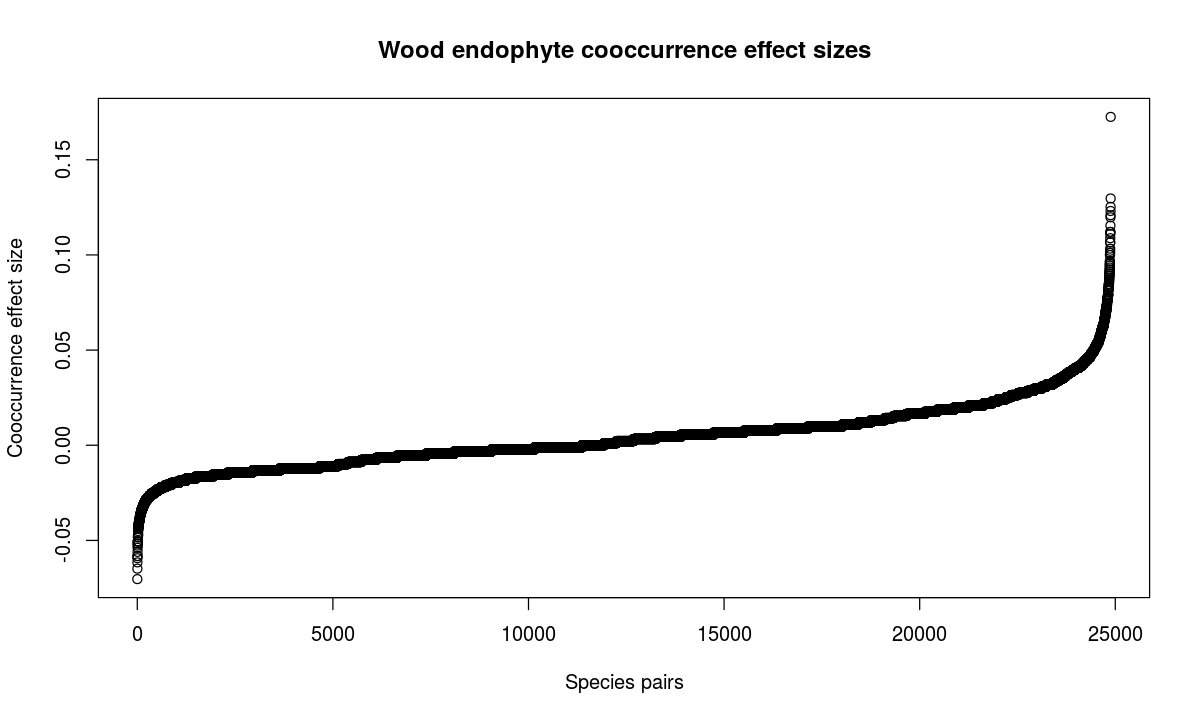

In [326]:
options(repr.plot.width = 10,repr.plot.height = 6)
plot(sort(woodcoocPC$effect), 
     xlab='Species pairs', 
     ylab = 'Cooccurrence effect size',
    main='Wood endophyte cooccurrence effect sizes')

Pretty standard sigmoidal curve, most of the species don't really seem to have effect on each other, and at either end we have some stronger negative and postive effects.

This is a massive number of tests, ~10,000. So let's correct with a benjamini-hochberg adjustment, and pick out interactions with an fdr of .05 or less. 

In [328]:
## add a corrected pvalue, benjamini-hochberg
woodcoocPC$p_gt_adj <- p.adjust(woodcoocPC$p_gt, method = "BH")
#save(woodcoocPC,file='woodcoocPC.rda')
## look for only strong effects, sig p vals
strong_woodcooc <- woodcoocPC[woodcoocPC$p_gt_adj <= 0.05,]

In [330]:
## clean up col names
strong_woodcooc <- strong_woodcooc[,-c(12,13)]
colnames(strong_woodcooc)[10:11] <- c('OTU_A','OTU_B')

In [333]:
head(strong_woodcooc)

sp1 sp2 sp1_inc sp2_inc obs_cooccur prob_cooccur exp_cooccur p_lt   
294 13  187 22      20      15          0.053        4.8         1.00000
298 13  197 22      17      11          0.045        4.1         0.99999
326 13  248 22       9       9          0.024        2.2         1.00000
374 13  420 22      26      22          0.069        6.3         1.00000
384 13  435 22      24      13          0.064        5.8         0.99998
386 13  456 22      10       9          0.027        2.4         1.00000
    p_gt    OTU_A             OTU_B      effects    p_gt_adj   
294 0.00000 Helicia_formosana OTU352:1w  0.11208791 0.000000000
298 0.00008 Helicia_formosana OTU726:72w 0.07582418 0.022880000
326 0.00000 Helicia_formosana OTU269:1w  0.07472527 0.000000000
374 0.00000 Helicia_formosana OTU287:3w  0.17252747 0.000000000
384 0.00017 Helicia_formosana OTU250:4w  0.07912088 0.037104737
386 0.00001 Helicia_formosana OTU257:3w  0.07252747 0.006547895

In [340]:
strong_woodcooc

sp1 sp2  sp1_inc sp2_inc obs_cooccur prob_cooccur exp_cooccur p_lt   
294   13  187  22      20      15          0.053         4.8        1.00000
298   13  197  22      17      11          0.045         4.1        0.99999
326   13  248  22       9       9          0.024         2.2        1.00000
374   13  420  22      26      22          0.069         6.3        1.00000
384   13  435  22      24      13          0.064         5.8        0.99998
386   13  456  22      10       9          0.027         2.4        1.00000
432   13  725  22      15      13          0.040         3.6        1.00000
618   23  717   5      19       5          0.011         1.0        1.00000
1498  56   62  25      58      25          0.175        15.9        1.00000
1609  56  237  25      25      17          0.075         6.9        1.00000
1616  56  255  25      22      14          0.066         6.0        1.00000
1909  57  164  23       8       7          0.022         2.0        0.99999
2191  58   65  38      19      16          0.087         7.9        1.00000
2193  58   67  38      33      25          0.151        13.8        1.00000
2194  58   68  38      15      13          0.069         6.3        0.99999
2196  58   70  38      27      20          0.124        11.3        0.99999
2197  58   72  38      43      29          0.197        18.0        1.00000
2243  58  144  38      15      13          0.069         6.3        0.99999
2248  58  151  38      21      18          0.096         8.8        1.00000
2251  58  158  38      13      12          0.060         5.4        1.00000
2286  58  208  38      22      18          0.101         9.2        1.00000
2429  58  495  38      15      14          0.069         6.3        1.00000
2560  58  898  38      12      12          0.055         5.0        1.00000
2676  61   64  37      20      19          0.089         8.1        1.00000
2757  61  187  37      20      16          0.089         8.1        0.99999
2815  61  278  37      30      24          0.134        12.2        1.00000
3163  62   70  58      27      25          0.189        17.2        0.99999
3247  62  184  58      43      36          0.301        27.4        0.99998
3299  62  255  58      22      21          0.154        14.0        0.99999
3479  62  512  58      26      25          0.182        16.6        1.00000
⋮     ⋮   ⋮    ⋮       ⋮       ⋮           ⋮            ⋮           ⋮      
16777 203  230 24      22      14          0.064         5.8        1.00000
16839 203  366 24      12       9          0.035         3.2        0.99999
17438 208  908 22       8       7          0.021         1.9        1.00000
17474 210  225 30      32      21          0.116        10.5        1.00000
17521 210  324 30      14      11          0.051         4.6        0.99998
18470 217  278 15      30      12          0.054         4.9        1.00000
18608 219  371 20      36      16          0.087         7.9        1.00000
19499 230  756 22      15      10          0.040         3.6        0.99999
19949 243  324 22      14      10          0.037         3.4        1.00000
20154 248  321  9      20       7          0.022         2.0        0.99999
20166 248  420  9      26       9          0.028         2.6        1.00000
20337 255 1160 22      10       9          0.027         2.4        1.00000
20431 261  416 21      20      12          0.051         4.6        1.00000
20439 261  429 21       8       7          0.020         1.8        1.00000
22115 306  350  5      19       5          0.011         1.0        1.00000
22454 328  717 12      19       8          0.028         2.5        0.99998
22610 345  350 16      19      11          0.037         3.3        1.00000
23009 366  717 12      19       8          0.028         2.5        0.99998
23021 366  934 12       9       6          0.013         1.2        1.00000
23426 416  434 20      20      12          0.048         4.4        1.00000
23431 416  459 20      14      10          0.034      

In [334]:
dim(strong_woodcooc)

[1] 130  13

Okay, now that we have reduced our interactions to those with an fdr below .05, what's left standing? Looking at the effect sizes:


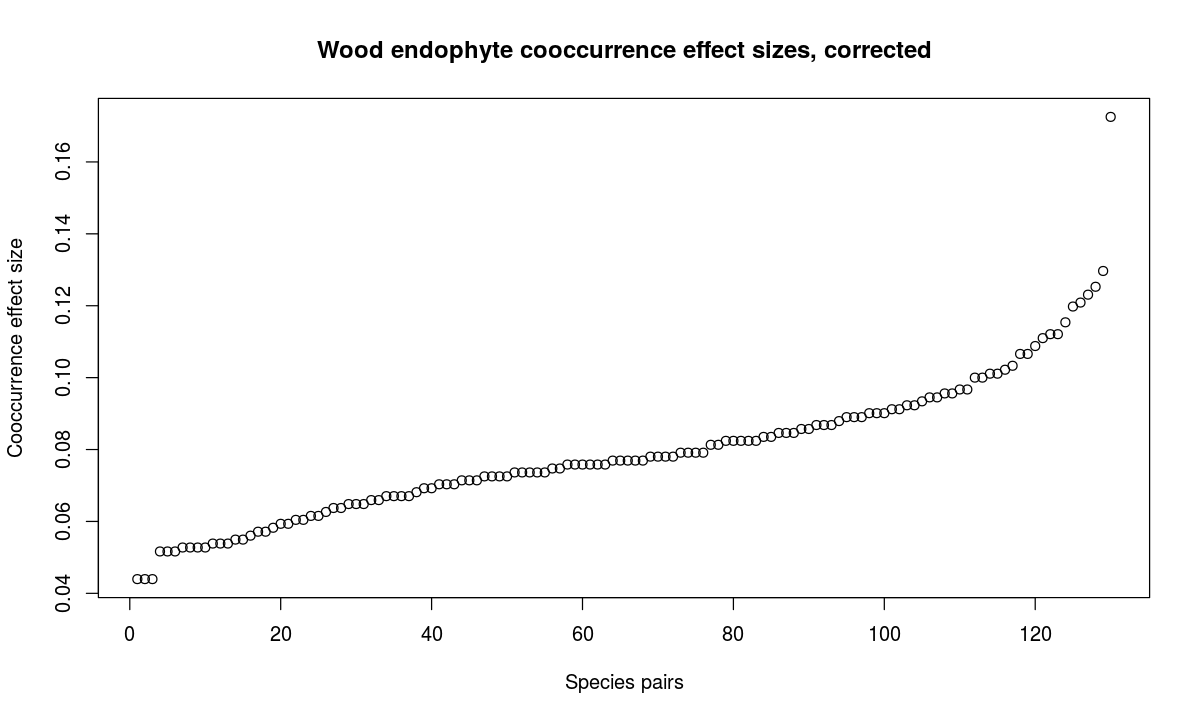

In [337]:
options(repr.plot.width = 10,repr.plot.height = 6)
plot(sort(strong_woodcooc$effect), 
    xlab='Species pairs',
    ylab = 'Cooccurrence effect size',
    main='Wood endophyte cooccurrence effect sizes, corrected')

Most interactions drop off, including all negative ones (because I used the p-value associated with positive interactions, "p_gt"). Let's graph these remaining cooccurrences, using the [igraph](#http://igraph.org/r/) package.  

In [338]:
aa <- strong_woodcooc[,c(10,11,12,13)]
graphcooc_wood <- graph_from_data_frame(aa, directed=FALSE) ## quick igraph object

In [339]:
#save(graphcooc_wood, file = 'graphcooc_wood.rda')

In [377]:
vcols <- vector(length = length(V(graphcooc_wood)))
vcols[] <- 'gray'
vcols[which(names(V(graphcooc_wood)) == "Helicia_formosana")] <- "red"
vcols[which(names(V(graphcooc_wood)) == "Myrsine_seguinii")] <- "darkgreen"
aa <- adjacent_vertices(graphcooc_wood, "Helicia_formosana", mode = c("all"))[[1]]
vcols[V(graphcooc_wood) %in% aa] <- "lightpink" ## color first-degrees purple
bb <- adjacent_vertices(graphcooc_wood, "Myrsine_seguinii", mode = c("all"))[[1]]
vcols[V(graphcooc_wood) %in% bb] <- "lightgreen" ## color first-degrees purple
helwoodfung <- names(aa) ## useful below, in mapping of core mycobiomes

<a id='helwoodnet'></a>
And take a look. The purple nodes are first degree associates of the host tree *Helicia formasana*, what we will call the core mycobiome of *H. formasana*. 

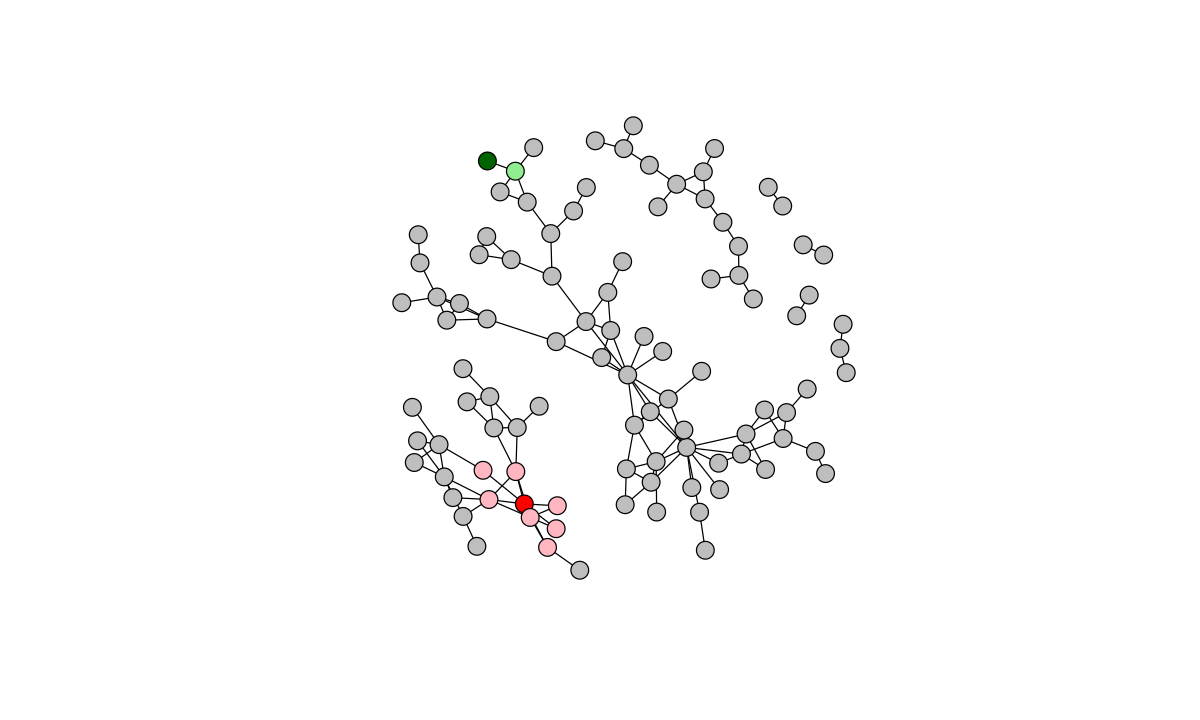

In [378]:
plot(graphcooc_wood, 
     vertex.color = vcols, 
     vertex.size = 8, 
     vertex.label = NA, 
     edge.color = 'black')

<a id='leafCooc'><h3>Leaf coocurrence networks</h3></a>

In [72]:
leaf95 <- subset_samples(deseq95, Library=="L") ## subset biom to leaf
leafOTU <- otu_table(leaf95) ## taxa are rows.

hostmat <- model.matrix(~0+Host_genus_species+Sample_ID,data=tp)
hostmat <- hostmat[,-35]
colnames(hostmat) <- gsub('Host_genus_species','',colnames(hostmat))
hostmat <- t(hostmat)

In [73]:
## get rid of underscores:
colnames(leafOTU) <- gsub('leaf.?', '', colnames(leafOTU))

In [74]:
head(hostmat, n=1)

1 2 3 4 5 6 7 8 9 10 ⋯ 124 125 126 127 128 129 130 131 132
Adinandra_formosana 0 0 0 0 0 0 0 0 0 0  ⋯ 0   0   0   0   0   0   0   0   0  
                    133
Adinandra_formosana 0

In [75]:
head(leafOTU, n=1)

100      101      102 103      104 105 107 108 109 110 ⋯ 90 92 93
OTU19:100leaf 13.61471 4.479497 0   9.567495 0   0   0   0   0   0   ⋯ 0  0  0 
              94 95 96       97 98 99 9
OTU19:100leaf 0  0  11.57084 0  0  0  0

In [76]:
## order:
aa <- order(as.numeric(colnames(leafOTU)))
leafOTU <- leafOTU[,aa]
## subset columns in our host matrix
hostmat <- hostmat[,colnames(hostmat) %in% colnames(leafOTU)]
## worked?
all(colnames(hostmat) == colnames(leafOTU))

[1] TRUE

In [77]:
#Stack them, reduce leaf OTU reads to presence/absence:
host_leafOTU_mat <- rbind(hostmat, leafOTU)
host_leafOTU_mat[host_leafOTU_mat > 0] <- 1

In [79]:
save(host_leafOTU_mat, file="host_leafOTU_mat.rda")

In [78]:
leafcooc <- cooccur(host_leafOTU_mat, spp_names=TRUE)

  |======================================================================| 100%


In [80]:
save(leafcooc, file='leafcooc.rda')

In [81]:
leafcoocP <- prob.table(leafcooc)
leafcoocC <- effect.sizes(leafcooc)
leafcoocPC <- cbind(leafcoocP, leafcoocC)

Warning message in prob.table(leafcooc):
“The co-occurrence model was run using 'thresh = TRUE.' The probability table may not include all species pairs”

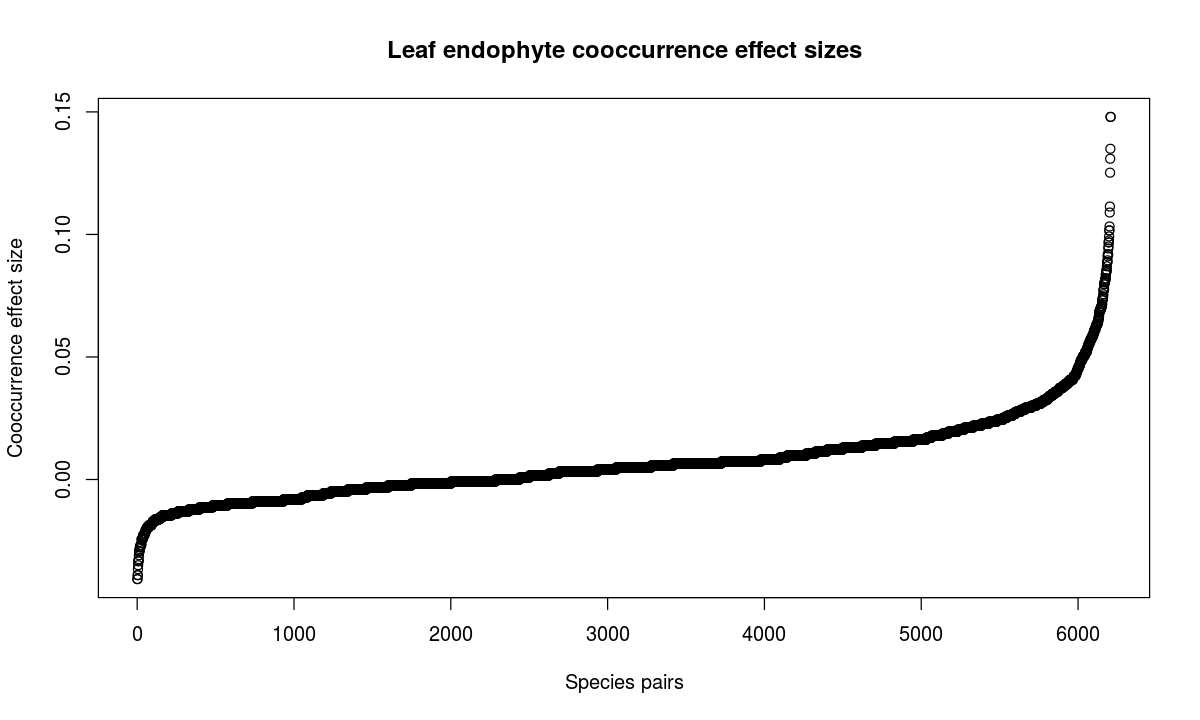

In [82]:
options(repr.plot.width = 10,repr.plot.height = 6)
plot(sort(leafcoocPC$effect), 
     xlab='Species pairs', 
     ylab = 'Cooccurrence effect size',
    main='Leaf endophyte cooccurrence effect sizes')

In [83]:
## add a corrected pvalue, benjamini-hochberg
leafcoocPC$p_gt_adj <- p.adjust(leafcoocPC$p_gt, method = "BH")
#save(leafcoocPC,file='leafcoocPC.rda')
## look for only strong effects, sig p vals
strong_leafcooc <- leafcoocPC[leafcoocPC$p_gt_adj <= 0.05,]

## clean up col names
strong_leafcooc <- strong_leafcooc[,-c(12,13)]
colnames(strong_leafcooc)[10:11] <- c('OTU_A','OTU_B')

In [86]:
dim(strong_leafcooc)

[1] 318  13

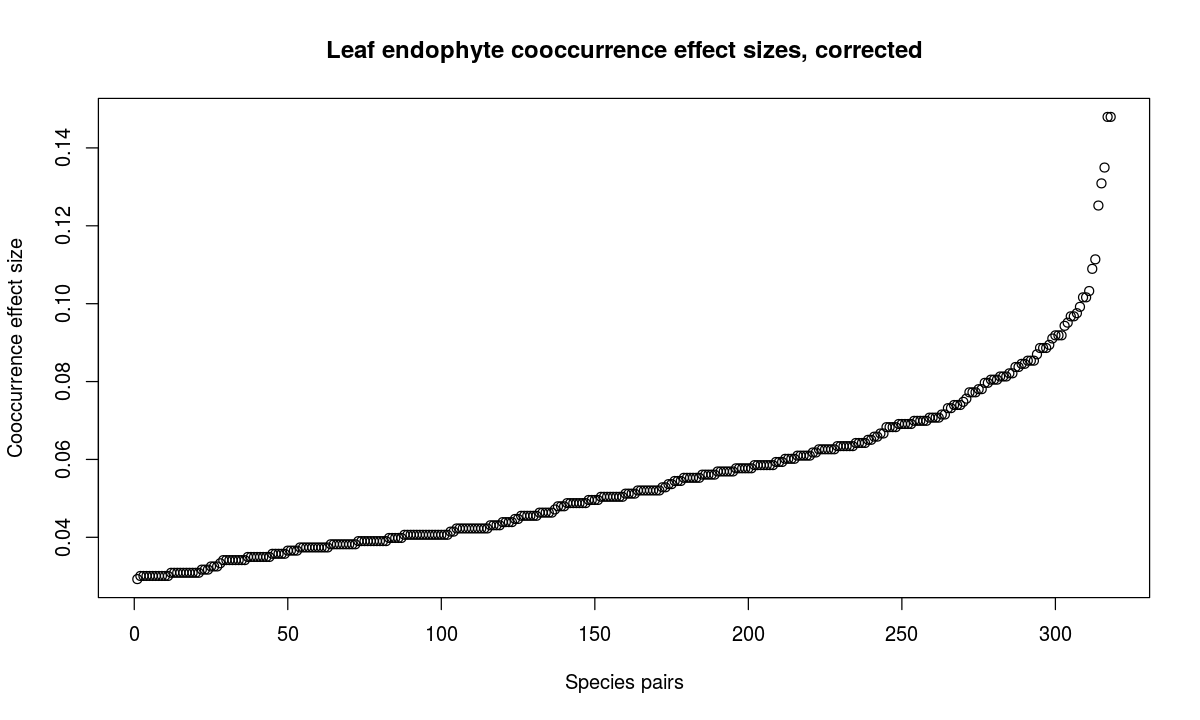

In [87]:
options(repr.plot.width = 10,repr.plot.height = 6)
plot(sort(strong_leafcooc$effect), 
    xlab='Species pairs',
    ylab = 'Cooccurrence effect size',
    main='Leaf endophyte cooccurrence effect sizes, corrected')

In [89]:
aa <- strong_leafcooc[,c(10,11,12,13)]
graphcooc_leaf <- graph_from_data_frame(aa, directed=FALSE) ## quick igraph object

In [90]:
#save(graphcooc_leaf, file = 'graphcooc_leaf.rda')

In [91]:
vcols <- vector(length = length(V(graphcooc_leaf)))
vcols[] <- 'gray'

In [93]:
names(V(graphcooc_leaf))

[1] "Blastus_cochinchinensis" "Helicia_formosana"      
 [3] "Limlia_uraiana"          "OTU19:100leaf"          
 [5] "OTU1:100leaf"            "OTU202:100leaf"         
 [7] "OTU10:100leaf"           "OTU17:100leaf"          
 [9] "OTU15:100leaf"           "OTU27:100leaf"          
[11] "OTU355:100leaf"          "OTU22:101leaf"          
[13] "OTU181:100leaf"          "OTU73:100leaf"          
[15] "OTU159:100leaf"          "OTU297:100leaf"         
[17] "OTU252:117leaf"          "OTU78:100leaf"          
[19] "OTU226:100leaf"          "OTU209:101leaf"         
[21] "OTU368:100leaf"          "OTU883:107leaf"         
[23] "OTU1938:130leaf"         "OTU93:100leaf"          
[25] "OTU263:100leaf"          "OTU319:100leaf"         
[27] "OTU360:100leaf"          "OTU247:17leaf"          
[29] "OTU45:100leaf"           "OTU53:107leaf"          
[31] "OTU280:100leaf"          "OTU97:102leaf"          
[33] "OTU94:114leaf"           "OTU340:103leaf"         
[35] "OTU462:101leaf"          "OTU124:101leaf"         
[37] "OTU405:101leaf"          "OTU436:102leaf"         
[39] "OTU115:101leaf"          "OTU343:103leaf"         
[41] "OTU546:101leaf"          "OTU116:117leaf"         
[43] "OTU218:102leaf"          "OTU663:110leaf"         
[45] "OTU489:125leaf"          "OTU1025:3leaf"          
[47] "OTU208:103leaf"          "OTU65:102leaf"          
[49] "OTU309:117leaf"          "OTU86:102leaf"          
[51] "OTU14:102leaf"           "OTU479:104leaf"         
[53] "OTU605:103leaf"          "OTU398:103leaf"         
[55] "OTU25:103leaf"           "OTU606:103leaf"         
[57] "OTU39:103leaf"           "OTU75:104leaf"          
[59] "OTU170:105leaf"          "OTU483:111leaf"         
[61] "OTU51:109leaf"           "OTU47:110leaf"          
[63] "OTU416:110leaf"          "OTU369:110leaf"         
[65] "OTU215:110leaf"          "OTU80:110leaf"          
[67] "OTU8:105leaf"            "OTU91:100leaf"          
[69] "OTU239:100leaf"          "OTU16:100leaf"          
[71] "OTU199:101leaf"          "OTU678:131leaf"         
[73] "OTU183:110leaf"          "OTU749:116leaf"         
[75] "OTU613:100leaf"          "OTU11:103leaf"          
[77] "OTU878:96leaf"           "OTU371:110leaf"         
[79] "OTU26:110leaf"           "OTU457:101leaf"         
[81] "OTU454:101leaf"          "OTU509:102leaf"         
[83] "OTU242:103leaf"          "OTU244:115leaf"         
[85] "OTU1005:81leaf"          "OTU303:111leaf"         
[87] "OTU470:103leaf"          "OTU557:116leaf"         
[89] "OTU440:102leaf"          "OTU48:102leaf"          
[91] "OTU223:104leaf"          "OTU472:111leaf"         
[93] "OTU31:105leaf"           "OTU135:117leaf"         
[95] "OTU464:111leaf"          "OTU23:119leaf"

In [99]:
vcols[which(names(V(graphcooc_leaf)) == "Helicia_formosana")] <- "red"
vcols[which(names(V(graphcooc_leaf)) == "Blastus_cochinchinensis")] <- "blue"
vcols[which(names(V(graphcooc_leaf)) == "Limlia_uraiana")] <- "orange"

aa <- adjacent_vertices(graphcooc_leaf, "Helicia_formosana", mode = c("all"))[[1]]
vcols[V(graphcooc_leaf) %in% aa] <- "lightpink" ## color first-degrees purple
bb <- adjacent_vertices(graphcooc_leaf, "Blastus_cochinchinensis", mode = c("all"))[[1]]
vcols[V(graphcooc_leaf) %in% bb] <- "lightblue" ## color first-degrees purple
cc <- adjacent_vertices(graphcooc_leaf, "Limlia_uraiana", mode = c("all"))[[1]]
vcols[V(graphcooc_leaf) %in% cc] <- "yellow" ## color first-degrees purple

helleaffung <- names(aa) ## useful below, in mapping of core mycobiomes

In [102]:
helleaffung

[1] "OTU19:100leaf"  "OTU202:100leaf" "OTU10:100leaf"  "OTU17:100leaf" 
 [5] "OTU15:100leaf"  "OTU27:100leaf"  "OTU94:114leaf"  "OTU91:100leaf" 
 [9] "OTU239:100leaf" "OTU16:100leaf"  "OTU199:101leaf" "OTU678:131leaf"

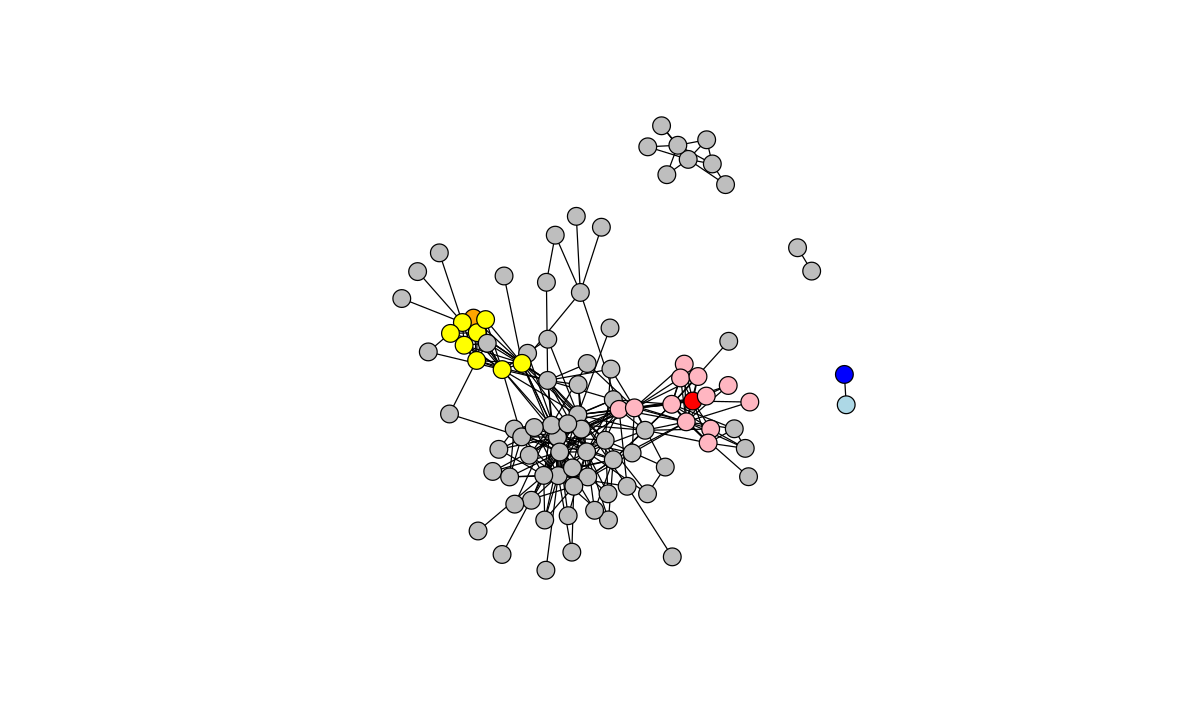

In [101]:
plot(graphcooc_leaf, 
     vertex.color = vcols, 
     vertex.size = 8, 
     vertex.label = NA, 
     edge.color = 'black')

<a id='comcomp'><h2>Community composition</h2></a>

Let's look at what's in our leaf and wood endophyte communities. 

In [103]:
load('deseq95.rda')
woodPA <- subset_samples(deseq95, Library == 'W')
leafPA <- subset_samples(deseq95, Library == 'L')
leafOTU <- otu_table(leafPA) ## extract otu table matrix
leafOTU[leafOTU > 0] <- 1 ## convert to P/A
leafOTU -> otu_table(leafPA) ## put it back in
woodOTU <- otu_table(woodPA) ## same with wood
woodOTU[woodOTU > 0] <- 1
woodOTU -> otu_table(woodPA)
leafPA <- prune_taxa(rowSums(otu_table(leafPA)) > 0, leafPA) ## get rid of empty taxa
woodPA <- prune_taxa(rowSums(otu_table(woodPA)) > 0, woodPA)

In [106]:
aa <- names(taxa_sums(leafPA))
bb <- names(taxa_sums(woodPA))
venn.diagram(list(Leaf = aa, Wood = bb),
        fill = c("green", "brown"),
        alpha = c(0.3, 0.7),
        cex = 2,
        cat.fontface = 4,
        fontfamily =3,
        imagetype = 'png',
        filename='overallvenn.png',
        )

[1] 1

<img src='overallvenn.png', width=400, height=400>

No shared species. But more species in general. Not sure why, there are couple places in the pipeline that could have caused this. 

We can look at how many of our OTUs in each belong to Ascomycota, how many to basidomycota, etc. Note that we are making no ecological statements here, doesn't matter if an OTU was observed from one site or all sites, they are all weighted equally as present in the study in wood or leaf tissue

In [124]:
leafphyplot <- table(tax_table(leafPA)[,"Phylum"])/nrow(otu_table(leafPA))
woodphyplot <- table(tax_table(woodPA)[,"Phylum"])/nrow(otu_table(woodPA))
bothphyplot <- as.table(rbind(leafphyplot, woodphyplot))

In [125]:
bothphyplot

              Ascomycota Basidiomycota Chytridiomycota Glomeromycota
leafphyplot 0.7373271889  0.0952380952    0.0176651306  0.0107526882
woodphyplot 0.7461728395  0.1733333333    0.0098765432  0.0054320988
            Neocallimastigomycota   Zygomycota
leafphyplot          0.0007680492 0.0038402458
woodphyplot          0.0009876543 0.0039506173

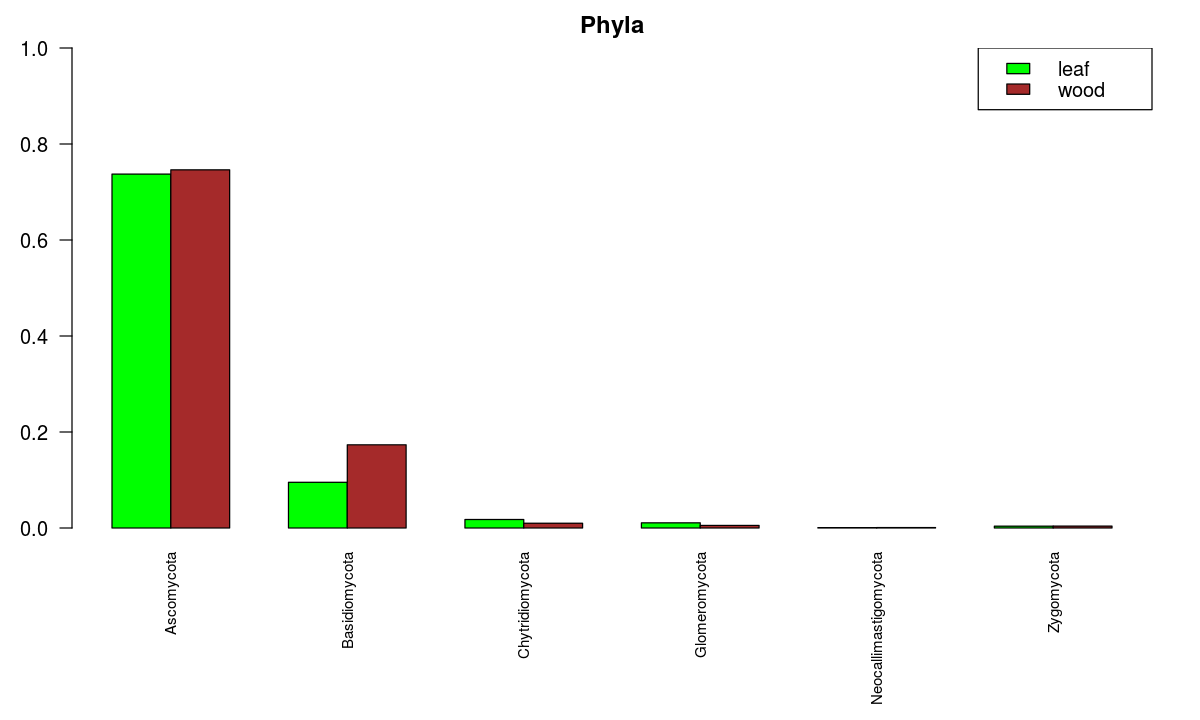

In [126]:
options(repr.plot.width = 10,repr.plot.height = 6)
par(mar = c(8,3,2,2))
barplot(bothphyplot,
        las=2,
        cex.names=0.75,
        ylim = c(0,1),
        main='Phyla',
        beside=TRUE,
        col = c('green','brown'),
        )

legend('topright',
        fill = c('green','brown'),
        legend= c('leaf','wood')
        )

Class level:

In [127]:
leafclasstable <- table(tax_table(leafPA)[,"Class"])/nrow(otu_table(leafPA))
woodclasstable <- table(tax_table(woodPA)[,"Class"])/nrow(otu_table(woodPA))
leafclassvector <- as.vector(leafclasstable); names(leafclassvector) <- names(leafclasstable)
woodclassvector <- as.vector(woodclasstable); names(woodclassvector) <- names(woodclasstable)
## which classes that are in leaves are not observed in wood? and vice-versa:
notinwoodclassvector <- names(leafclassvector)[!(names(leafclassvector) %in% names(woodclassvector))]
notinleafclassvector <- names(woodclassvector)[!(names(woodclassvector) %in% names(leafclassvector))]
## match up the membership and order of these vectors so we can rbind them 
notinwood <- vector(length=length(notinwoodclassvector))
notinwood[] <- 0; names(notinwood) <- notinwoodclassvector
fullwoodclassvector <- c(woodclassvector,notinwood)
notinleaf <- vector(length=length(notinleafclassvector))
notinleaf[] <- 0; names(notinleaf) <- notinleafclassvector
fullleafclassvector <- c(leafclassvector,notinleaf)
fullwoodclassvector <- fullwoodclassvector[names(fullleafclassvector)] ## match order
## put them in a matrix together
bothclass <- rbind(fullleafclassvector, fullwoodclassvector)

In [128]:
bothclass

Agaricomycetes Arthoniomycetes Chytridiomycetes
fullleafclassvector 0.08602151     0.0007680492    0.002304147     
fullwoodclassvector 0.09679012     0.0004938272    0.004938272     
                    Dothideomycetes Entomophthoromycotina_cls_Incertae_sedis
fullleafclassvector 0.2004608       0.0007680492                            
fullwoodclassvector 0.2706173       0.0004938272                            
                    Eurotiomycetes Glomeromycetes
fullleafclassvector 0.07526882     0.009216590   
fullwoodclassvector 0.14074074     0.005432099   
                    Kickxellomycotina_cls_Incertae_sedis Lecanoromycetes
fullleafclassvector 0.003072197                          0.18509985     
fullwoodclassvector 0.001481481                          0.03950617     
                    Leotiomycetes ⋯ Blastocladiomycetes Cystobasidiomycetes
fullleafclassvector 0.008448541   ⋯ 0.0000000000        0.0000000000       
fullwoodclassvector 0.039012346   ⋯ 0.0004938272        0.0004938272       
                    Exobasidiomycetes Mortierellomycotina_cls_Incertae_sedis
fullleafclassvector 0.0000000000      0.0000000000                          
fullwoodclassvector 0.0004938272      0.0009876543                          
                    Mucoromycotina_cls_Incertae_sedis Orbiliomycetes
fullleafclassvector 0.0000000000                      0.00000000    
fullwoodclassvector 0.0004938272                      0.02320988    
                    Pucciniomycetes Schizosaccharomycetes Taphrinomycetes
fullleafclassvector 0.00000000      0.0000000000          0.0000000000   
fullwoodclassvector 0.00345679      0.0004938272          0.0004938272   
                    Ustilaginomycotina_cls_Incertae_sedis
fullleafclassvector 0.0000000000                         
fullwoodclassvector 0.0009876543

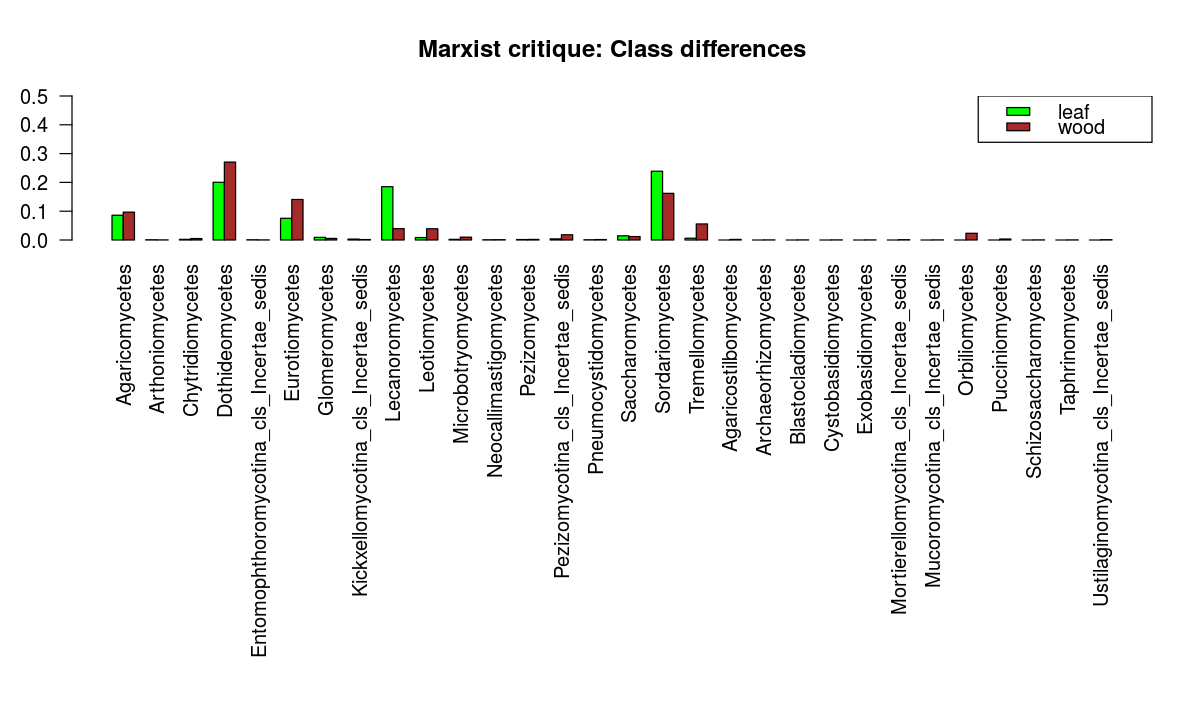

In [131]:
par(mar=c(20,3,4,2)) # increase y-axis margin.
#barplot(bothclasstable, 
barplot(bothclass,
        las=2,
        ylim = c(0,0.5),
        main='Marxist critique: Class differences',
        beside=TRUE,
        col = c('green','brown'),
        )
legend('topright',
        fill = c('green','brown'),
        legend= c('leaf','wood')
        )

<a id='allSpatial'><h2>All-host spatial analysis</h3><a>

<a id='mantel'><h3>Mantel tests</h3></a>

In [136]:
## wood endophytes
wood95 <- subset_samples(deseq95, Library=="W") ## subset biom to wood
## make our community distance matrix
aa <-t(otu_table(wood95))
aa[aa > 0] <- 1 ## P/A
wood_comdist <- vegdist(aa, method = "bray") 
## make our physical distance matrix
cc <- as.matrix(sample_data(wood95)[,c('X','Y')]) 
class(cc) <- "numeric"
physdist <- vegdist(cc, method = "euclidean")
woodmgram <- mgram(wood_comdist, physdist) ## correlogram object
wood_mant_test <- ecodist::mantel(wood_comdist ~ physdist, nperm = 10000) ## overall test

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

In [137]:
wood_mant_test

mantelr      pval1      pval2      pval3  llim.2.5% ulim.97.5% 
0.10203574 0.00440000 0.99570000 0.00620000 0.06503388 0.13588173

In [138]:
## leaf endophytes
leaf95 <- subset_samples(deseq95, Library=="L") 
aa <-t(otu_table(leaf95))
aa[aa > 0] <- 1 
leaf_comdist <- vegdist(aa, method = "bray")
cc <- as.matrix(sample_data(leaf95)[,c('X','Y')])
class(cc) <- "numeric"
physdist <- vegdist(cc, method = "euclidean")
leafmgram <- mgram(leaf_comdist, physdist)
leaf_mant_test <- ecodist::mantel(leaf_comdist ~ physdist, nperm = 10000)

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”

In [139]:
leaf_mant_test

mantelr        pval1        pval2        pval3    llim.2.5%   ulim.97.5% 
-0.005815431  0.573500000  0.426600000  0.831000000 -0.035740490  0.025208518

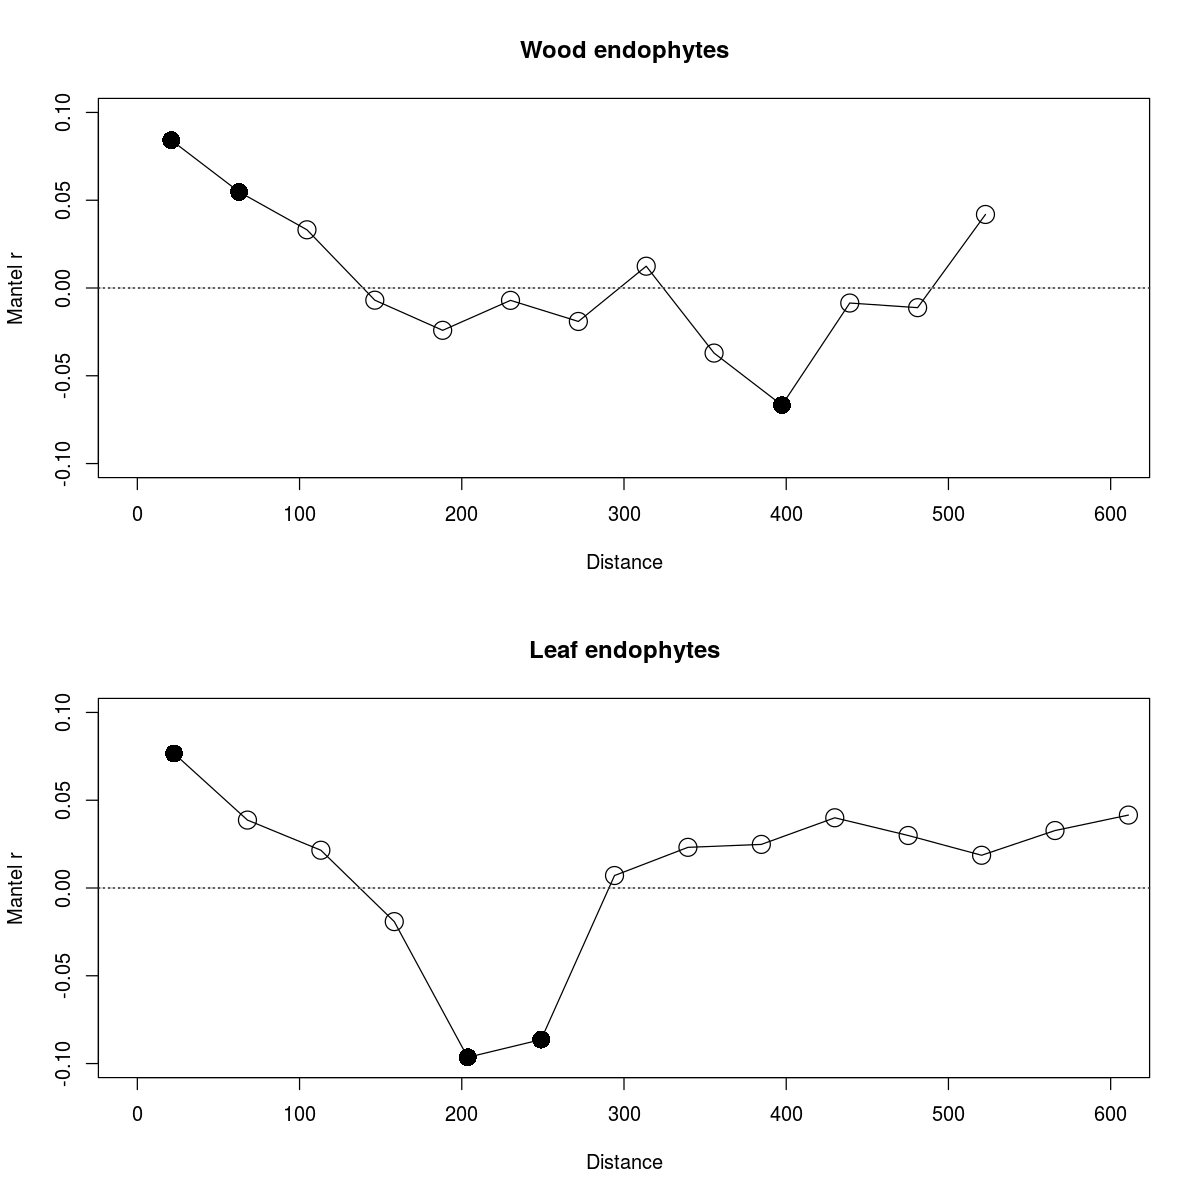

In [140]:
options(repr.plot.height = 10)
par(mfrow=c(2,1))
plot(woodmgram, 
        main="Wood endophytes",
        ylim=c(-.10,.10),
        xlim=c(0,600)
    )
abline(h=0,lty=3)
plot(leafmgram, 
        main="Leaf endophytes",
        ylim=c(-.10,.10),
        xlim=c(0,600)
    )
abline(h=0,lty=3)

<a id='dbMEMs'><h3>Distance-based MEMs</h3><a>

<a id='leafdbMEM'><h4>Leaf dbMEMs</h4></a>

See our previous statistical notebook for an explanation and references.

In [128]:
## make the leaf phyloseq object
load('deseq95.rda')
leaf95 <- subset_samples(deseq95, Library=="L") ## subset biom to leaf

In [129]:
## get a dataframe of the positions of points:
leafxy <- sample_data(leaf95)[,c('X', 'Y')]
rownames(leafxy) <- gsub("leaf.*","", rownames(leafxy) )
leafxy <- data.frame(leafxy[order(as.numeric(rownames(leafxy))),])
leafxy$X <- as.numeric(leafxy$X)
leafxy$Y <- as.numeric(leafxy$Y)

In [130]:
leafxy

X   Y  
1   360 220
2   360 221
3   361 221
4   361 220
5   363 220
6   363 223
7   360 223
8   360 227
9   360 235
12  360 347
13  367 220
14  375 220
15  391 220
16  423 220
17  487 220
19  423 283
20  391 251
21  375 235
22  367 227
23  360 360
24  360 361
25  361 361
26  361 360
27  360 364
28  363 363
29  363 360
30  367 360
31  376 360
32  391 360
33  423 360
⋮   ⋮   ⋮  
100 183  20
101 180  27
102 187  27
103 180  35
104 180  51
105 180  83
107 307 147
108 243  83
109 209  49
110 209  49
111 195  35
112 167  40
114  71  40
115  55  40
116  47  40
117  40  40
118  40  41
119  41  41
120  41  40
121  43  40
122  43  43
125  40  55
126  40  71
127  40 103
128  40 167
129 167 167
130 103 103
131  71  71
132  55  55
133  47  47

In [131]:
## make spanning tree, get farthest "nearest neighbor":
ptd <- dist(leafxy)
span.ptd <- spantree(ptd)
dmin <- max(span.ptd$dist) 

dmin

[1] 91.92388

In [132]:
## truncate our distance matrix using this distance.
ptd[ptd > dmin] <- 4*dmin
ptd.PCoA <- cmdscale(ptd, k=nrow(leafxy)-1, eig = TRUE)
nb.ev <- length(which(ptd.PCoA$eig > 0.0000001)) ## keep only the positive eigenvalues
ptd.PCNM <- data.frame(ptd.PCoA$points[1:nrow(leafxy), 1:nb.ev])

Warning message in cmdscale(ptd, k = nrow(leafxy) - 1, eig = TRUE):
“only 75 of the first 122 eigenvalues are > 0”

Let's see if any of them are useful, by seeing if they explain any variation in our species matrix with an RDA:

In [133]:
leafcom <- t(otu_table(leaf95)) ## get community matrix out of phyloseq
rownames(leafcom ) <- gsub("leaf.*","", rownames(leafxy) ) ## clean up names
leafcom <- data.frame(leafcom[order(as.numeric(rownames(leafcom))),]) ## order 
leafcom[leafcom > 0] <- 1 ## P/A
leafcom.hel <- decostand(leafcom,'hellinger') ## transform
leaf.pcnm.rda <- rda(leafcom.hel, ptd.PCNM) ## rda of our leaf community by the PCNMs
save(leafcom.hel, file='leafcom.hel.rda') ## need this for later...

In [134]:
leaf.pcnm.sigtest <- anova.cca(leaf.pcnm.rda) ## significance test 

In [135]:
leaf.pcnm.sigtest

Df Variance  F        Pr(>F)
Model    36 0.2715140 1.055838 0.005 
Residual 86 0.6143143       NA    NA

In [136]:
head(ptd.PCNM)

X1        X2        X3       X4       X5        X6        X7        X8       
1 -12.24390 -16.40882 192.3169 132.6053 -63.30822  6.643841  38.55102 13.856463
2 -12.24272 -16.40939 192.3333 132.6180 -63.31489  6.645941  38.43778 13.826450
3 -12.24178 -16.41082 192.3569 132.6372 -63.32377  6.633360  38.27449 13.769214
4 -12.24296 -16.41026 192.3404 132.6244 -63.31710  6.631260  38.38773 13.799227
5 -11.79384 -15.69972 189.6346 130.7484 -62.45369 10.247207 -15.57217 -3.092479
6 -11.79146 -15.70329 189.6854 130.7873 -62.47368 10.239083 -15.72366 -3.124420
  X9        X10       ⋯ X27       X28         X29         X30       X31        
1  45.68720 -9.285076 ⋯  1.338540  0.02512096 -0.08749394 -1.614784 -0.05943037
2  45.59288 -9.277983 ⋯  1.493526  0.03099111 -0.08574080 -1.754954 -0.07293468
3  45.47777 -9.313050 ⋯  1.794871  0.02686544 -0.09419784 -1.927929 -0.06762097
4  45.57208 -9.320143 ⋯  1.639885  0.02099529 -0.09595098 -1.787759 -0.05411667
5 -11.20009 23.496806 ⋯ -3.974415 -0.02898175  0.06989570  3.007039  0.08025067
6 -11.28586 23.401842 ⋯ -3.488050 -0.01112854  0.07476702  2.568579  0.03940487
  X32        X33          X34        X35          X36         
1 -0.4807450 -0.039814419  1.0041332 -0.008677632 0.0059164909
2  0.3706694 -0.001674269  1.1295285 -0.014071577 0.0000207561
3 -0.1497574 -0.021033100  1.0706720 -0.012253169 0.0024419644
4 -1.0011718 -0.059173250  0.9452767 -0.006859224 0.0083376991
5 -2.3986340 -0.140282092 -0.8895464  0.027550511 0.0263241466
6  0.1570197 -0.025534812 -0.5075401  0.011318488 0.0085600305

Lots of them. Do a model selection to find the important ones. 

In [137]:
mod0 <- rda(leafcom.hel ~ 1, ptd.PCNM) ## make a model with no terms
mod1 <- rda(leafcom.hel ~ ., ptd.PCNM) ## and one with all terms

In [138]:
mod0

Call: rda(formula = leafcom.hel ~ 1, data = ptd.PCNM)

              Inertia Rank
Total          0.8858     
Unconstrained  0.8858  122
Inertia is variance 

Eigenvalues for unconstrained axes:
    PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8 
0.04139 0.03765 0.02669 0.02327 0.02290 0.02085 0.01813 0.01756 
(Showed only 8 of all 122 unconstrained eigenvalues)


In [139]:
mod1

Call: rda(formula = leafcom.hel ~ X1 + X2 + X3 + X4 + X5 + X6 + X7 + X8
+ X9 + X10 + X11 + X12 + X13 + X14 + X15 + X16 + X17 + X18 + X19 + X20
+ X21 + X22 + X23 + X24 + X25 + X26 + X27 + X28 + X29 + X30 + X31 + X32
+ X33 + X34 + X35 + X36, data = ptd.PCNM)

              Inertia Proportion Rank
Total          0.8858     1.0000     
Constrained    0.2715     0.3065   36
Unconstrained  0.6143     0.6935   86
Inertia is variance 

Eigenvalues for constrained axes:
    RDA1     RDA2     RDA3     RDA4     RDA5     RDA6     RDA7     RDA8 
0.020544 0.018466 0.014712 0.012691 0.011540 0.010673 0.009853 0.009606 
    RDA9    RDA10    RDA11    RDA12    RDA13    RDA14    RDA15    RDA16 
0.008947 0.008709 0.008507 0.007775 0.007618 0.007235 0.007070 0.006934 
   RDA17    RDA18    RDA19    RDA20    RDA21    RDA22    RDA23    RDA24 
0.006670 0.006610 0.006163 0.006073 0.005990 0.005832 0.005698 0.005446 
   RDA25    RDA26    RDA27    RDA28    RDA29    RDA30    RDA31    RDA32 
0.005182 0.005104 0.004

In [140]:
step.res <- ordiR2step(mod0, mod1, perm.max = 1000) ## use them to compare the various possible combinations of terms

Step: R2.adj= 0 
Call: leafcom.hel ~ 1 
 
                  R2.adjusted
<All variables>  1.620984e-02
+ X8             2.620069e-03
+ X3             2.165231e-03
+ X34            2.039849e-03
+ X7             1.917903e-03
+ X9             1.718135e-03
+ X5             1.634330e-03
+ X29            1.608591e-03
+ X4             9.534867e-04
+ X1             7.976764e-04
+ X31            7.431715e-04
+ X36            5.931890e-04
+ X35            5.848153e-04
+ X33            5.778134e-04
+ X2             5.457400e-04
+ X13            4.846803e-04
+ X12            3.433390e-04
+ X14            2.848280e-04
+ X6             2.683434e-04
+ X24            2.244751e-04
+ X16            1.656106e-04
+ X26            7.449907e-05
<none>           0.000000e+00
+ X17           -3.125392e-05
+ X28           -6.246177e-05
+ X19           -2.736884e-04
+ X22           -3.101883e-04
+ X10           -3.482506e-04
+ X23           -3.731518e-04
+ X25           -4.337967e-04
+ X18           -4.374499e-0

In [141]:
step.res

Call: rda(formula = leafcom.hel ~ X8 + X3 + X34 + X7 + X9 + X5 + X29,
data = ptd.PCNM)

              Inertia Proportion Rank
Total         0.88583    1.00000     
Constrained   0.06287    0.07097    7
Unconstrained 0.82296    0.92903  115
Inertia is variance 

Eigenvalues for constrained axes:
    RDA1     RDA2     RDA3     RDA4     RDA5     RDA6     RDA7 
0.012774 0.011118 0.009905 0.008368 0.007642 0.006620 0.006441 

Eigenvalues for unconstrained axes:
    PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8 
0.03844 0.03281 0.02383 0.02233 0.02065 0.01928 0.01762 0.01653 
(Showed only 8 of all 115 unconstrained eigenvalues)


In [142]:
attributes(step.res$terms)$term.labels

[1] "X8"  "X3"  "X34" "X7"  "X9"  "X5"  "X29"

In [143]:
sigPCNM <- attributes(step.res$terms)$term.labels
sigPCNM <- sigPCNM[c(2,4,1,5,3)]

In [144]:
sigPCNM

[1] "X3"  "X7"  "X8"  "X9"  "X34"

In [146]:
leafPCNM <- ptd.PCNM[,sigPCNM]
#save(leafPCNM, file='leafPCNM.rda')

In [147]:
head(leafPCNM)

X3       X7        X8        X9        X34       
1 192.3169  38.55102 13.856463  45.68720  1.0041332
2 192.3333  38.43778 13.826450  45.59288  1.1295285
3 192.3569  38.27449 13.769214  45.47777  1.0706720
4 192.3404  38.38773 13.799227  45.57208  0.9452767
5 189.6346 -15.57217 -3.092479 -11.20009 -0.8895464
6 189.6854 -15.72366 -3.124420 -11.28586 -0.5075401

These are the important ones. But how important?

In [148]:
leaf.pcnm.rda2 <- rda(leafcom.hel ~ ., leafPCNM)

In [149]:
leaf.pcnm.rda2

Call: rda(formula = leafcom.hel ~ X3 + X7 + X8 + X9 + X34, data =
leafPCNM)

              Inertia Proportion Rank
Total         0.88583    1.00000     
Constrained   0.04550    0.05136    5
Unconstrained 0.84033    0.94864  117
Inertia is variance 

Eigenvalues for constrained axes:
    RDA1     RDA2     RDA3     RDA4     RDA5 
0.011971 0.009755 0.008990 0.007666 0.007112 

Eigenvalues for unconstrained axes:
    PC1     PC2     PC3     PC4     PC5     PC6     PC7     PC8 
0.03894 0.03425 0.02437 0.02234 0.02115 0.01974 0.01763 0.01656 
(Showed only 8 of all 117 unconstrained eigenvalues)


In [150]:
anova.cca(leaf.pcnm.rda2)

Df  Variance  F        Pr(>F)
Model      5 0.0454953 1.266867 0.001 
Residual 117 0.8403330       NA    NA

In [151]:
axes.test <- anova.cca(leaf.pcnm.rda2, by='axis') ## takes a minute

In [152]:
axes.test

Df  Variance    F         Pr(>F)
RDA1       1 0.011971460 1.6667926 0.018 
RDA2       1 0.009755155 1.3582153 0.147 
RDA3       1 0.008990062 1.2516911 0.227 
RDA4       1 0.007666317 1.0673853 0.581 
RDA5       1 0.007112302 0.9902495 0.507 
Residual 117 0.840332990        NA    NA

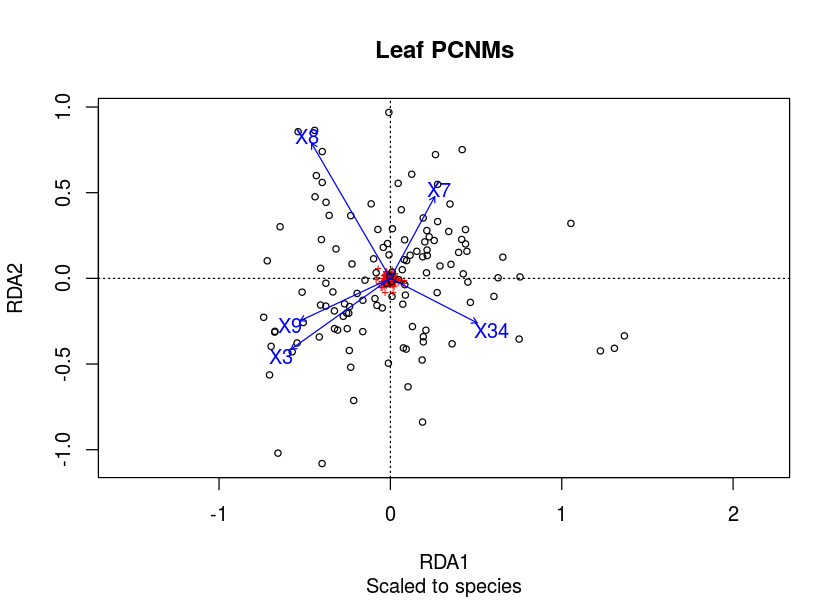

In [153]:
options(repr.plot.height = 5)
plot(leaf.pcnm.rda2, 
        display = c('sp','wa','bp'),
        scaling = 2,
        sub='Scaled to species',
        main='Leaf PCNMs'
)

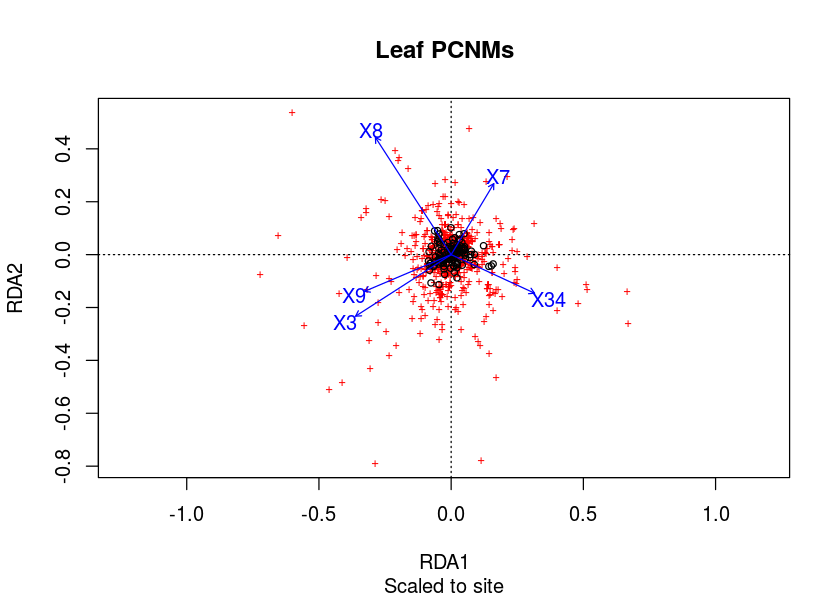

In [154]:
options(repr.plot.height = 5)
plot(leaf.pcnm.rda2, 
        display = c('sp','wa','bp'),
        scaling = 1,
        sub='Scaled to site',
        main='Leaf PCNMs'
)

Here we'll use a function that modifies the s.value function. It's in the supporting material for Borcard's book, [source code available here](http://adn.biol.umontreal.ca/~numericalecology/numecolR/)

In [155]:
source("/home/daniel/Documents/taiwan/taiwan_combined_stats/CSrev/NEwR-2ed_code_data/NEwR2-Functions/sr.value.R")

Make a function for viewing these.

In [175]:
mapP <- function(PCNM, P, bkg){
        require('png')
        topo <- readPNG(bkg) ## load scanned image of Fushan Map
        plot(1, type='n', 
                xlim=c(0,500), 
                ylim=c(0,500),
                xlab = '',
                ylab = '',
        main = paste('PCNM',colnames(PCNM)[P], sep = ' ')
        ) ##blank plot
        rasterImage(topo,0,0,500,500)
       sr.value(dfxy=leafxy,
        z=leafPCNM[,P],
#        clegend = 0, ## gets rid of legends, they can get in the way
        add.plot = TRUE,
)
}

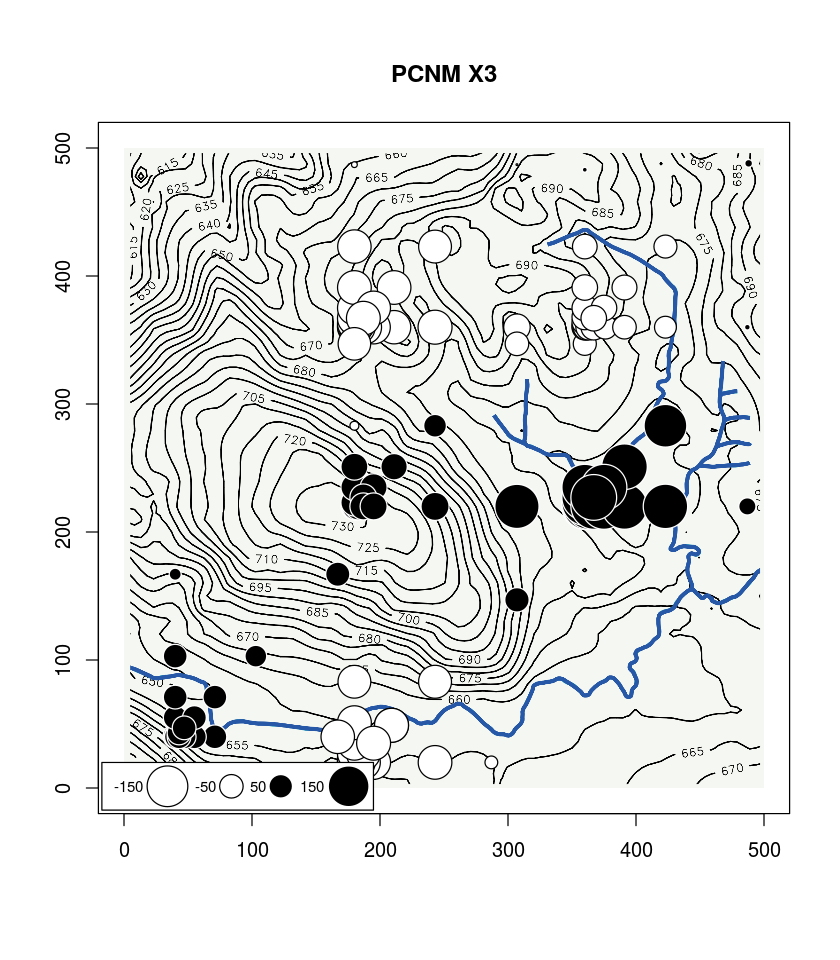

In [157]:
options(repr.plot.height = 8)
par(pty="s")
mapP(leafPCNM,1,'/home/daniel/Documents/taiwan/taiwan_combined_stats/topo.png')

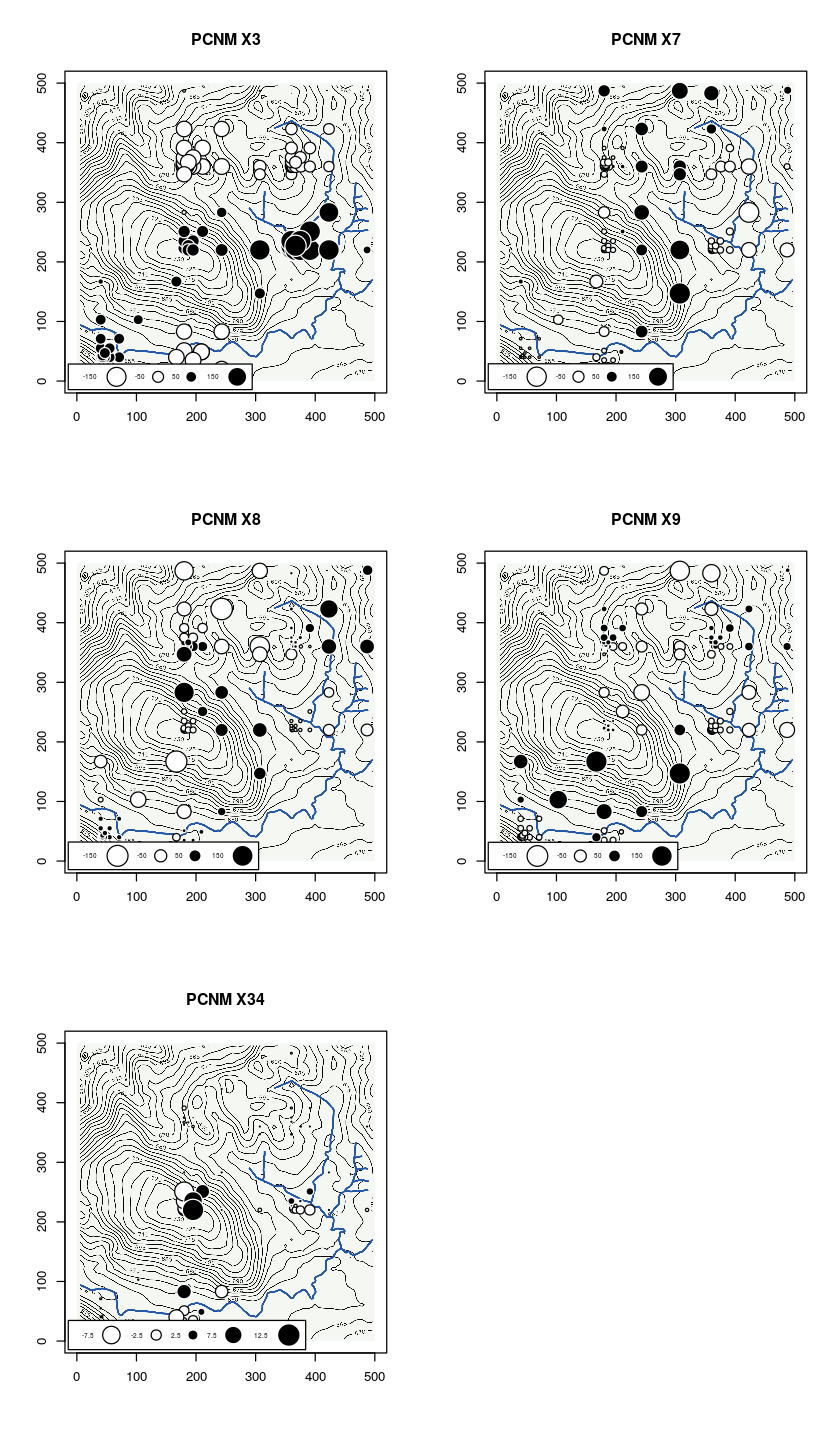

In [158]:
options(repr.plot.height = 12)
par(pty="s")
par(mfrow=c(3,2))
for (i in 1:5){mapP(leafPCNM,i,'/home/daniel/Documents/taiwan/taiwan_combined_stats/topo.png')}
par(mfrow=c(1,1))

Well, that's different from last time. Hmm... 

<h5>Check environmental correlations</h5>

In [160]:
leaf.env <- sample_data(leaf95)[,c('Forest_Type', 'vegcom')] ## fix weird rownames and order:
rownames(leaf.env) <- gsub("leaf.*","",rownames(leaf.env))

In [165]:
leaf.env <- data.frame(leaf.env[order(as.numeric(rownames(leaf.env))),])
leaf.env$Forest_Type <- as.factor(leaf.env$Forest_Type)
leaf.env$vegcom <- as.factor(leaf.env$vegcom)

all(rownames(leaf.env) == rownames(leafPCNM)) ## check order of rows match

[1] TRUE

In [166]:
head(leafPCNM)

X3       X7        X8        X9        X34       
1 192.3169  38.55102 13.856463  45.68720  1.0041332
2 192.3333  38.43778 13.826450  45.59288  1.1295285
3 192.3569  38.27449 13.769214  45.47777  1.0706720
4 192.3404  38.38773 13.799227  45.57208  0.9452767
5 189.6346 -15.57217 -3.092479 -11.20009 -0.8895464
6 189.6854 -15.72366 -3.124420 -11.28586 -0.5075401

In [167]:
leafPCNM.X3 <- lm(leafPCNM[,1] ~ ., data=leaf.env)
leafPCNM.X7 <- lm(leafPCNM[,2] ~ ., data=leaf.env)
leafPCNM.X8 <- lm(leafPCNM[,3] ~ ., data=leaf.env)
leafPCNM.X9 <- lm(leafPCNM[,4] ~ ., data=leaf.env)
leafPCNM.X34 <- lm(leafPCNM[,5] ~ ., data=leaf.env)

In [168]:
summary(leafPCNM.X3)


Call:
lm(formula = leafPCNM[, 1] ~ ., data = leaf.env)

Residuals:
     Min       1Q   Median       3Q      Max 
-139.293  -84.381    0.024   58.465  163.639 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)    66.020     63.465   1.040    0.300
Forest_Type2   -8.471     69.280  -0.122    0.903
Forest_Type3  -24.829     76.363  -0.325    0.746
Forest_Type4   66.397     98.734   0.672    0.503
Forest_Type5  -60.173    101.867  -0.591    0.556
Forest_Type6  -76.013     95.696  -0.794    0.429
Forest_Type7   33.133     94.126   0.352    0.725
vegcom2       -70.436     69.198  -1.018    0.311
vegcom3      -112.875     69.356  -1.627    0.106
vegcom4       -16.416     94.226  -0.174    0.862

Residual standard error: 89.75 on 113 degrees of freedom
Multiple R-squared:  0.2679,	Adjusted R-squared:  0.2096 
F-statistic: 4.594 on 9 and 113 DF,  p-value: 3.52e-05


In [169]:
summary(leafPCNM.X7)


Call:
lm(formula = leafPCNM[, 2] ~ ., data = leaf.env)

Residuals:
     Min       1Q   Median       3Q      Max 
-155.002  -10.425   -5.251    3.292  163.341 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)   -11.149     29.367  -0.380    0.705
Forest_Type2    6.033     32.058   0.188    0.851
Forest_Type3   58.521     35.336   1.656    0.100
Forest_Type4   -5.073     45.688  -0.111    0.912
Forest_Type5   22.347     47.137   0.474    0.636
Forest_Type6  -24.648     44.282  -0.557    0.579
Forest_Type7  -15.676     43.555  -0.360    0.720
vegcom2        24.202     32.020   0.756    0.451
vegcom3        22.431     32.093   0.699    0.486
vegcom4        43.617     43.602   1.000    0.319

Residual standard error: 41.53 on 113 degrees of freedom
Multiple R-squared:  0.1148,	Adjusted R-squared:  0.04426 
F-statistic: 1.628 on 9 and 113 DF,  p-value: 0.1156


In [170]:
summary(leafPCNM.X8)


Call:
lm(formula = leafPCNM[, 3] ~ ., data = leaf.env)

Residuals:
     Min       1Q   Median       3Q      Max 
-158.553   -2.282    3.794    8.804  129.318 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -12.722     28.085  -0.453 0.651446    
Forest_Type2   -3.221     30.659  -0.105 0.916516    
Forest_Type3   19.080     33.793   0.565 0.573449    
Forest_Type4  130.103     43.693   2.978 0.003555 ** 
Forest_Type5  104.186     45.080   2.311 0.022638 *  
Forest_Type6  123.447     42.349   2.915 0.004290 ** 
Forest_Type7  115.246     41.654   2.767 0.006616 ** 
vegcom2      -103.666     30.623  -3.385 0.000979 ***
vegcom3       -97.530     30.692  -3.178 0.001915 ** 
vegcom4       -82.874     41.698  -1.987 0.049289 *  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 39.72 on 113 degrees of freedom
Multiple R-squared:  0.1532,	Adjusted R-squared:  0.08573 
F-statistic: 2.271 on 9 and 113 DF,  p-value: 0

In [171]:
summary(leafPCNM.X9)


Call:
lm(formula = leafPCNM[, 4] ~ ., data = leaf.env)

Residuals:
     Min       1Q   Median       3Q      Max 
-125.599  -11.637    0.032   14.946  122.657 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)   
(Intercept)    6.1097    23.8001   0.257  0.79787   
Forest_Type2  -2.4392    25.9807  -0.094  0.92537   
Forest_Type3  82.8740    28.6370   2.894  0.00457 **
Forest_Type4  -5.8950    37.0265  -0.159  0.87379   
Forest_Type5   0.9476    38.2013   0.025  0.98025   
Forest_Type6  35.3143    35.8873   0.984  0.32720   
Forest_Type7  25.0797    35.2982   0.711  0.47885   
vegcom2      -34.8875    25.9501  -1.344  0.18151   
vegcom3      -31.4230    26.0092  -1.208  0.22951   
vegcom4      -36.8152    35.3360  -1.042  0.29970   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 33.66 on 113 degrees of freedom
Multiple R-squared:  0.2828,	Adjusted R-squared:  0.2257 
F-statistic: 4.951 on 9 and 113 DF,  p-value: 1.315e-05


In [172]:
summary(leafPCNM.X34)


Call:
lm(formula = leafPCNM[, 5] ~ ., data = leaf.env)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.2077 -0.2429  0.0475  0.3386 10.9976 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)   0.16925    1.49630   0.113    0.910
Forest_Type2  0.11849    1.63340   0.073    0.942
Forest_Type3 -0.92724    1.80040  -0.515    0.608
Forest_Type4 -0.88119    2.32785  -0.379    0.706
Forest_Type5 -0.32198    2.40170  -0.134    0.894
Forest_Type6 -0.26347    2.25622  -0.117    0.907
Forest_Type7 -0.33554    2.21919  -0.151    0.880
vegcom2       0.09221    1.63147   0.057    0.955
vegcom3       0.37872    1.63519   0.232    0.817
vegcom4       0.15983    2.22156   0.072    0.943

Residual standard error: 2.116 on 113 degrees of freedom
Multiple R-squared:  0.01447,	Adjusted R-squared:  -0.06402 
F-statistic: 0.1844 on 9 and 113 DF,  p-value: 0.9954


The only real evidence of environmental correlation is X8, which seems to be tightly related to the microtopography composite variable and the vegetation zones. Map this:

In [178]:
head(leafPCNM)

X3       X7        X8        X9        X34       
1 192.3169  38.55102 13.856463  45.68720  1.0041332
2 192.3333  38.43778 13.826450  45.59288  1.1295285
3 192.3569  38.27449 13.769214  45.47777  1.0706720
4 192.3404  38.38773 13.799227  45.57208  0.9452767
5 189.6346 -15.57217 -3.092479 -11.20009 -0.8895464
6 189.6854 -15.72366 -3.124420 -11.28586 -0.5075401

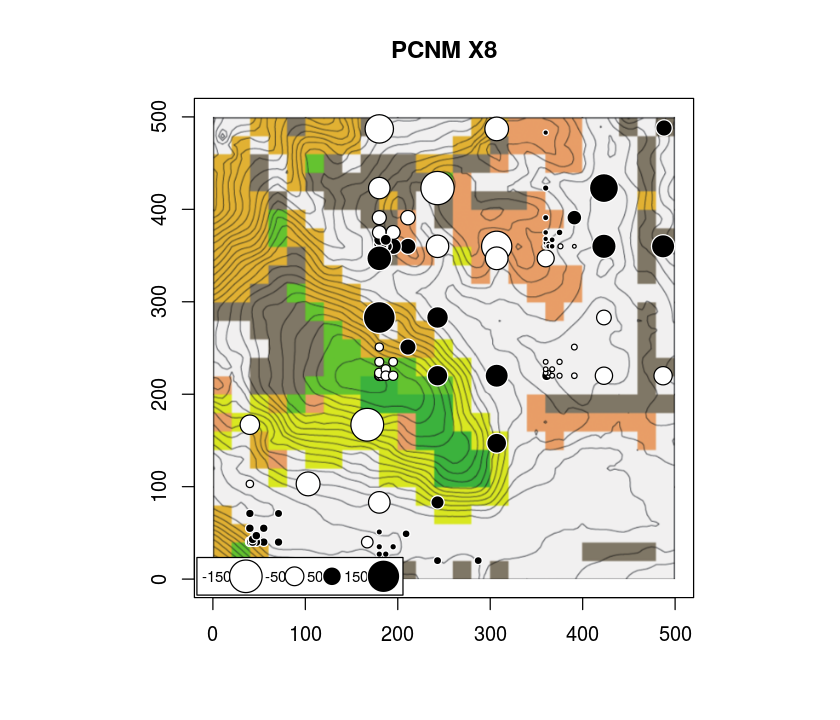

In [183]:
options(repr.plot.height = 6)
par(pty="s")
mapP(leafPCNM,3,'/home/daniel/Documents/taiwan/taiwan_combined_stats/forestmap.png')

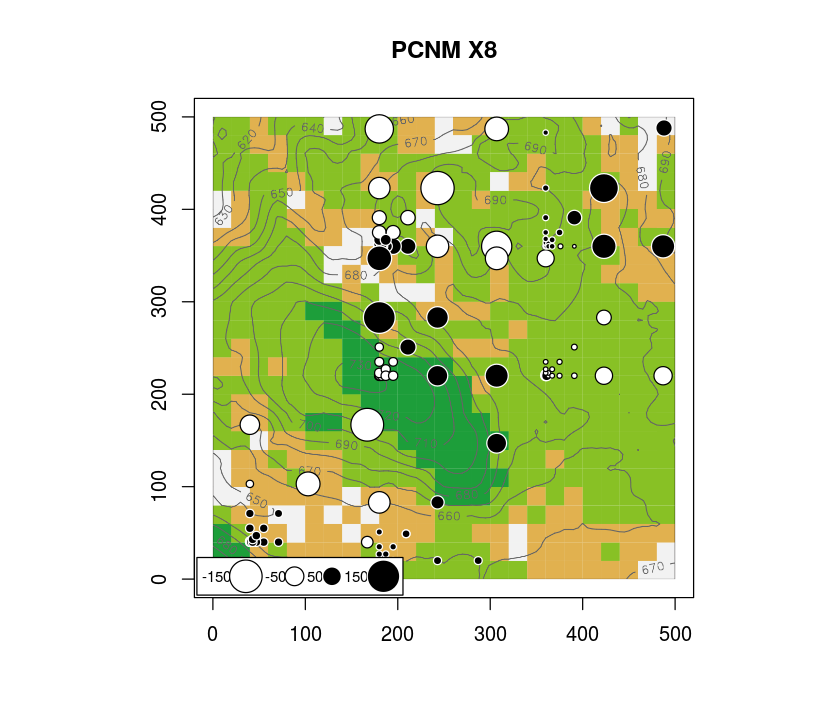

In [184]:
options(repr.plot.height = 6)
par(pty="s")
mapP(leafPCNM,3,'/home/daniel/Documents/taiwan/taiwan_combined_stats/fushveg.png')

<a id='wooddbMEM'><h4>Wood dbMEMs</h3></a>

In [88]:
## generate possible PCNMs for points where wood endophytes were sampled:
load('deseq95.rda')
wood95 <- subset_samples(deseq95, Library=="W")
woodxy <- sample_data(wood95)[,c('X', 'Y')]
rownames(woodxy) <- gsub("w.*","", rownames(woodxy) )
woodxy$X <- as.numeric(woodxy$X)
woodxy$Y <- as.numeric(woodxy$Y)

In [89]:
ptd <- dist(woodxy)
span.ptd <- spantree(ptd)
dmin <- max(span.ptd$dist) ## 90.51 m
ptd[ptd > dmin] <- 4*dmin
ptd.PCoA <- cmdscale(ptd, k=nrow(woodxy)-1, eig = TRUE)
nb.ev <- length(which(ptd.PCoA$eig > 0.0000001))
ptd.PCNM <- data.frame(ptd.PCoA$points[1:nrow(woodxy), 1:nb.ev])

Warning message in class(X) <- NULL:
“Setting class(x) to NULL;   result will no longer be an S4 object”Warning message in cmdscale(ptd, k = nrow(woodxy) - 1, eig = TRUE):
“only 51 of the first 90 eigenvalues are > 0”

In [90]:
## get our community matrix, check for redundancy with our new PCNMs.
woodcom <- t(otu_table(wood95)) 
rownames(woodcom) <- gsub("w.*","", rownames(woodcom) )
woodcom <- data.frame(woodcom)  
woodcom[woodcom > 0] <- 1 
woodcom.hel <- decostand(woodcom,'hellinger') 
wood.pcnm.rda <- rda(woodcom.hel, ptd.PCNM) 
wood.pcnm.sigtest <- anova.cca(wood.pcnm.rda) 
wood.pcnm.sigtest

Df Variance  F        Pr(>F)
Model    31 0.3126333 1.067526 0.001 
Residual 59 0.5573744       NA    NA

In [91]:
save(woodcom.hel, file='woodcom.hel.rda')

In [92]:
## select important components of the model:
mod0 <- rda(woodcom.hel ~ 1, ptd.PCNM)
mod1 <- rda(woodcom.hel ~ ., ptd.PCNM)
step.res <- ordiR2step(mod0, mod1, perm.max = 1000) ## 4 pcnms
step.res$anova

Step: R2.adj= 0 
Call: woodcom.hel ~ 1 
 
                  R2.adjusted
<All variables>  2.273028e-02
+ X3             7.446086e-03
+ X1             6.634900e-03
+ X20            2.333609e-03
+ X5             2.009092e-03
+ X30            1.448755e-03
+ X29            1.381123e-03
+ X18            1.343061e-03
+ X4             1.233672e-03
+ X2             1.120416e-03
+ X27            8.618764e-04
+ X24            5.939652e-04
+ X26            4.844883e-04
+ X22            4.443681e-04
+ X17            3.821384e-04
+ X16            1.433522e-04
<none>           0.000000e+00
+ X6            -9.384242e-05
+ X12           -3.149634e-04
+ X25           -3.337257e-04
+ X28           -3.491988e-04
+ X21           -4.286406e-04
+ X7            -4.287189e-04
+ X13           -4.399449e-04
+ X19           -5.682180e-04
+ X15           -8.672504e-04
+ X10           -9.373336e-04
+ X11           -1.088913e-03
+ X14           -1.183240e-03
+ X31           -1.212176e-03
+ X23           -1.221067e-0

R2.adj      Df AIC        F        Pr(>F)
+ X3            0.007446086  1 -11.374479 1.675175 0.002 
+ X1            0.014240998  1 -11.027857 1.613484 0.002 
+ X20           0.016791943  1 -10.303663 1.228317 0.016 
+ X5            0.019066375  1  -9.566450 1.201722 0.014 
+ X30           0.020807617  1  -8.792466 1.152929 0.044 
<All variables> 0.022730285 NA         NA       NA    NA

In [94]:
## subset to these, check the model again:
attributes(step.res$terms)$term.labels

[1] "X3"  "X1"  "X20" "X5"  "X30"

In [95]:
## subset to these, check the model again:
sigPCNM <- attributes(step.res$terms)$term.labels
sigPCNM <- sigPCNM[c(2,1,4,3,5)]

In [96]:
woodPCNM <- ptd.PCNM[,sigPCNM]
wood.pcnm.rda2 <- rda(woodcom.hel ~ ., woodPCNM)
axes.test <- anova.cca(wood.pcnm.rda2, by='axis') ## takes a minute

In [97]:
axes.test

Df Variance    F         Pr(>F)
RDA1      1 0.021677372 2.2901188 0.001 
RDA2      1 0.013171046 1.3914630 0.014 
RDA3      1 0.011633696 1.2290487 0.105 
RDA4      1 0.010018368 1.0583964 0.557 
RDA5      1 0.008930355 0.9434526 0.748 
Residual 85 0.804576845        NA    NA

In [98]:
wood.pcnm.rda2

Call: rda(formula = woodcom.hel ~ X1 + X3 + X5 + X20 + X30, data =
woodPCNM)

              Inertia Proportion Rank
Total         0.87001    1.00000     
Constrained   0.06543    0.07521    5
Unconstrained 0.80458    0.92479   85
Inertia is variance 

Eigenvalues for constrained axes:
    RDA1     RDA2     RDA3     RDA4     RDA5 
0.021677 0.013171 0.011634 0.010018 0.008930 

Eigenvalues for unconstrained axes:
     PC1      PC2      PC3      PC4      PC5      PC6      PC7      PC8 
0.031096 0.026215 0.025264 0.021274 0.017924 0.017047 0.016374 0.014673 
(Showed only 8 of all 85 unconstrained eigenvalues)


In [99]:
woodRDA2.sig <-anova.cca(wood.pcnm.rda2)

In [100]:
woodRDA2.sig

Df Variance   F        Pr(>F)
Model     5 0.06543084 1.382496 0.001 
Residual 85 0.80457685       NA    NA

In [104]:
#save(woodPCNM, file='woodPCNM.rda')

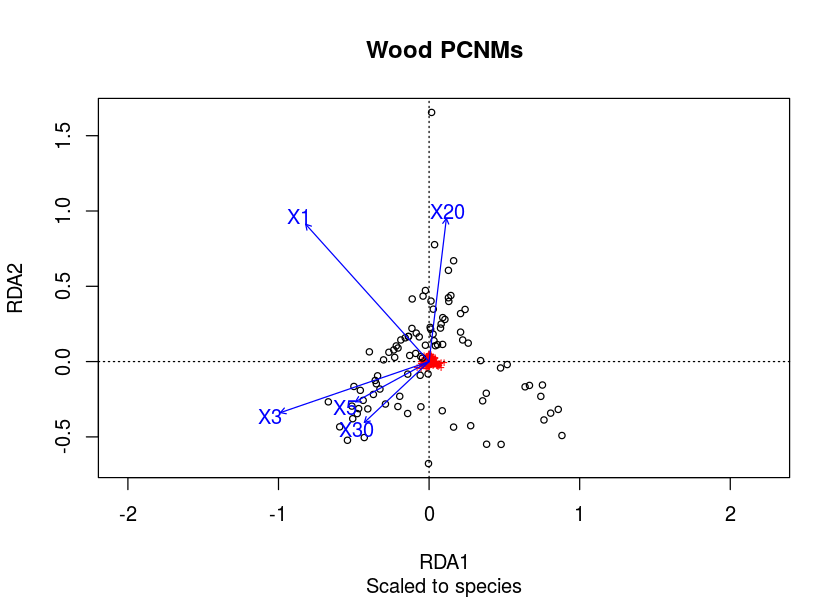

In [101]:
options(repr.plot.height = 5)
plot(wood.pcnm.rda2,
        display = c('sp','wa','bp'),
        scaling = 2,
        sub='Scaled to species',
        main='Wood PCNMs'
)

In [107]:
mapP <- function(PCNM, P, bkg){
        require('png')
        topo <- readPNG(bkg) 
        plot(1, type='n',
                xlim=c(0,500),
                ylim=c(0,500),
                xlab = '',
                ylab = '',
        main = paste('PCNM',colnames(PCNM)[P], sep = ' ')
        )
        rasterImage(topo,0,0,500,500)
        sr.value(dfxy=woodxy, z=PCNM[,P], add.plot = TRUE) ## changed for woodXY
}

In [108]:
source("/home/daniel/Documents/taiwan/taiwan_combined_stats/CSrev/NEwR-2ed_code_data/NEwR2-Functions/sr.value.R")

In [111]:
head(woodPCNM)

X1       X3        X5        X20        X30       
1 116.3280 -63.82517 -17.26254  -4.966470  1.4163441
2 115.6676 -65.31071 -18.74772 -10.672158 -0.2971716
3 115.6859 -65.32292 -18.75275  -9.964486 -0.2800219
4 115.6604 -65.30261 -18.74324 -10.661146 -0.2841266
5 115.6917 -65.32323 -18.75155  -9.246396 -0.2498117
7 115.7133 -65.34755 -18.76499  -9.279430 -0.2889467

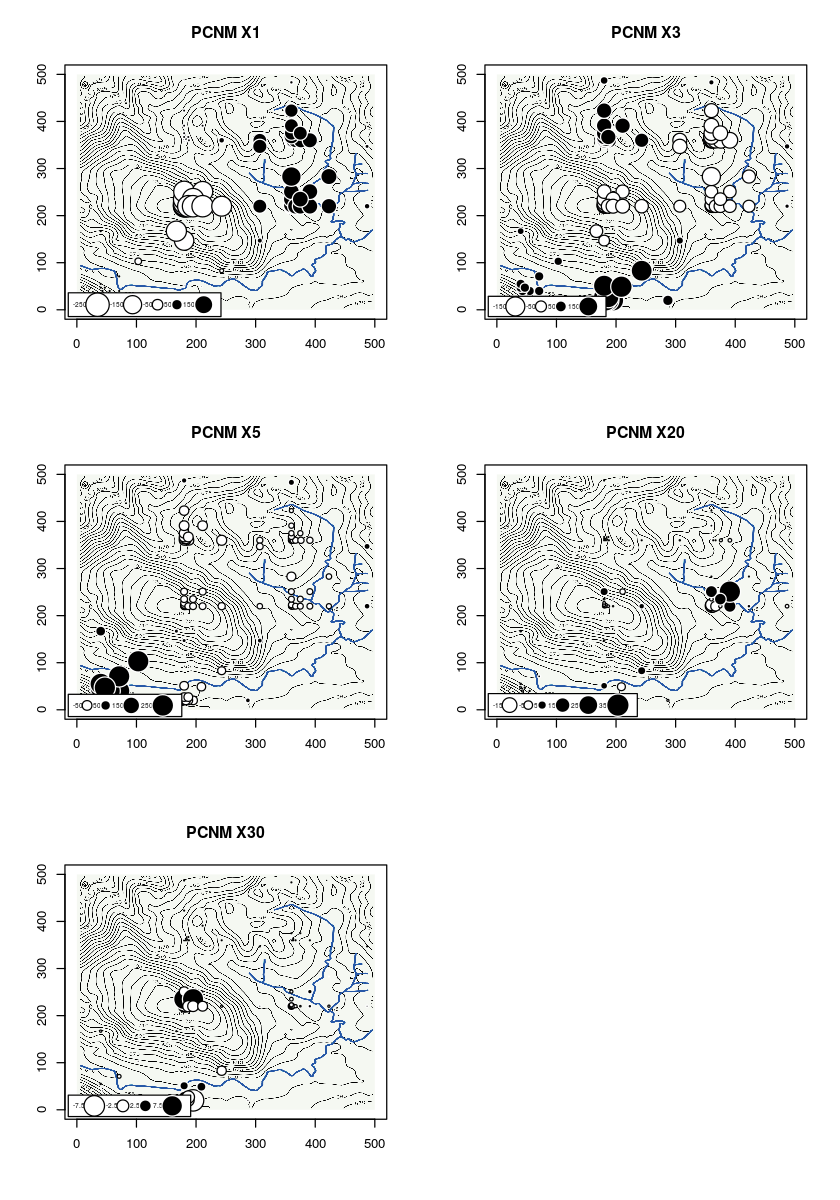

In [113]:
options(repr.plot.height = 10)
par(mfrow=c(3,2))
for (i in 1:ncol(woodPCNM)) mapP(woodPCNM, i, '/home/daniel/Documents/taiwan/taiwan_combined_stats/topo.png')
par(mfrow=c(1,1))

<h5>Check environmental correlations</h5>

In [114]:
## get wood environmental data
wood.env <- data.frame(sample_data(wood95)[,c('Forest_Type', 'vegcom')])
rownames(wood.env) <- gsub("w.*","", rownames(wood.env) )
        wood.env$Forest_Type <- as.factor(wood.env$Forest_Type)
        wood.env$vegcom <- as.factor(wood.env$vegcom)
#save(wood.env, file='wood.env.rda')

In [120]:
## run linear models
woodPCNM.X1 <- lm(woodPCNM[,1] ~ ., data=wood.env)
woodPCNM.X3 <- lm(woodPCNM[,2] ~ ., data=wood.env)
woodPCNM.X5 <- lm(woodPCNM[,3] ~ ., data=wood.env)
woodPCNM.X20 <- lm(woodPCNM[,4] ~ ., data=wood.env)
woodPCNM.X30 <- lm(woodPCNM[,5] ~ ., data=wood.env)

In [121]:
summary(woodPCNM.X1)


Call:
lm(formula = woodPCNM[, 1] ~ ., data = wood.env)

Residuals:
     Min       1Q   Median       3Q      Max 
-141.871  -37.025    0.213   29.077  109.758 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  -209.1236    37.1697  -5.626 2.56e-07 ***
Forest_Type2    0.1747    40.4077   0.004 0.996561    
Forest_Type3  119.1983    45.5234   2.618 0.010541 *  
Forest_Type4  131.2801    63.3136   2.073 0.041305 *  
Forest_Type5  252.6981    63.4404   3.983 0.000148 ***
Forest_Type6  202.4282    60.6131   3.340 0.001270 ** 
Forest_Type7  264.4201    59.3824   4.453 2.68e-05 ***
vegcom2        21.3763    46.0719   0.464 0.643909    
vegcom3       -13.6048    46.0719  -0.295 0.768525    
vegcom4       -55.7532    70.0561  -0.796 0.428453    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 52.57 on 81 degrees of freedom
Multiple R-squared:  0.8017,	Adjusted R-squared:  0.7797 
F-statistic: 36.39 on 9 and 81 DF,  p-

In [123]:
summary(woodPCNM.X3)


Call:
lm(formula = woodPCNM[, 2] ~ ., data = wood.env)

Residuals:
     Min       1Q   Median       3Q      Max 
-107.951  -49.454   -6.155   18.365  228.408 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -80.24273   51.40126  -1.561  0.12240   
Forest_Type2   0.07185   55.87907   0.001  0.99898   
Forest_Type3  96.26621   62.95343   1.529  0.13012   
Forest_Type4  89.81588   87.55515   1.026  0.30803   
Forest_Type5 142.29148   87.73057   1.622  0.10871   
Forest_Type6 254.49730   83.82073   3.036  0.00322 **
Forest_Type7 133.25377   82.11884   1.623  0.10854   
vegcom2      -92.91954   63.71202  -1.458  0.14859   
vegcom3       33.31424   63.71202   0.523  0.60248   
vegcom4      -16.28437   96.87928  -0.168  0.86693   
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 72.69 on 81 degrees of freedom
Multiple R-squared:  0.5385,	Adjusted R-squared:  0.4872 
F-statistic:  10.5 on 9 and 81 DF,  p-value: 1.35

In [124]:
summary(woodPCNM.X5)


Call:
lm(formula = woodPCNM[, 3] ~ ., data = wood.env)

Residuals:
     Min       1Q   Median       3Q      Max 
-130.341  -10.321   -6.484   10.532  256.505 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)   
(Intercept)  -2.449e+01  4.461e+01  -0.549  0.58455   
Forest_Type2  4.093e-04  4.849e+01   0.000  0.99999   
Forest_Type3  1.495e+01  5.463e+01   0.274  0.78506   
Forest_Type4  1.158e+02  7.598e+01   1.524  0.13141   
Forest_Type5 -2.738e+01  7.613e+01  -0.360  0.72010   
Forest_Type6 -5.305e+01  7.274e+01  -0.729  0.46791   
Forest_Type7  1.572e+00  7.126e+01   0.022  0.98245   
vegcom2       1.267e+01  5.529e+01   0.229  0.81934   
vegcom3       6.843e+01  5.529e+01   1.238  0.21945   
vegcom4       2.692e+02  8.407e+01   3.202  0.00195 **
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 63.08 on 81 degrees of freedom
Multiple R-squared:  0.4286,	Adjusted R-squared:  0.3651 
F-statistic: 6.749 on 9 and 81 DF,  p-

In [125]:
summary(woodPCNM.X20)


Call:
lm(formula = woodPCNM[, 4] ~ ., data = wood.env)

Residuals:
    Min      1Q  Median      3Q     Max 
-10.643  -0.447   0.017   0.211  32.011 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)
(Intercept)   -0.5998     3.4892  -0.172    0.864
Forest_Type2   0.2655     3.7931   0.070    0.944
Forest_Type3   2.4430     4.2733   0.572    0.569
Forest_Type4   3.0389     5.9433   0.511    0.611
Forest_Type5   2.6886     5.9552   0.451    0.653
Forest_Type6   2.4007     5.6898   0.422    0.674
Forest_Type7   2.4655     5.5743   0.442    0.659
vegcom2       -1.8953     4.3248  -0.438    0.662
vegcom3       -2.0967     4.3248  -0.485    0.629
vegcom4       -1.2670     6.5762  -0.193    0.848

Residual standard error: 4.934 on 81 degrees of freedom
Multiple R-squared:  0.009097,	Adjusted R-squared:  -0.101 
F-statistic: 0.08263 on 9 and 81 DF,  p-value: 0.9998


In [122]:
summary(woodPCNM.X30)


Call:
lm(formula = woodPCNM[, 5] ~ ., data = wood.env)

Residuals:
    Min      1Q  Median      3Q     Max 
-8.0828 -0.2426  0.1045  0.1631  7.5708 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)  
(Intercept)  -2.26915    1.28311  -1.768   0.0807 .
Forest_Type2  2.82912    1.39488   2.028   0.0458 *
Forest_Type3  1.86740    1.57148   1.188   0.2382  
Forest_Type4  1.50467    2.18560   0.688   0.4931  
Forest_Type5  2.02773    2.18998   0.926   0.3572  
Forest_Type6  2.13547    2.09238   1.021   0.3105  
Forest_Type7  2.00299    2.04990   0.977   0.3314  
vegcom2       0.13274    1.59041   0.083   0.9337  
vegcom3       0.67775    1.59041   0.426   0.6711  
vegcom4       0.00778    2.41835   0.003   0.9974  
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 1.815 on 81 degrees of freedom
Multiple R-squared:  0.06772,	Adjusted R-squared:  -0.03587 
F-statistic: 0.6537 on 9 and 81 DF,  p-value: 0.7478


The first PCNM seems heavily correlated with the microtopography variable ("forest type"). 

<a id='helSpace'><h2>Spatial patterns of Helicia mycobiome</h2></a>  

Let's look at the spatial patterns of the mycobiome of just one host, *Helicia formosana*.

In [187]:
load('deseq95.rda')
leafHel95 <- subset_samples(deseq95, Library == 'L' & Host_genus_species == "Helicia_formosana")
woodHel95 <- subset_samples(deseq95, Library == 'W' & Host_genus_species == "Helicia_formosana")

Check the environmental variables we have:

In [188]:
leafHelOTU <- t(otu_table(leafHel95))
leafHelOTU[leafHelOTU > 0] <- 1

ff <- as.factor(sample_data(leafHel95)$Forest_Type)
gg <- as.factor(sample_data(leafHel95)$vegcom)

lf <- adonis(leafHelOTU ~ ff, permutations=10000) ## topography
lg <- adonis(leafHelOTU ~ gg, permutations=10000) ## vegetative community

In [189]:
lf


Call:
adonis(formula = leafHelOTU ~ ff, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)
ff         4    1.2156 0.30389 0.92587 0.12468  0.657
Residuals 26    8.5337 0.32822         0.87532       
Total     30    9.7493                 1.00000       

In [190]:
lg


Call:
adonis(formula = leafHelOTU ~ gg, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)
gg         3    1.0377 0.34589   1.072 0.10644 0.2717
Residuals 27    8.7116 0.32265         0.89356       
Total     30    9.7493                 1.00000       

In [191]:
woodHelOTU <- t(otu_table(woodHel95))
woodHelOTU[woodHelOTU > 0] <- 1

ff <- as.factor(sample_data(woodHel95)$Forest_Type)
gg <- as.factor(sample_data(woodHel95)$vegcom)

lf <- adonis(woodHelOTU ~ ff, permutations=10000) ## topography
lg <- adonis(woodHelOTU ~ gg, permutations=10000) ## vegetative community

In [193]:
lf; lg


Call:
adonis(formula = woodHelOTU ~ ff, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)
ff         4    1.3655 0.34137  1.0643 0.20028 0.2022
Residuals 17    5.4525 0.32074         0.79972       
Total     21    6.8180                 1.00000       


Call:
adonis(formula = woodHelOTU ~ gg, permutations = 10000) 

Permutation: free
Number of permutations: 10000

Terms added sequentially (first to last)

          Df SumsOfSqs MeanSqs F.Model      R2 Pr(>F)
gg         3    1.0394 0.34648  1.0793 0.15245  0.188
Residuals 18    5.7786 0.32103         0.84755       
Total     21    6.8180                 1.00000       

Neither *Helicia* wood or leaf endos are displaying direct responses to our environmental variables. 